<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/BNP/BNP_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "bnp.pa"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  30.50  32.70  29.92  32.70      21.03   4883545
2009-01-05  33.19  33.19  31.65  31.85      20.49   4973988
2009-01-06  31.77  34.40  31.68  34.10      21.93   7598070
2009-01-07  33.90  35.83  33.71  35.00      22.51   7347091
2009-01-08  34.50  35.29  33.82  34.84      22.41   3847637
...           ...    ...    ...    ...        ...       ...
2018-12-21  39.43  39.58  38.72  39.50      36.81  10927531
2018-12-24  39.17  39.22  38.71  38.79      36.14   1161447
2018-12-27  39.66  39.80  38.18  38.54      35.92   4383597
2018-12-28  38.76  39.58  38.67  39.38      36.69   3343656
2018-12-31  39.51  39.85  39.20  39.47      36.78   1055466

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     49.527954    50.192649    48.813576    49.492050    38.362711  4.827470e+06
std       9.921304     9.830955    10.006953     9.922939    10.127279  2.534107e+06
min      21.240000    22.690000    20.660000    21.380000    13.750000  0.000000e+00
25%      44.290000    44.850000    43.567500    44.175000    32.727500  3.217502e+06
50%      51.340000    52.000000    50.650000    51.310000    37.590000  4.207678e+06
75%      55.892500    56.525000    55.152500    55.780000    44.580000  5.675408e+06
max      68.710000    69.170000    68.500000    68.890000    60.800000  2.417537e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  29.18  29.50  28.63  29.25      18.81   6675912   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  26.018139  25.145236  21.637792  27.806869  26.411186  25.200997      25.495      25.225  22.230368  25.40625  28.923981  24.9570  26.522222  25.40625  28.356667  24.736931               30.892068                 25.40625               19.920432               33.634976                 25.40625               17.177524               36.377885                 25.40625               14.434615               39.120794                 25.40625               11.691706  26.411186  28.217801  24.660263               31.897003                26.411186               20.925368               34.639912                26.411186               18.182459               37.382821                26.411186               15.439551               40.125729                26.411186   
2009-03-16  29.88  31.98  29.76  31.98      20.57   6925884   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  26.316232  25.174511  22.109524  29.696742  27.648700  26.255977      26.860      26.465  22.811939  26.31250  31.072998  26.2330  27.983056  26.31250  30.615000  24.928871               33.254220                 26.31250               19.370780               36.725080                 26.31250               15.899920               40.195940                 26.31250               12.429060               43.666800                 26.31250                8.958200  27.648700  30.911263  24.919042               34.590420                27.648700               20.706980               38.061280                27.648700               17.236120               41.532140                27.648700               13.765260               45.003000                27.648700   
2009-03-17  30.91  32.12  30.80  31.70   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     49.972666    50.628579    49.266492    49.934900    38.777889  4.776029e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    49.897817    49.814821    -1.307366    49.937352    49.915254    49.915555    49.879757    49.855110    49.740190    49.916055    49.936133    49.916561    49.922945    49.916055    49.933240    49.869838               51.924281                49.916055               47.907829               52.928393                49.916055               46.903716               53.932506                49.916055               45.899604               54.936619                49.916055               44.895491    49.915254    49.932627    49.877014               51.923479                49.915254               47.907028               52.927592                49.915254               46.902915               53.931705   
std       9.487455     9.412606     9.559453     9.493108     9.781472  2.484233e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     9.441652     9.412197    50.696476     9.504056     9.432115     9.408185     9.456973     9.429264     9.610635     9.458716     9.501008     9.471990     9.456102     9.458716     9.479689     9.438730                9.267284                 9.458716                9.773910                9.220582                 9.458716                9.974431                9.207336                 9.458716               10.201400                9.227689                 9.458716               10.453093     9.432115     9.470205     9.441150                9.244015                 9.432115                9.744487                9.199146                 9.432115                9.943797                9.187822   
min      23.500000    24.160000    22.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.125636  0.118640  0.129096  0.135064   0.057464   6675912   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.666675  0.086855  0.010797  0.000000    0.000000    0.000000  0.000000  0.000000  0.118816  0.000000  0.026222  0.000000  0.094519  0.000000                0.089742                 0.000000                0.011470                0.136508                 0.000000                0.025067                0.177098                 0.000000                0.037128                0.212443                 0.000000                0.047900  0.010797  0.090178  0.000000                0.109878                 0.010797                0.004703                0.152882                 0.010797                0.019146                0.190968                 0.010797                0.031897                0.224199                 0.010797   
2009-03-16  0.141119  0.173739  0.153779  0.194632   0.096970   6925884   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.007119  0.000700  0.670138  0.129204  0.040157  0.024858    0.032038    0.028986  0.012390  0.021210  0.166184  0.029538  0.060306  0.021210  0.145181  0.004487                0.144795                 0.021210                0.000000                0.203435                 0.021210                0.000000                0.254332                 0.021210                0.000000                0.298620                 0.021210                0.000000  0.040157  0.150733  0.006033                0.171450                 0.040157                0.000000                0.225482                 0.040157                0.000000                0.273021                 0.040157                0.000000                0.314501                 0.040157   
2009-03-17  0.163902  0.176850  0.176496  0.1885

140481

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 12 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_w58tvu
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.698963  0.602812              0.341972  0.458659  0.210368
1  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.697933  0.653776              0.356659  0.480748  0.231119
2  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.688331  0.626485              0.338317  0.469295  0.220238
3  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.660619  3.262334              0.349016  0.555079  0.308113
4  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.659024  3.716794              0.366062  0.592990  0.351638
5  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.652014  4.670979              0.355595  0.588650  0.346508
6  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.630449  1.726250              0.366760  0.566982  0.321469
7  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.614899  0.680232              0.413410  0.488434  0.238568
8  DeepLearning_grid_1_AutoML_20190827_152624_mod...  0.587520  2.024176              0.500000  0.510950  0.261069
9              DeepLearning_1_AutoML_20190827_152624  0.525950  1.361622              0.485314  0.535443  0.286700

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.007492
1            CDLLONGLINE             0.467003           0.467003    0.003499
2     CDLCLOSINGMARUBOZU             0.414661           0.414661    0.003107
3            CDLBELTHOLD             0.353669           0.353669    0.002650
4                    SUB             0.340576           0.340576    0.002552
...                  ...                  ...                ...         ...
1037             MA_24_3             0.104349           0.104349    0.000782
1038              T3_8_5             0.103577           0.103577    0.000776
1039      CDLHARAMICROSS             0.103190           0.103190    0.000773
1040             MA_12_6             0.102270           0.102270    0.000766
1041      CDL3LINESTRIKE             0.092949           0.092949    0.000696

[1042 rows x 4 columns]

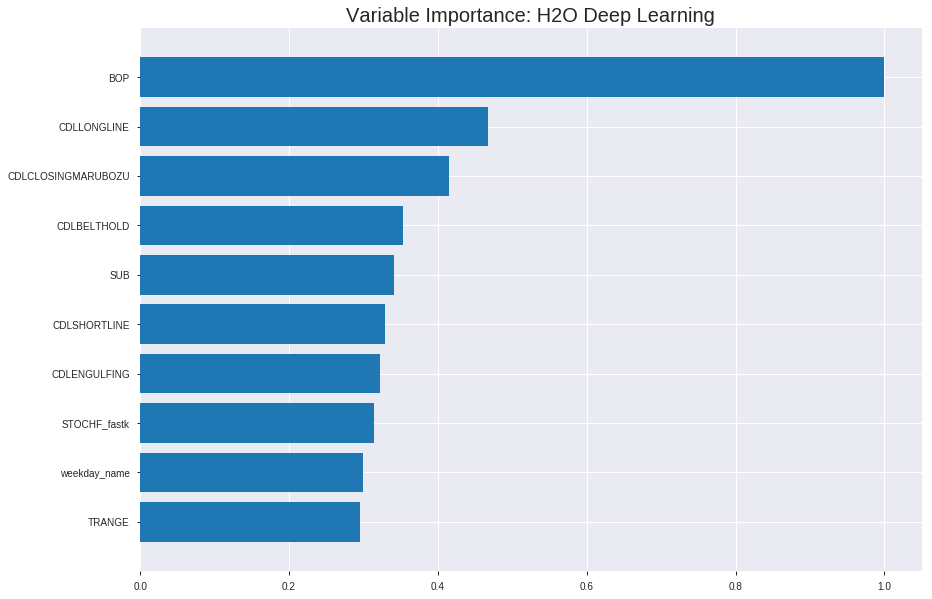

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_152624_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19649125961534958
RMSE: 0.44327334638499255
LogLoss: 0.5717694709568953
Mean Per-Class Error: 0.2956514380199722
AUC: 0.7733565951020089
pr_auc: 0.7742034542978955
Gini: 0.5467131902040179
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43912341347534517: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      378  485   0.562    (485.0/863.0)
1      83   807   0.0933   (83.0/890.0)
Total  461  1292  0.324    (568.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439123     0.739688  249
max f2                       0.277326     0.852128  316
max f0point5                 0.535293     0.709475  189
max accuracy                 0.530918     0.704507  192
max precision                0.998608     1         0
max recall                   0.0394399    1         388
max specificity              0.998608     1         0
max absolute_mcc             0.504665     0.412966  210
max min_per_class_accuracy   0.53318      0.7       191
max mean_per_class_accuracy  0.530918     0.704349  192

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 51.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.950028           1.96966   1.96966            1                0.974393  1                           0.974393            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.91891            1.96966   1.96966            1                0.930488  1                           0.95244             0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.889878           1.96966   1.96966            1                0.905785  1                           0.937476            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.869479           1.75081   1.91418            0.888889         0.878134  0.971831                    0.922431            0.0179775       0.0775281                  75.0811   91.4179
    5        0.0501997                   0.850741           1.8538    1.90252            0.941176         0.861181  0.965909                    0.910599            0.0179775       0.0955056                  85.38     90.2515
    6        0.100399                    0.757375           1.70107   1.80179            0.863636         0.797573  0.914773                    0.854086            0.0853933       0.180899                   70.1073   80.1794
    7        0.150029                    0.703264           1.42631   1.67758            0.724138         0.729933  0.851711                    0.813016            0.0707865       0.251685                   42.6308   67.7584
    8        0.200228                    0.659348           1.4101    1.61052            0.715909         0.679927  0.817664                    0.779649            0.0707865       0.322472                   41.01     61.0522
    9        0.300057                    0.604806           1.4069    1.54278            0.714286         0.629598  0.78327                     0.729727            0.140449        0.462921                   40.6902   54.2778
    10       0.399886                    0.55853            1.13678   1.44142            0.577143         0.580174  0.731812                    0.692392            0.113483        0.576404                   13.6777   44.1422
    11       0.500285                    0.532979           1.20866   1.39471            0.613636         0.545152  0.708096                    0.662843            0.121348        0.697753                   20.8657   39.471
    12       0.600114                    0.503733           1.01297   1.33121            0.514286         0.51834   0.675856                    0.638805            0.101124        0.798876                   1.29695   33.1208
    13       0.699943                    0.459824           0.787865  1.25371            0.4              0.482045  0.636512                    0.616447            0.0786517       0.877528                   -21.2135  25.3714
    14       0.799772                    0.391557           0.630292  1.1759             0.32             0.428646  0.597004                    0.593006            0.0629213       0.940449                   -36.9708  17.5897
    15       0.899601                    0.233747           0.405188  1.09037            0.205714         0.324108  0.553583                    0.563166            0.0404494       0.980899                   -59.4812  9.03714
    16       1                           0.0011055          0.190252  1                  0.0965909        0.105785  0.507701                    0.517245          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2211040133481689
RMSE: 0.4702169853888403
LogLoss: 0.6325665262885073
Mean Per-Class Error: 0.35299625468164786
AUC: 0.7021351515733538
pr_auc: 0.7073666199896514
Gini: 0.40427030314670764
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3845705943170105: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   177  0.7564   (177.0/234.0)
1      15   252  0.0562   (15.0/267.0)
Total  72   429  0.3832   (192.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384571     0.724138  297
max f2                       0.261322     0.858717  343
max f0point5                 0.501018     0.669615  197
max accuracy                 0.501018     0.656687  197
max precision                0.972864     1         0
max recall                   0.192257     1         357
max specificity              0.972864     1         0
max absolute_mcc             0.485359     0.313339  217
max min_per_class_accuracy   0.531428     0.559829  157
max mean_per_class_accuracy  0.501018     0.647004  197

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.87036            1.25094   1.25094            0.666667         0.925078  0.666667                    0.925078            0.0149813       0.0149813                  25.0936    25.0936
    2        0.0219561                   0.816899           1.8764    1.53524            1                0.828343  0.818182                    0.881108            0.0187266       0.0337079                  87.6404    53.524
    3        0.0319361                   0.80033            1.50112   1.52458            0.8              0.806368  0.8125                      0.857751            0.0149813       0.0486891                  50.1124    52.4579
    4        0.0419162                   0.76331            1.50112   1.51899            0.8              0.778781  0.809524                    0.838949            0.0149813       0.0636704                  50.1124    51.8994
    5        0.0518962                   0.741751           1.50112   1.51556            0.8              0.753799  0.807692                    0.822574            0.0149813       0.0786517                  50.1124    51.5557
    6        0.101796                    0.670913           1.35101   1.4349             0.72             0.703516  0.764706                    0.764212            0.0674157       0.146067                   35.1011    43.4898
    7        0.151697                    0.610968           1.72629   1.53075            0.92             0.638564  0.815789                    0.72288             0.0861423       0.23221                    72.6292    53.0751
    8        0.201597                    0.588275           1.42607   1.50484            0.76             0.59768   0.80198                     0.69189             0.071161        0.303371                   42.6067    50.4839
    9        0.301397                    0.53782            1.2009    1.4042             0.64             0.561587  0.748344                    0.648743            0.11985         0.423221                   20.0899    40.4197
    10       0.576846                    0.531428           0.992591  1.20765            0.528986         0.531554  0.643599                    0.592784            0.273408        0.696629                   -0.740922  20.7651
    11       0.600798                    0.52435            1.09457   1.20314            0.583333         0.527542  0.641196                    0.590183            0.0262172       0.722846                   9.45693    20.3143
    12       0.700599                    0.482685           1.08831   1.18679            0.58             0.503214  0.632479                    0.577795            0.108614        0.831461                   8.83146    18.6786
    13       0.800399                    0.428451           0.637978  1.11836            0.34             0.452477  0.59601                     0.562169            0.0636704       0.895131                   -36.2022   11.8356
    14       0.9002                      0.342652           0.675506  1.06926            0.36             0.386994  0.569845                    0.542748            0.0674157       0.962547                   -32.4494   6.92593
    15       1                           0.0166463          0.375281  1                  0.2              0.240622  0.532934                    0.512596            0.0374532       1                          -62.4719   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 15:37:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 15:37:26  6 min  5.821 sec  317 obs/sec       0.285796  1             501        0.639502         1.99797             -0.636237      0.598778        0.531522           1.42253          0.46777                          0.661065           6.81986               -0.755647        0.523496          0.357223             0.977845           0.467066
    2019-08-27 15:37:50  6 min 30.032 sec  440 obs/sec       5.88591   21            10318      0.484807         0.661214            0.0596274      0.646241        0.639917           1.96966          0.413006                         0.533977           2.05348               -0.145497        0.58655           0.512169             1.1851             0.369261
    2019-08-27 15:38:14  6 min 53.554 sec  477 obs/sec       12.1358   43            21274      0.481395         0.653473            0.0728142      0.709955        0.711214           1.86024          0.39247                          0.489602           0.672172              0.0369802        0.632423          0.645362             1.25094            0.42515
    2019-08-27 15:38:39  7 min 18.198 sec  494 obs/sec       18.8682   67            33076      0.47202          0.634128            0.108578       0.720617        0.725508           1.96966          0.384484                         0.494058           0.694936              0.019372         0.594857          0.599889             0.938202           0.407186
    2019-08-27 15:39:03  7 min 42.529 sec  504 obs/sec       25.5847   91            44850      0.455416         0.597167            0.170188       0.7429          0.744016           1.96966          0.365659                         0.478303           0.64889               0.0809188        0.691379          0.693775             1.25094            0.403194
    2019-08-27 15:39:27  8 min  6.515 sec  503 obs/sec       31.7108   113           55589      0.449377         0.584801            0.192051       0.760939        0.76239            1.96966          0.334284                         0.475601           0.642204              0.0912714        0.699638          0.70304              1.25094            0.381238
    2019-08-27 15:39:51  8 min 30.600 sec  509 obs/sec       38.429    137           67366      0.443273         0.571769            0.213848       0.773357        0.774203           1.96966          0.324016                         0.470217           0.632567              0.11173          0.702135          0.707367             1.25094            0.383234
    2019-08-27 15:40:15  8 min 54.531 sec  515 obs/sec       45.1774   161           79196      0.443794         0.571398            0.212001       0.767636        0.773564           1.96966          0.355961                         0.471815           0.636628              0.105681         0.690099          0.702014             1.25094            0.37525
    2019-08-27 15:40:39  

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ---------------------
BOP                 1.0                    1.0                  0.00749228234448602
CDLLONGLINE         0.4670025408267975     0.4670025408267975   0.0034989148914667265
CDLCLOSINGMARUBOZU  0.4146609604358673     0.4146609604358673   0.003106756992821265
CDLBELTHOLD         0.3536689281463623     0.3536689281463623   0.0026497874661442853
SUB                 0.34057557582855225    0.34057557582855225  0.002551688373743422
---                 ---                    ---                  ---
MA_24_3             0.10434872657060623    0.10434872657060623  0.0007818101217545524
T3_8_5              0.10357710719108582    0.10357710719108582  0.0007760289315007083
CDLHARAMICROSS      0.10318953543901443    0.10318953543901443  0.0007731251345054423
MA_12_6             0.10227049142122269    0.10227049142122269  0.0007662393972371357
CDL3LINESTRIKE      0.09294906258583069    0.09294906258583069  0.0006964006205483454


See the whole table with table.as_data_frame()


('accuracy', 0.6613545816733067)

('F1', 0.6394052044609666)

('auc', 0.69896331738437)

('logloss', 0.6028115453372844)

('mean_per_class_error', 0.3419723551302498)

('rmse', 0.4586589202364118)

('mse', 0.21036800511243114)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


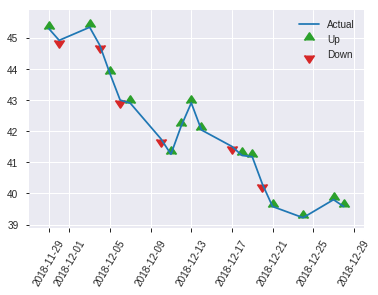


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21036800511243114
RMSE: 0.4586589202364118
LogLoss: 0.6028115453372844
Mean Per-Class Error: 0.3419723551302498
AUC: 0.69896331738437
pr_auc: 0.5792862650865053
Gini: 0.39792663476874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39814899492042644: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   84   0.5526   (84.0/152.0)
1      13   86   0.1313   (13.0/99.0)
Total  81   170  0.3865   (97.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398149     0.639405  127
max f2                       0.204696     0.792     186
max f0point5                 0.516743     0.575868  69
max accuracy                 0.516743     0.661355  69
max precision                0.821909     1         0
max recall                   0.204696     1         186
max specificity              0.821909     1         0
max absolute_mcc             0.398149     0.330397  127
max min_per_class_accuracy   0.502445     0.646465  74
max mean_per_class_accuracy  0.398149     0.658028  127

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 44.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.818835           2.53535   2.53535            1                0.820817  1                           0.820817            0.030303        0.030303                   153.535   153.535
    2        0.0239044                   0.794963           1.69024   2.11279            0.666667         0.803893  0.833333                    0.812355            0.020202        0.0505051                  69.0236   111.279
    3        0.0318725                   0.718468           2.53535   2.21843            1                0.740942  0.875                       0.794502            0.020202        0.0707071                  153.535   121.843
    4        0.0438247                   0.669811           1.69024   2.07438            0.666667         0.690967  0.818182                    0.766265            0.020202        0.0909091                  69.0236   107.438
    5        0.0517928                   0.651364           1.26768   1.95027            0.5              0.659851  0.769231                    0.749894            0.010101        0.10101                    26.7677   95.0272
    6        0.103586                    0.596013           1.56022   1.75524            0.615385         0.61933   0.692308                    0.684612            0.0808081       0.181818                   56.0218   75.5245
    7        0.151394                    0.567359           1.26768   1.60128            0.5              0.578701  0.631579                    0.651166            0.0606061       0.242424                   26.7677   60.1276
    8        0.203187                    0.543991           0.780109  1.39196            0.307692         0.553972  0.54902                     0.626391            0.040404        0.282828                   -21.9891  39.1959
    9        0.410359                    0.531428           1.41395   1.40306            0.557692         0.532303  0.553398                    0.57889             0.292929        0.575758                   41.3947   40.306
    10       0.501992                    0.48834            1.10233   1.34816            0.434783         0.508821  0.531746                    0.5661              0.10101         0.676768                   10.2328   34.8164
    11       0.601594                    0.433645           1.01414   1.29286            0.4              0.466302  0.509934                    0.549577            0.10101         0.777778                   1.41414   29.2862
    12       0.701195                    0.384726           0.912727  1.23887            0.36             0.408203  0.488636                    0.529496            0.0909091       0.868687                   -8.72727  23.8866
    13       0.800797                    0.326527           0.608485  1.16046            0.24             0.357271  0.457711                    0.508075            0.0606061       0.929293                   -39.1515  16.046
    14       0.900398                    0.232422           0.608485  1.0994             0.24             0.283806  0.433628                    0.483266            0.0606061       0.989899                   -39.1515  9.94011
    15       1                           0.00503624         0.101414  1                  0.04             0.119026  0.394422                    0.446987            0.010101        1                          -89.8586  0

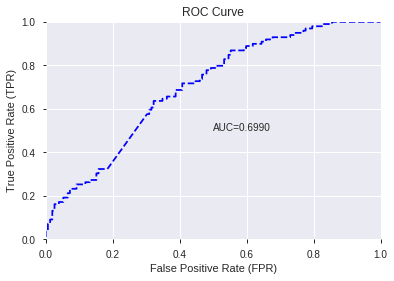

This function is available for GLM models only


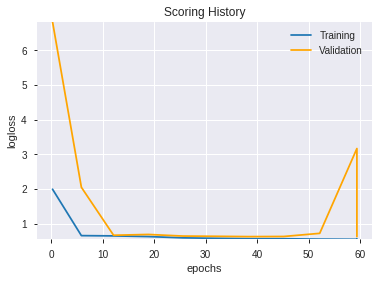

--2019-08-27 15:54:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_152624_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_152624_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_155432_model_9  0.706340  0.618761              0.359350  0.464629  0.215880
1  DeepLearning_grid_1_AutoML_20190827_155432_model_6  0.697634  0.653656              0.346657  0.479230  0.229662
2  DeepLearning_grid_1_AutoML_20190827_155432_model_8  0.689926  0.706638              0.415171  0.498891  0.248892
3  DeepLearning_grid_1_AutoML_20190827_155432_model_5  0.662945  0.715012              0.396365  0.509173  0.259257
4  DeepLearning_grid_1_AutoML_20190827_155432_model_3  0.661151  0.798296              0.434908  0.525586  0.276240
5  DeepLearning_grid_1_AutoML_20190827_155432_model_2  0.659556  0.785671              0.447834  0.507412  0.257467
6               DeepLearning_1_AutoML_20190827_155432  0.636031  0.677761              0.460759  0.488860  0.238985
7  DeepLearning_grid_1_AutoML_20190827_155432_model_4  0.626130  1.111659              0.462287  0.602858  0.363438
8  DeepLearning_grid_1_AutoML_20190827_155432_model_7  0.614367  0.778456              0.444777  0.521506  0.271968
9  DeepLearning_grid_1_AutoML_20190827_155432_model_1  0.610181  1.717071              0.413510  0.637333  0.406193

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.051147
1         CDLSHORTLINE             0.676872           0.676872    0.034620
2   CDLCLOSINGMARUBOZU             0.570305           0.570305    0.029169
3          CDLLONGLINE             0.559495           0.559495    0.028616
4                  SUB             0.549227           0.549227    0.028091
5       CDLEVENINGSTAR             0.473108           0.473108    0.024198
6         CDLENGULFING             0.470469           0.470469    0.024063
7         HT_TRENDMODE             0.451135           0.451135    0.023074
8               SAREXT             0.450165           0.450165    0.023024
9            CORREL_12             0.446045           0.446045    0.022814
10              TRANGE             0.444182           0.444182    0.022718
11         CDLBELTHOLD             0.434482           0.434482    0.022222
12                 DIV             0.433166           0.433166    0.022155
13   CDLDARKCLOUDCOVER             0.418799           0.418799    0.021420
14       days_in_month             0.387275           0.387275    0.019808
15                 TAN             0.376490           0.376490    0.019256
16           CORREL_24             0.373767           0.373767    0.019117
17   CDLLONGLEGGEDDOJI             0.371951           0.371951    0.019024
18             CDLDOJI             0.371528           0.371528    0.019002
19                 SIN             0.370931           0.370931    0.018972
20           CORREL_14             0.365645           0.365645    0.018701
21               month             0.365483           0.365483    0.018693
22              ULTOSC             0.364925           0.364925    0.018665
23         CDLMARUBOZU             0.364912           0.364912    0.018664
24               DX_30             0.363432           0.363432    0.018588
25                  AD             0.362314           0.362314    0.018531
26        weekday_name             0.361309           0.361309    0.018480
27         STOCH_slowd             0.358179           0.358179    0.018320
28               DX_20             0.354484           0.354484    0.018131
29              Volume             0.350146           0.350146    0.017909
30          AROONOSC_8             0.348765           0.348765    0.017838
31           CORREL_20             0.343498           0.343498    0.017569
32               DX_24             0.337174           0.337174    0.017245
33      STOCHRSI_fastk             0.332955           0.332955    0.017030
34                 COS             0.331062           0.331062    0.016933
35               ADOSC             0.326684           0.326684    0.016709
36      STOCHRSI_fastd             0.323951           0.323951    0.016569
37              ADX_24             0.321297           0.321297    0.016433
38        STOCHF_fastk             0.321221           0.321221    0.016429
39         aroondown_8             0.319941           0.319941    0.016364
40                DX_8             0.316835           0.316835    0.016205
41            WILLR_30             0.313981           0.313981    0.016059
42            WILLR_24             0.310102           0.310102    0.015861
43              ADX_20             0.309980           0.309980    0.015854
44            WILLR_20             0.302816           0.302816    0.015488
45                 day             0.302719           0.302719    0.015483
46            WILLR_12             0.290215           0.290215    0.014844
47             WILLR_8             0.289911           0.289911    0.014828
48             ADXR_14             0.286842           0.286842    0.014671
49            WILLR_14             0.281490           0.281490    0.014397

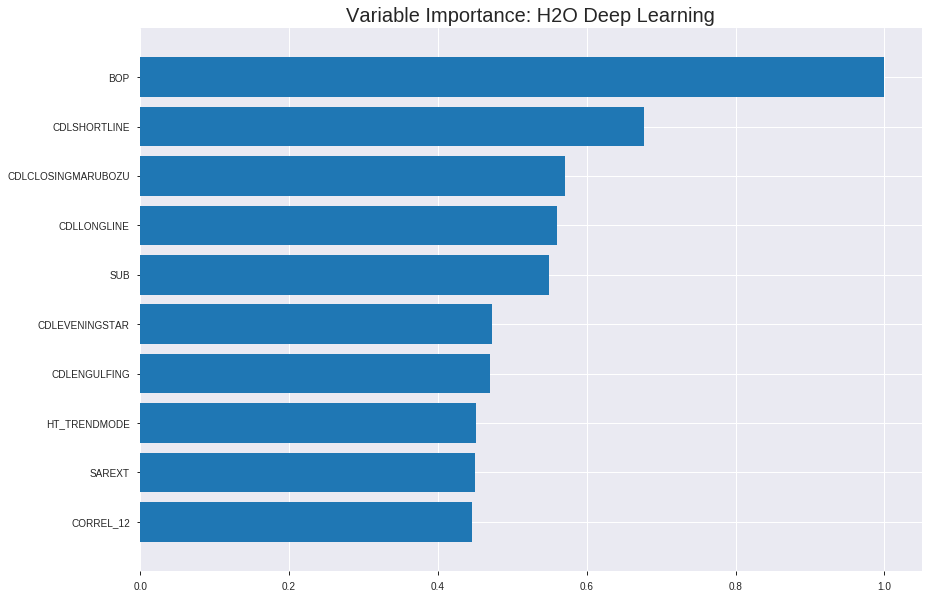

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_155432_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18958280534311367
RMSE: 0.4354110762751835
LogLoss: 0.5581133238197287
Mean Per-Class Error: 0.28820875701433457
AUC: 0.7837495280378091
pr_auc: 0.7772582803938157
Gini: 0.5674990560756181
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42753129296551845: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      501  362   0.4195   (362.0/863.0)
1      143  747   0.1607   (143.0/890.0)
Total  644  1109  0.2881   (505.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427531     0.747374  231
max f2                       0.178656     0.856664  338
max f0point5                 0.525873     0.716939  175
max accuracy                 0.463837     0.713063  215
max precision                0.952335     1         0
max recall                   0.0661552    1         392
max specificity              0.952335     1         0
max absolute_mcc             0.431129     0.43598   230
max min_per_class_accuracy   0.505966     0.707865  189
max mean_per_class_accuracy  0.463837     0.711791  215

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 49.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.917746           1.96966   1.96966            1                0.933853   1                           0.933853            0.0202247       0.0202247                  96.9663    96.9663
    2        0.0205362                   0.888422           1.96966   1.96966            1                0.897156   1                           0.915504            0.0202247       0.0404494                  96.9663    96.9663
    3        0.0302339                   0.871327           1.62208   1.85817            0.823529         0.878429   0.943396                    0.903612            0.0157303       0.0561798                  62.2075    85.8173
    4        0.040502                    0.860807           1.75081   1.83095            0.888889         0.865522   0.929577                    0.893956            0.0179775       0.0741573                  75.0811    83.0954
    5        0.0501997                   0.850041           1.8538    1.83537            0.941176         0.856342   0.931818                    0.886689            0.0179775       0.0921348                  85.38      83.5368
    6        0.100399                    0.814349           1.65631   1.74584            0.840909         0.831373   0.886364                    0.859031            0.0831461       0.175281                   65.6307    74.5838
    7        0.150029                    0.774128           1.56215   1.68507            0.793103         0.794145   0.855513                    0.837567            0.0775281       0.252809                   56.2146    68.5073
    8        0.200228                    0.722816           1.49963   1.63858            0.761364         0.746558   0.831909                    0.81475             0.0752809       0.32809                    49.963     63.858
    9        0.300057                    0.623238           1.4069    1.5615             0.714286         0.670146   0.792776                    0.76664             0.140449        0.468539                   40.6902    56.1501
    10       0.399886                    0.548854           1.20431   1.47233            0.611429         0.581444   0.747504                    0.720407            0.120225        0.588764                   20.4308    47.233
    11       0.500285                    0.505965           1.16389   1.41043            0.590909         0.525429   0.716078                    0.681278            0.116854        0.705618                   16.3892    41.0431
    12       0.600114                    0.454846           0.990459  1.34057            0.502857         0.482294   0.680608                    0.648177            0.0988764       0.804494                   -0.954093  34.0569
    13       0.699943                    0.376413           0.77661   1.26013            0.394286         0.416078   0.639772                    0.615074            0.0775281       0.882022                   -22.339    26.0135
    14       0.799772                    0.258465           0.641547  1.18292            0.325714         0.32196    0.600571                    0.578487            0.0640449       0.946067                   -35.8453   18.2922
    15       0.899601                    0.138991           0.393933  1.09537            0.2              0.19555    0.556119                    0.535993            0.0393258       0.985393                   -60.6067   9.53674
    16       1                           0.0409958          0.145486  1                  0.0738636        0.0990976  0.507701    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20314600684680692
RMSE: 0.45071721383458047
LogLoss: 0.5906626801583468
Mean Per-Class Error: 0.30714011331988855
AUC: 0.7471429943340057
pr_auc: 0.753051811952714
Gini: 0.4942859886680113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40195106728496643: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  134  0.5726   (134.0/234.0)
1      27   240  0.1011   (27.0/267.0)
Total  127  374  0.3214   (161.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401951     0.74883   290
max f2                       0.119903     0.86129   383
max f0point5                 0.502476     0.714841  202
max accuracy                 0.502476     0.692615  202
max precision                0.943818     1         0
max recall                   0.119903     1         383
max specificity              0.943818     1         0
max absolute_mcc             0.502476     0.384944  202
max min_per_class_accuracy   0.502476     0.689139  202
max mean_per_class_accuracy  0.502476     0.69286   202

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.917734           1.56367   1.56367            0.833333         0.930961  0.833333                    0.930961            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.904859           1.8764    1.70582            1                0.911558  0.909091                    0.922141            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.88396            1.8764    1.75913            1                0.886363  0.9375                      0.910961            0.0187266       0.0561798                  87.6404   75.9129
    4        0.0419162                   0.8582             1.50112   1.6977             0.8              0.863418  0.904762                    0.899641            0.0149813       0.071161                   50.1124   69.7699
    5        0.0518962                   0.845909           1.12584   1.58773            0.6              0.849491  0.846154                    0.889997            0.011236        0.082397                   12.5843   58.7727
    6        0.101796                    0.802539           1.8764    1.72924            1                0.820124  0.921569                    0.855745            0.093633        0.17603                    87.6404   72.9236
    7        0.151697                    0.767526           1.35101   1.60482            0.72             0.786721  0.855263                    0.83304             0.0674157       0.243446                   35.1011   60.482
    8        0.201597                    0.710529           1.50112   1.57915            0.8              0.74434   0.841584                    0.811085            0.0749064       0.318352                   50.1124   57.9152
    9        0.301397                    0.626159           1.16337   1.44148            0.62             0.664494  0.768212                    0.762545            0.116105        0.434457                   16.3371   44.1476
    10       0.401198                    0.552945           1.05079   1.34429            0.56             0.588746  0.716418                    0.719311            0.104869        0.539326                   5.07865   34.429
    11       0.500998                    0.509103           1.35101   1.34563            0.72             0.528994  0.717131                    0.681399            0.134831        0.674157                   35.1011   34.5629
    12       0.600798                    0.467815           0.938202  1.27795            0.5              0.48733   0.681063                    0.649162            0.093633        0.76779                    -6.17978  27.795
    13       0.700599                    0.423221           0.938202  1.22955            0.5              0.447442  0.655271                    0.620427            0.093633        0.861423                   -6.17978  22.9553
    14       0.800399                    0.353956           0.675506  1.16047            0.36             0.393128  0.618454                    0.592085            0.0674157       0.928839                   -32.4494  16.047
    15       0.9002                      0.185381           0.412809  1.07758            0.22             0.269803  0.574279                    0.556356            0.0411985       0.970037                   -58.7191  7.75804
    16       1                           0.0611155          0.300225  1                  0.16             0.131635  0.532934                    0.513968            0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:00:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:00:49  2 min 12.949 sec  486 obs/sec       0.551626  1             967        0.540841         0.970288            -0.170312      0.73368         0.717595           1.96966          0.369652                         0.540004           0.969758              -0.171501        0.731858          0.72861              1.56367            0.347305
    2019-08-27 16:00:59  2 min 23.022 sec  774 obs/sec       4.90074   9             8591       0.449284         0.58738             0.192383       0.762345        0.760352           1.96966          0.326298                         0.455774           0.602038              0.165461         0.745326          0.750233             1.56367            0.323353
    2019-08-27 16:01:09  2 min 33.186 sec  937 obs/sec       10.8477   20            19016      0.451197         0.592292            0.18549        0.764608        0.758811           1.96966          0.322305                         0.461761           0.615706              0.143389         0.741101          0.75112              1.56367            0.323353
    2019-08-27 16:01:20  2 min 43.491 sec  1061 obs/sec      17.943    33            31454      0.444082         0.579719            0.210976       0.77271         0.764916           1.96966          0.322875                         0.451839           0.59456               0.179807         0.747231          0.762126             1.56367            0.335329
    2019-08-27 16:01:30  2 min 53.562 sec  1157 obs/sec      25.5967   47            44871      0.443805         0.578233            0.21196        0.778133        0.77211            1.96966          0.300057                         0.454056           0.598822              0.171737         0.748463          0.756311             1.56367            0.339321
    2019-08-27 16:01:39  3 min  3.385 sec  1245 obs/sec      33.818    62            59283      0.435411         0.558113            0.241489       0.78375         0.777258           1.96966          0.288078                         0.450717           0.590663              0.183875         0.747143          0.753052             1.56367            0.321357
    2019-08-27 16:01:49  3 min 13.212 sec  1317 obs/sec      42.4404   78            74398      0.433704         0.557299            0.247427       0.793571        0.787036           1.96966          0.287507                         0.452612           0.597625              0.176998         0.747791          0.749708             1.25094            0.321357
    2019-08-27 16:01:50  3 min 14.196 sec  1316 obs/sec      42.4404   78            74398      0.435411         0.558113            0.241489       0.78375         0.777258           1.96966          0.288078                         0.450717           0.590663              0.183875         0.747143          0.753052             1.56367            0.321357

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.05114655678051054
CDLSHORTLINE        0.6768715381622314     0.6768715381622314   0.03461964855972608
CDLCLOSINGMARUBOZU  0.5703048706054688     0.5703048706054688   0.029169130446624326
CDLLONGLINE         0.5594954490661621     0.5594954490661621   0.028616265754099705
SUB                 0.5492268800735474     0.5492268800735474   0.028091063807064342
---                 ---                    ---                  ---
day                 0.3027189075946808     0.3027189075946808   0.015483029795825465
WILLR_12            0.2902151942253113     0.2902151942253113   0.014843507910011778
WILLR_8             0.2899113893508911     0.2899113893508911   0.014827969336752051
ADXR_14             0.28684213757514954    0.28684213757514954  0.014670987676530401
WILLR_14            0.281490296125412      0.281490296125412    0.01439725941394111


See the whole table with table.as_data_frame()


('accuracy', 0.6932270916334662)

('F1', 0.6141732283464566)

('auc', 0.7063397129186603)

('logloss', 0.6187611681428488)

('mean_per_class_error', 0.3290138224348751)

('rmse', 0.4646290270602944)

('mse', 0.21588013278699578)

deeplearning prediction progress: |███████████████████████████████████████| 100%


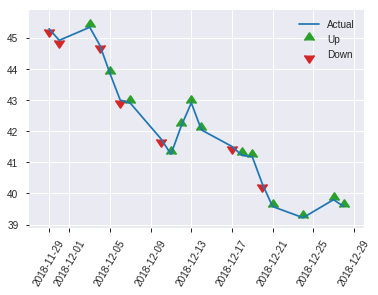


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21588013278699578
RMSE: 0.4646290270602944
LogLoss: 0.6187611681428488
Mean Per-Class Error: 0.3290138224348751
AUC: 0.7063397129186603
pr_auc: 0.606348579575898
Gini: 0.41267942583732053
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44416291914898787: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   77   0.5066   (77.0/152.0)
1      21   78   0.2121   (21.0/99.0)
Total  96   155  0.3904   (98.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444163     0.614173  154
max f2                       0.183499     0.785714  233
max f0point5                 0.518969     0.610022  89
max accuracy                 0.518969     0.693227  89
max precision                0.916999     1         0
max recall                   0.183499     1         233
max specificity              0.916999     1         0
max absolute_mcc             0.518969     0.348495  89
max min_per_class_accuracy   0.50227      0.636364  113
max mean_per_class_accuracy  0.518969     0.670986  89

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 46.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.87829            2.53535   2.53535            1                0.901304  1                           0.901304            0.030303        0.030303                   153.535   153.535
    2        0.0239044                   0.861406           1.69024   2.11279            0.666667         0.869168  0.833333                    0.885236            0.020202        0.0505051                  69.0236   111.279
    3        0.0318725                   0.857603           2.53535   2.21843            1                0.860971  0.875                       0.87917             0.020202        0.0707071                  153.535   121.843
    4        0.0438247                   0.837742           1.69024   2.07438            0.666667         0.845543  0.818182                    0.869999            0.020202        0.0909091                  69.0236   107.438
    5        0.0517928                   0.829745           2.53535   2.1453             1                0.830241  0.846154                    0.863882            0.020202        0.111111                   153.535   114.53
    6        0.103586                    0.720581           1.36519   1.75524            0.538462         0.77078   0.692308                    0.817331            0.0707071       0.181818                   36.519    75.5245
    7        0.151394                    0.613846           1.69024   1.73472            0.666667         0.656893  0.684211                    0.766666            0.0808081       0.262626                   69.0236   73.4716
    8        0.203187                    0.563262           1.56022   1.69024            0.615385         0.58711   0.666667                    0.720897            0.0808081       0.343434                   56.0218   69.0236
    9        0.302789                    0.530017           1.4198    1.60128            0.56             0.543794  0.631579                    0.662639            0.141414        0.484848                   41.9798   60.1276
    10       0.40239                     0.509887           1.21697   1.50615            0.48             0.520092  0.594059                    0.627355            0.121212        0.606061                   21.697    50.6151
    11       0.501992                    0.488399           0.608485  1.32804            0.24             0.500268  0.52381                     0.602139            0.0606061       0.666667                   -39.1515  32.8042
    12       0.601594                    0.45294            0.912727  1.25928            0.36             0.470972  0.496689                    0.580423            0.0909091       0.757576                   -8.72727  25.9282
    13       0.701195                    0.405327           0.608485  1.16684            0.24             0.43113   0.460227                    0.559217            0.0606061       0.818182                   -39.1515  16.6839
    14       0.800797                    0.308558           0.912727  1.13523            0.36             0.361645  0.447761                    0.534643            0.0909091       0.909091                   -8.72727  13.5233
    15       0.900398                    0.214935           0.608485  1.07696            0.24             0.252584  0.424779                    0.503442            0.0606061       0.969697                   -39.1515  7.69643
    16       1                           0.0800155          0.304242  1                  0.12             0.15305   0.394422                    0.468542          

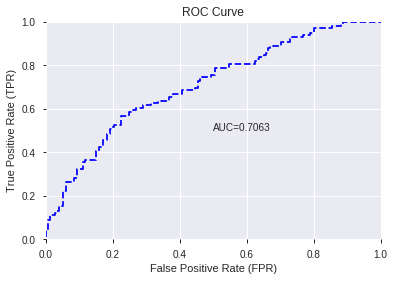

This function is available for GLM models only


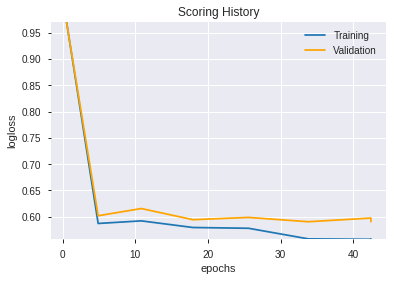

--2019-08-27 16:01:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_155432_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_155432_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLSHORTLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'CDLEVENINGSTAR',
 'CDLENGULFING',
 'HT_TRENDMODE',
 'SAREXT',
 'CORREL_12',
 'TRANGE',
 'CDLBELTHOLD',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'days_in_month',
 'TAN',
 'CORREL_24',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'SIN',
 'CORREL_14',
 'month',
 'ULTOSC',
 'CDLMARUBOZU',
 'DX_30',
 'AD',
 'weekday_name',
 'STOCH_slowd',
 'DX_20',
 'Volume',
 'AROONOSC_8',
 'CORREL_20',
 'DX_24',
 'STOCHRSI_fastk',
 'COS',
 'ADOSC',
 'STOCHRSI_fastd',
 'ADX_24',
 'STOCHF_fastk',
 'aroondown_8',
 'DX_8',
 'WILLR_30',
 'WILLR_24',
 'ADX_20',
 'WILLR_20',
 'day',
 'WILLR_12',
 'WILLR_8',
 'ADXR_14',
 'WILLR_14']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_160213_model_1  0.701754  0.628874              0.377691  0.468681  0.219662

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.768706           1.000000    0.186814
1                  SUB             0.340187           0.442545    0.082673
2            CORREL_12             0.181628           0.236277    0.044140
3                  DIV             0.162282           0.211110    0.039438
4         weekday_name             0.160682           0.209030    0.039050
5               SAREXT             0.128621           0.167321    0.031258
6          STOCH_slowd             0.109056           0.141870    0.026503
7               ULTOSC             0.108421           0.141044    0.026349
8          aroondown_8             0.103639           0.134822    0.025187
9              WILLR_8             0.100276           0.130447    0.024369
10           CORREL_14             0.096740           0.125847    0.023510
11        CDLENGULFING             0.095732           0.124536    0.023265
12           CORREL_24             0.093517           0.121656    0.022727
13                  AD             0.090225           0.117373    0.021927
14              ADX_24             0.089782           0.116796    0.021819
15              TRANGE             0.081323           0.105792    0.019763
16            WILLR_14             0.080904           0.105247    0.019662
17             ADXR_14             0.078826           0.102544    0.019157
18                 SIN             0.077429           0.100726    0.018817
19               ADOSC             0.076850           0.099974    0.018676
20              ADX_20             0.070590           0.091830    0.017155
21          AROONOSC_8             0.070399           0.091581    0.017109
22         CDLMARUBOZU             0.065269           0.084907    0.015862
23   CDLLONGLEGGEDDOJI             0.063121           0.082113    0.015340
24               DX_20             0.060607           0.078843    0.014729
25        CDLSHORTLINE             0.059999           0.078052    0.014581
26      STOCHRSI_fastd             0.052853           0.068755    0.012844
27         CDLBELTHOLD             0.050203           0.065309    0.012201
28        HT_TRENDMODE             0.049568           0.064482    0.012046
29               DX_24             0.047426           0.061696    0.011526
30  CDLCLOSINGMARUBOZU             0.045354           0.059000    0.011022
31      STOCHRSI_fastk             0.044518           0.057913    0.010819
32            WILLR_20             0.042484           0.055266    0.010325
33              Volume             0.038173           0.049658    0.009277
34      CDLEVENINGSTAR             0.036963           0.048085    0.008983
35            WILLR_24             0.029657           0.038580    0.007207
36               DX_30             0.028269           0.036775    0.006870
37   CDLDARKCLOUDCOVER             0.027809           0.036177    0.006758
38               month             0.026714           0.034752    0.006492
39                DX_8             0.025942           0.033747    0.006304
40       days_in_month             0.024867           0.032350    0.006043
41            WILLR_12             0.021022           0.027347    0.005109
42                 COS             0.021017           0.027341    0.005108
43        STOCHF_fastk             0.018219           0.023701    0.004428
44            WILLR_30             0.017868           0.023244    0.004342
45                 day             0.017050           0.022180    0.004144
46           CORREL_20             0.016987           0.022098    0.004128
47         CDLLONGLINE             0.015512           0.020180    0.003770
48                 TAN             0.000848           0.001103    0.000206
49             CDLDOJI             0.000696           0.000905    0.000169

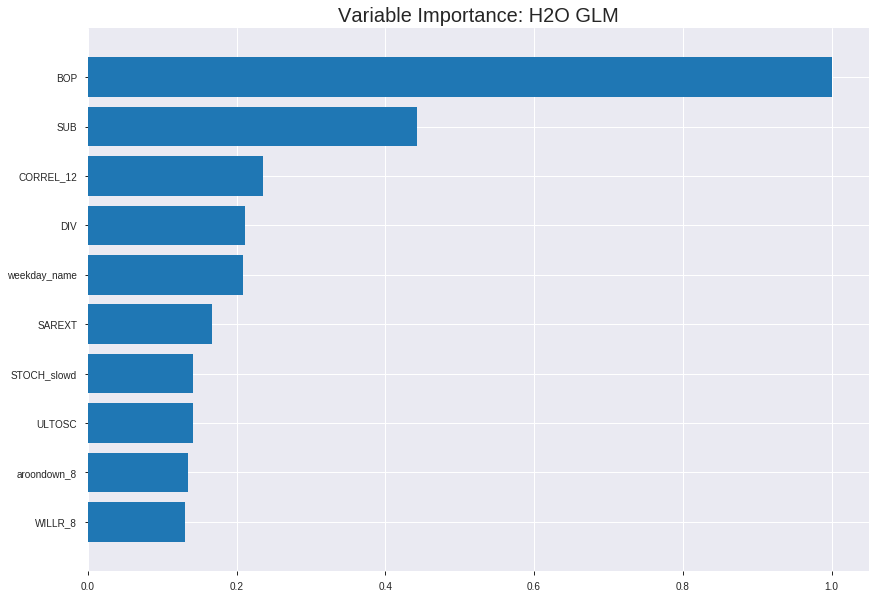

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_160213_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19383820975334992
RMSE: 0.44027060968607695
LogLoss: 0.5695428145810378
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.758140071244
Residual deviance: 1996.8171079211188
AIC: 2098.817107921119
AUC: 0.7738207455049669
pr_auc: 0.7704661272513659
Gini: 0.5476414910099339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37512342639300905: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      440  423   0.4902   (423.0/863.0)
1      117  773   0.1315   (117.0/890.0)
Total  557  1196  0.308    (540.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375123     0.741131  257
max f2                       0.205896     0.848337  339
max f0point5                 0.600034     0.708837  152
max accuracy                 0.477829     0.703936  209
max precision                0.938415     1         0
max recall                   0.0848372    1         389
max specificity              0.938415     1         0
max absolute_mcc             0.423788     0.411045  234
max min_per_class_accuracy   0.538807     0.688764  181
max mean_per_class_accuracy  0.477829     0.70289   209

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.885447           1.96966   1.96966            1                0.900691  1                           0.900691            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.870082           1.86024   1.91495            0.944444         0.877579  0.972222                    0.889135            0.0191011       0.0393258                  86.0237   91.495
    3        0.0302339                   0.856595           1.8538    1.89534            0.941176         0.862084  0.962264                    0.880458            0.0179775       0.0573034                  85.38     89.5336
    4        0.040502                    0.840958           1.86024   1.88644            0.944444         0.848526  0.957746                    0.872363            0.0191011       0.0764045                  86.0237   88.6438
    5        0.0501997                   0.829213           1.50621   1.81299            0.764706         0.836217  0.920455                    0.86538             0.0146067       0.0910112                  50.6213   81.2985
    6        0.100399                    0.786312           1.61154   1.71226            0.818182         0.804637  0.869318                    0.835009            0.0808989       0.17191                    61.1542   71.2264
    7        0.150029                    0.754681           1.63007   1.68507            0.827586         0.769246  0.855513                    0.813255            0.0808989       0.252809                   63.0066   68.5073
    8        0.200228                    0.725651           1.52201   1.64419            0.772727         0.740638  0.834758                    0.795049            0.0764045       0.329213                   52.2012   64.4192
    9        0.300057                    0.666158           1.36188   1.55027            0.691429         0.697047  0.787072                    0.762444            0.135955        0.465169                   36.1881   55.0267
    10       0.399886                    0.60859            1.20431   1.4639             0.611429         0.63691   0.743224                    0.731105            0.120225        0.585393                   20.4308   46.3901
    11       0.500285                    0.538464           1.01841   1.3745             0.517045         0.575622  0.697834                    0.699902            0.102247        0.68764                    1.84053   37.4497
    12       0.600114                    0.443284           1.0805    1.32559            0.548571         0.492847  0.673004                    0.665459            0.107865        0.795506                   8.05008   32.5591
    13       0.699943                    0.355111           0.821631  1.25371            0.417143         0.399291  0.636512                    0.627497            0.0820225       0.877528                   -17.8369  25.3714
    14       0.799772                    0.274933           0.596526  1.17168            0.302857         0.316838  0.594864                    0.58872             0.0595506       0.937079                   -40.3474  17.1683
    15       0.899601                    0.191986           0.405188  1.08662            0.205714         0.232719  0.55168                     0.549214            0.0404494       0.977528                   -59.4812  8.66244
    16       1                           0.0474245          0.223825  1                  0.113636         0.135735  0.507701                    0.507701          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20157569754114668
RMSE: 0.4489718226583342
LogLoss: 0.5885109768932965
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.6357161682504
Residual deviance: 589.687998847083
AIC: 691.687998847083
AUC: 0.7516885943852236
pr_auc: 0.7467997306061048
Gini: 0.5033771887704472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3043433639765982: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   142  0.6068   (142.0/234.0)
1      18   249  0.0674   (18.0/267.0)
Total  110  391  0.3194   (160.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304343     0.756839  305
max f2                       0.187906     0.860495  368
max f0point5                 0.591359     0.727595  168
max accuracy                 0.591359     0.692615  168
max precision                0.928232     1         0
max recall                   0.117618     1         388
max specificity              0.928232     1         0
max absolute_mcc             0.591359     0.399454  168
max min_per_class_accuracy   0.54685      0.681648  194
max mean_per_class_accuracy  0.591359     0.698142  168

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.887548           1.56367   1.56367            0.833333         0.907422  0.833333                    0.907422            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.872681           1.50112   1.53524            0.8              0.878561  0.818182                    0.894304            0.0149813       0.0337079                  50.1124   53.524
    3        0.0319361                   0.856935           1.50112   1.52458            0.8              0.863594  0.8125                      0.884707            0.0149813       0.0486891                  50.1124   52.4579
    4        0.0419162                   0.843309           1.8764    1.60835            1                0.847289  0.857143                    0.875798            0.0187266       0.0674157                  87.6404   60.8347
    5        0.0518962                   0.83289            1.8764    1.6599             1                0.836515  0.884615                    0.868243            0.0187266       0.0861423                  87.6404   65.9896
    6        0.101796                    0.79192            1.50112   1.58207            0.8              0.808731  0.843137                    0.839071            0.0749064       0.161049                   50.1124   58.2067
    7        0.151697                    0.761839           1.35101   1.50606            0.72             0.77351   0.802632                    0.817505            0.0674157       0.228464                   35.1011   50.6062
    8        0.201597                    0.736093           1.50112   1.50484            0.8              0.750569  0.80198                     0.800936            0.0749064       0.303371                   50.1124   50.4839
    9        0.301397                    0.671335           1.4636    1.49118            0.78             0.698275  0.794702                    0.766942            0.146067        0.449438                   46.3596   49.1182
    10       0.401198                    0.610482           1.27596   1.43764            0.68             0.643224  0.766169                    0.736167            0.127341        0.576779                   27.5955   43.7643
    11       0.500998                    0.54998            0.938202  1.33815            0.5              0.578497  0.713147                    0.704758            0.093633        0.670412                   -6.17978  33.8153
    12       0.600798                    0.462397           0.78809   1.24678            0.42             0.494706  0.664452                    0.669866            0.0786517       0.749064                   -21.191   24.678
    13       0.700599                    0.376794           1.01326   1.21352            0.54             0.422298  0.646724                    0.6346              0.101124        0.850187                   1.32584   21.3515
    14       0.800399                    0.289296           0.863146  1.16983            0.46             0.331738  0.623441                    0.596837            0.0861423       0.93633                    -13.6854  16.9828
    15       0.9002                      0.216776           0.375281  1.08174            0.2              0.256072  0.576497                    0.559058            0.0374532       0.973783                   -62.4719  8.1741
    16       1                           0.0827738          0.262697  1                  0.14             0.154944  0.532934                    0.518727            0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 16:02:14  0.000 sec   2            .22E2     50            1.369286451383421   1.3689664393080818
     2019-08-27 16:02:14  0.014 sec   4            .14E2     51            1.3606167211812277  1.3609360891860507
     2019-08-27 16:02:14  0.026 sec   6            .84E1     51            1.3484951241588545  1.349708651817747
     2019-08-27 16:02:14  0.041 sec   8            .52E1     51            1.3324511041096696  1.3348451458200932
     2019-08-27 16:02:14  0.054 sec   10           .33E1     51            1.312526028549876   1.316377220795824
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 16:02:14  0.318 sec   34           .11E-1    51            1.135292959627974   1.1776463607634096
     2019-08-27 16:02:14  0.332 sec   36           .66E-2    51            1.132670885471178   1.1792077588301648
     2019-08-27 16:02:14  0.344 sec   38           .41E-2    51            1.1309464713680555  1.181218736369635
     2019-08-27 16:02:14  0.356 sec   40           .26E-2    51            1.1298475149199725  1.1833462195625135
     2019-08-27 16:02:14  0.370 sec   42           .16E-2    51            1.1291436101534074  1.1853274904611695


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.6206896551724137)

('auc', 0.7017543859649124)

('logloss', 0.6288741483186301)

('mean_per_class_error', 0.3355927698032961)

('rmse', 0.46868142210291364)

('mse', 0.2196622754244095)

glm prediction progress: |████████████████████████████████████████████████| 100%


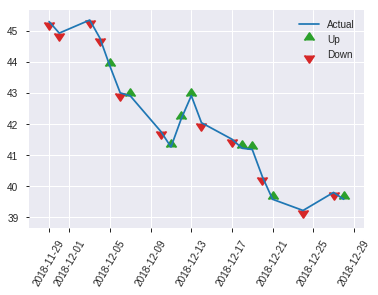


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2196622754244095
RMSE: 0.46868142210291364
LogLoss: 0.6288741483186301
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.6521945213129
Residual deviance: 315.6948224559523
AIC: 417.6948224559523
AUC: 0.7017543859649124
pr_auc: 0.574431370718296
Gini: 0.4035087719298247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29952332124071845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   101  0.6645   (101.0/152.0)
1      9    90   0.0909   (9.0/99.0)
Total  60   191  0.4382   (110.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299523     0.62069   190
max f2                       0.191266     0.784469  234
max f0point5                 0.576249     0.599572  91
max accuracy                 0.602251     0.685259  79
max precision                0.832305     0.75      11
max recall                   0.191266     1         234
max specificity              0.892901     0.993421  0
max absolute_mcc             0.576249     0.333502  91
max min_per_class_accuracy   0.504953     0.636364  116
max mean_per_class_accuracy  0.576249     0.664407  91

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.8648             1.69024   1.69024            0.666667         0.876418  0.666667                    0.876418            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.861441           1.69024   1.69024            0.666667         0.863219  0.666667                    0.869818            0.020202        0.040404                   69.0236   69.0236
    3        0.0318725                   0.856302           1.26768   1.5846             0.5              0.858689  0.625                       0.867036            0.010101        0.0505051                  26.7677   58.4596
    4        0.0438247                   0.836089           2.53535   1.84389            1                0.846191  0.727273                    0.861351            0.030303        0.0808081                  153.535   84.3893
    5        0.0517928                   0.812618           1.26768   1.75524            0.5              0.823918  0.692308                    0.855592            0.010101        0.0909091                  26.7677   75.5245
    6        0.103586                    0.758502           1.56022   1.65773            0.615385         0.777876  0.653846                    0.816734            0.0808081       0.171717                   56.0218   65.7731
    7        0.151394                    0.719692           1.69024   1.668              0.666667         0.733128  0.657895                    0.790332            0.0808081       0.252525                   69.0236   66.7996
    8        0.203187                    0.683795           1.56022   1.64052            0.615385         0.700265  0.647059                    0.767374            0.0808081       0.333333                   56.0218   64.0523
    9        0.302789                    0.607005           1.4198    1.56792            0.56             0.645592  0.618421                    0.727314            0.141414        0.474747                   41.9798   56.7916
    10       0.40239                     0.551604           1.11556   1.45595            0.44             0.582533  0.574257                    0.691477            0.111111        0.585859                   11.5556   45.5946
    11       0.501992                    0.48234            0.709899  1.30792            0.28             0.51619   0.515873                    0.656698            0.0707071       0.656566                   -29.0101  30.792
    12       0.601594                    0.394269           1.11556   1.27607            0.44             0.433564  0.503311                    0.619755            0.111111        0.767677                   11.5556   27.6072
    13       0.701195                    0.341807           0.709899  1.19565            0.28             0.363744  0.471591                    0.58339             0.0707071       0.838384                   -29.0101  19.565
    14       0.800797                    0.282206           0.912727  1.16046            0.36             0.305835  0.457711                    0.548868            0.0909091       0.929293                   -8.72727  16.046
    15       0.900398                    0.220221           0.405657  1.07696            0.16             0.253018  0.424779                    0.516141            0.040404        0.969697                   -59.4343  7.69643
    16       1                           0.0751808          0.304242  1                  0.12             0.160702  0.394422                    0.480739            

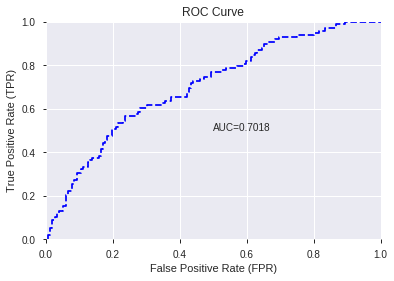

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


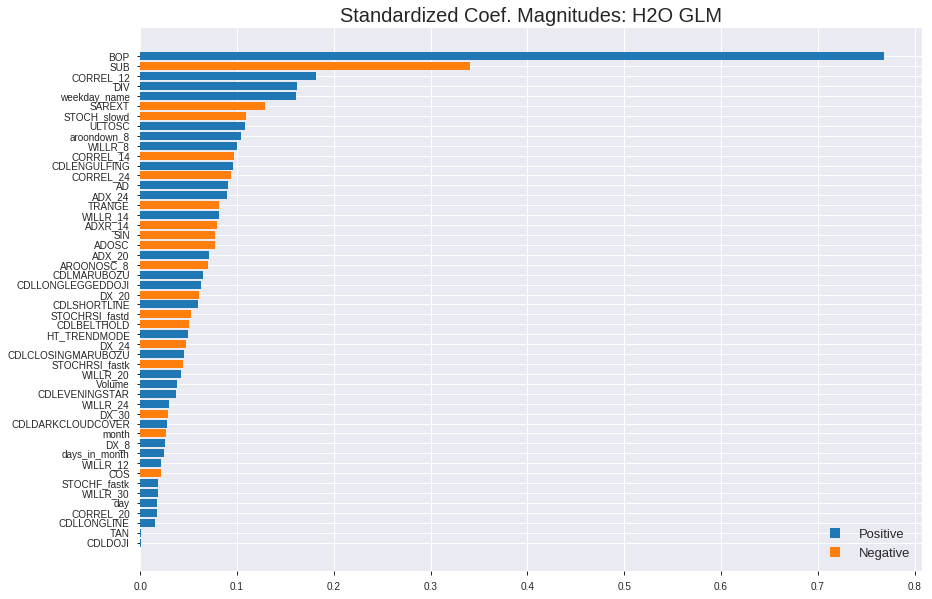

'log_likelihood'
--2019-08-27 16:02:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_160213_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_160213_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'CORREL_12',
 'DIV',
 'weekday_name',
 'SAREXT',
 'STOCH_slowd',
 'ULTOSC',
 'aroondown_8',
 'WILLR_8',
 'CORREL_14',
 'CDLENGULFING',
 'CORREL_24',
 'AD',
 'ADX_24',
 'TRANGE',
 'WILLR_14',
 'ADXR_14',
 'SIN',
 'ADOSC',
 'ADX_20',
 'AROONOSC_8',
 'CDLMARUBOZU',
 'CDLLONGLEGGEDDOJI',
 'DX_20',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'DX_24',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'WILLR_20',
 'Volume',
 'CDLEVENINGSTAR',
 'WILLR_24',
 'DX_30',
 'CDLDARKCLOUDCOVER',
 'month',
 'DX_8',
 'days_in_month',
 'WILLR_12',
 'COS',
 'STOCHF_fastk',
 'WILLR_30',
 'day',
 'CORREL_20',
 'CDLLONGLINE',
 'TAN',
 'CDLDOJI']

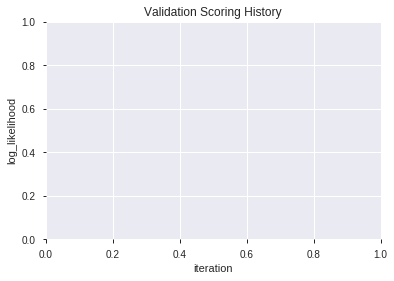

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_160235  0.708466  0.638485              0.347854  0.473534  0.224235
1  XGBoost_grid_1_AutoML_20190827_160235_model_4  0.708068  0.629141              0.363703  0.469076  0.220033
2               XGBoost_3_AutoML_20190827_160235  0.706473  0.638295              0.375698  0.474298  0.224959
3               XGBoost_1_AutoML_20190827_160235  0.692584  0.649028              0.371112  0.479013  0.229454
4  XGBoost_grid_1_AutoML_20190827_160235_model_5  0.687267  0.672417              0.374867  0.488614  0.238744
5  XGBoost_grid_1_AutoML_20190827_160235_model_2  0.679359  0.656107              0.354532  0.482205  0.232521
6  XGBoost_grid_1_AutoML_20190827_160235_model_1  0.678695  0.657530              0.374635  0.483514  0.233785
7  XGBoost_grid_1_AutoML_20190827_160235_model_6  0.673312  0.662072              0.362872  0.484312  0.234558
8  XGBoost_grid_1_AutoML_20190827_160235_model_3  0.667065  0.666739              0.377093  0.487719  0.237870
9  XGBoost_grid_1_AutoML_20190827_160235_model_7  0.664341  0.680931              0.395069  0.493123  0.243170

variable  relative_importance  scaled_importance  percentage
0              BOP          2016.542358           1.000000    0.274420
1     STOCHF_fastk           404.204193           0.200444    0.055006
2              SUB           332.167969           0.164722    0.045203
3   STOCHRSI_fastk           238.606506           0.118325    0.032471
4          WILLR_8           234.026123           0.116053    0.031847
5           TRANGE           210.115082           0.104196    0.028593
6   STOCHRSI_fastd           193.105408           0.095761    0.026279
7      STOCH_slowd           184.053391           0.091272    0.025047
8              TAN           179.461151           0.088994    0.024422
9         WILLR_20           172.849625           0.085716    0.023522
10    weekday_name           164.106628           0.081380    0.022332
11          SAREXT           162.610703           0.080638    0.022129
12             DIV           157.781525           0.078244    0.021472
13        WILLR_14           156.901154           0.077807    0.021352
14           DX_24           153.699097           0.076219    0.020916
15       CORREL_20           152.058990           0.075406    0.020693
16           DX_20           144.024353           0.071421    0.019600
17          ADX_24           141.066315           0.069955    0.019197
18             SIN           134.126709           0.066513    0.018253
19          ULTOSC           132.218124           0.065567    0.017993
20              AD           128.052124           0.063501    0.017426
21        WILLR_12           125.699066           0.062334    0.017106
22             COS           115.475830           0.057264    0.015714
23       CORREL_12           113.291801           0.056181    0.015417
24           DX_30           112.170883           0.055625    0.015265
25       CORREL_24           106.845062           0.052984    0.014540
26             day           104.618042           0.051880    0.014237
27           ADOSC           104.221375           0.051683    0.014183
28       CORREL_14            98.066589           0.048631    0.013345
29        WILLR_30            92.852448           0.046045    0.012636
30         ADXR_14            84.555702           0.041931    0.011507
31          ADX_20            80.427185           0.039884    0.010945
32     aroondown_8            70.733215           0.035076    0.009626
33            DX_8            70.372223           0.034897    0.009577
34      AROONOSC_8            62.663414           0.031075    0.008528
35          Volume            53.758869           0.026659    0.007316
36           month            53.376812           0.026469    0.007264
37        WILLR_24            45.437653           0.022532    0.006183
38     CDLLONGLINE            17.805962           0.008830    0.002423
39   days_in_month            17.711821           0.008783    0.002410
40    CDLSHORTLINE            16.011461           0.007940    0.002179
41    HT_TRENDMODE             6.459501           0.003203    0.000879
42         CDLDOJI             4.034752           0.002001    0.000549

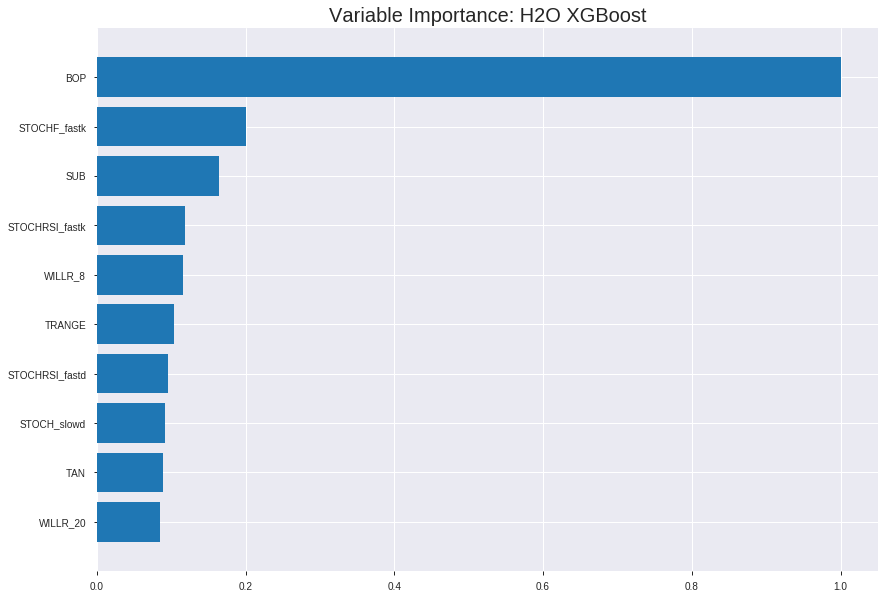

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_160235


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14522059843532853
RMSE: 0.3810782051434174
LogLoss: 0.45897220993750915
Mean Per-Class Error: 0.1878715481661828
AUC: 0.8948761180621558
pr_auc: 0.8982042277457161
Gini: 0.7897522361243117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4870515465736389: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      655  208  0.241    (208.0/863.0)
1      130  760  0.1461   (130.0/890.0)
Total  785  968  0.1928   (338.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487052     0.818084  209
max f2                       0.30937      0.887793  291
max f0point5                 0.592428     0.834209  159
max accuracy                 0.539532     0.811751  184
max precision                0.927003     1         0
max recall                   0.147969     1         368
max specificity              0.927003     1         0
max absolute_mcc             0.539532     0.624667  184
max min_per_class_accuracy   0.520063     0.807648  193
max mean_per_class_accuracy  0.539532     0.812128  184

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.88148            1.96966    1.96966            1                0.897254  1                           0.897254            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.874264           1.96966    1.96966            1                0.878034  1                           0.887644            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.866786           1.96966    1.96966            1                0.869626  1                           0.881864            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.859455           1.96966    1.96966            1                0.862711  1                           0.877009            0.0202247       0.0797753                  96.9663   96.9663
    5        0.0501997                   0.848856           1.96966    1.96966            1                0.853405  1                           0.872449            0.0191011       0.0988764                  96.9663   96.9663
    6        0.100399                    0.809729           1.9249     1.94728            0.977273         0.828136  0.988636                    0.850292            0.0966292       0.195506                   92.4898   94.728
    7        0.150029                    0.775722           1.83382    1.90975            0.931034         0.79324   0.969582                    0.83142             0.0910112       0.286517                   83.3824   90.9749
    8        0.200228                    0.741167           1.83537    1.8911             0.931818         0.760635  0.960114                    0.813673            0.0921348       0.378652                   83.5368   89.1101
    9        0.300057                    0.672564           1.65452    1.81239            0.84             0.706818  0.920152                    0.778122            0.165169        0.54382                    65.4517   81.2389
    10       0.399886                    0.603775           1.46318    1.72521            0.742857         0.641297  0.875892                    0.743965            0.146067        0.689888                   46.3178   72.5211
    11       0.500285                    0.524953           1.11913    1.60358            0.568182         0.563695  0.814139                    0.707788            0.11236         0.802247                   11.9127   60.358
    12       0.600114                    0.449743           0.810376   1.47163            0.411429         0.486763  0.747148                    0.67102             0.0808989       0.883146                   -18.9624  47.163
    13       0.699943                    0.353635           0.686568   1.35966            0.348571         0.403625  0.690302                    0.632883            0.0685393       0.951685                   -31.3432  35.9661
    14       0.799772                    0.255567           0.292636   1.22647            0.148571         0.303329  0.622682                    0.591748            0.0292135       0.980899                   -70.7364  22.6473
    15       0.899601                    0.173229           0.157573   1.10786            0.08             0.215006  0.56246                     0.549941            0.0157303       0.996629                   -84.2427  10.7857
    16       1                           0.0549382          0.0335738  1                  0.0170455        0.129966  0.507701                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1993551086437061
RMSE: 0.4464920028888604
LogLoss: 0.5833369299349388
Mean Per-Class Error: 0.29672044559685007
AUC: 0.756570312750088
pr_auc: 0.7574435551875186
Gini: 0.513140625500176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3536398410797119: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  132  0.5641   (132.0/234.0)
1      28   239  0.1049   (28.0/267.0)
Total  130  371  0.3194   (160.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35364      0.749216  288
max f2                       0.193364     0.862295  363
max f0point5                 0.556684     0.72549   192
max accuracy                 0.556684     0.702595  192
max precision                0.918503     1         0
max recall                   0.114824     1         396
max specificity              0.918503     1         0
max absolute_mcc             0.556684     0.405683  192
max min_per_class_accuracy   0.550072     0.696629  194
max mean_per_class_accuracy  0.556684     0.70328   192

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 53.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.882692           1.56367   1.56367            0.833333         0.89927   0.833333                    0.89927             0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.872818           1.8764    1.70582            1                0.877047  0.909091                    0.889169            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.86226            1.8764    1.75913            1                0.866882  0.9375                      0.882204            0.0187266       0.0561798                  87.6404   75.9129
    4        0.0419162                   0.855804           1.50112   1.6977             0.8              0.858086  0.904762                    0.876462            0.0149813       0.071161                   50.1124   69.7699
    5        0.0518962                   0.845881           1.50112   1.6599             0.8              0.850624  0.884615                    0.871493            0.0149813       0.0861423                  50.1124   65.9896
    6        0.101796                    0.812221           1.50112   1.58207            0.8              0.828202  0.843137                    0.850272            0.0749064       0.161049                   50.1124   58.2067
    7        0.151697                    0.773396           1.42607   1.53075            0.76             0.789955  0.815789                    0.830431            0.071161        0.23221                    42.6067   53.0751
    8        0.201597                    0.752652           1.42607   1.50484            0.76             0.763454  0.80198                     0.813852            0.071161        0.303371                   42.6067   50.4839
    9        0.301397                    0.694436           1.50112   1.50361            0.8              0.724526  0.801325                    0.784274            0.149813        0.453184                   50.1124   50.3609
    10       0.401198                    0.62982            1.2009    1.42831            0.64             0.655988  0.761194                    0.752362            0.11985         0.573034                   20.0899   42.8308
    11       0.500998                    0.556627           1.2009    1.38301            0.64             0.591603  0.737052                    0.720339            0.11985         0.692884                   20.0899   38.3007
    12       0.600798                    0.475338           0.675506  1.26548            0.36             0.51668   0.674419                    0.686508            0.0674157       0.7603                     -32.4494  26.5482
    13       0.700599                    0.405511           0.900674  1.21352            0.48             0.436831  0.646724                    0.650942            0.0898876       0.850187                   -9.93258  21.3515
    14       0.800399                    0.3094             0.825618  1.16515            0.44             0.349659  0.620948                    0.613375            0.082397        0.932584                   -17.4382  16.5149
    15       0.9002                      0.201417           0.450337  1.0859             0.24             0.259311  0.578714                    0.574122            0.0449438       0.977528                   -54.9663  8.59015
    16       1                           0.0863657          0.225169  1                  0.12             0.159704  0.532934                    0.532763          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:02:37  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-27 16:02:37  0.069 sec   5                  0.477657         0.64923             0.812669        0.801941           1.7727           0.279521                         0.482746           0.659061              0.74864           0.752612             1.8764             0.331337
    2019-08-27 16:02:37  0.119 sec   10                 0.458715         0.6127              0.832088        0.829498           1.96966          0.270394                         0.471462           0.636865              0.746759          0.749669             1.8764             0.345309
    2019-08-27 16:02:37  0.176 sec   15                 0.443611         0.583493            0.840259        0.841914           1.96966          0.261266                         0.462178           0.618398              0.751056          0.753137             1.8764             0.331337
    2019-08-27 16:02:37  0.229 sec   20                 0.432658         0.562031            0.845934        0.846966           1.96966          0.254421                         0.456683           0.607155              0.753761          0.750521             1.56367            0.295409
    2019-08-27 16:02:38  0.282 sec   25                 0.423483         0.543678            0.851757        0.854403           1.96966          0.25328                          0.452767           0.598788              0.75589           0.75569              1.56367            0.333333
    2019-08-27 16:02:38  0.343 sec   30                 0.416004         0.528354            0.855407        0.859528           1.96966          0.251569                         0.449823           0.592477              0.757715          0.753881             1.56367            0.317365
    2019-08-27 16:02:38  0.399 sec   35                 0.409711         0.515601            0.861633        0.866384           1.96966          0.252139                         0.449269           0.59084               0.754706          0.751495             1.56367            0.313373
    2019-08-27 16:02:38  0.459 sec   40                 0.40389          0.504161            0.869181        0.874611           1.96966          0.250428                         0.448053           0.587904              0.75609           0.757973             1.8764             0.311377
    2019-08-27 16:02:38  0.518 sec   45                 0.39887          0.493741            0.873505        0.879405           1.96966          0.236737                         0.447739           0.586901              0.75557           0.758585             1.8764             0.317365
    2019-08-27 16:02:38  0.581 sec   50                 0.394303         0.484375            0.878413        0.884789           1.96966          0.232744                         0.446174           0.583429              0.758787          0.760998             1.8764             0.323353
    2019-08-27 16:02:38  0.646 sec   55                 0.389662         0.475123            0.883284        0.887513           1.96966          0.222476                         0.445943           0.582261              0.758739          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2016.5423583984375     1.0                    0.2744204671927109
STOCHF_fastk    404.2041931152344      0.20044418676940576    0.055005987379323336
SUB             332.16796875           0.1647215429750813     0.04520296277992602
STOCHRSI_fastk  238.60650634765625     0.11832456945618561    0.032470683630542826
WILLR_8         234.026123046875       0.1160531649990935     0.031847363758244006
---             ---                    ---                    ---
CDLLONGLINE     17.80596160888672      0.008829946732697661   0.0024231181076736436
days_in_month   17.711820602416992     0.008783262364240112   0.0024103069614709264
CDLSHORTLINE    16.01146125793457      0.007940056994712012   0.0021789141500256222
HT_TRENDMODE    6.459501266479492      0.0032032559294264996  0.0008790389886910414
CDLDOJI         4.034752368927002      0.002000826985916354   0.0005490678762469495


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.6433566433566434)

('auc', 0.7084662413609782)

('logloss', 0.638485252103263)

('mean_per_class_error', 0.34220494417862835)

('rmse', 0.473534295610618)

('mse', 0.22423472911944417)

xgboost prediction progress: |████████████████████████████████████████████| 100%


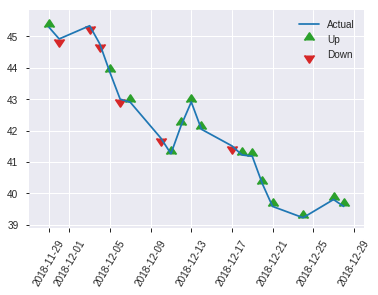


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22423472911944417
RMSE: 0.473534295610618
LogLoss: 0.638485252103263
Mean Per-Class Error: 0.34220494417862835
AUC: 0.7084662413609782
pr_auc: 0.599310609723768
Gini: 0.4169324827219565
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38370534777641296: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   95   0.625    (95.0/152.0)
1      7    92   0.0707   (7.0/99.0)
Total  64   187  0.4064   (102.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383705     0.643357  186
max f2                       0.281126     0.793269  227
max f0point5                 0.636989     0.590361  78
max accuracy                 0.636989     0.681275  78
max precision                0.902444     1         0
max recall                   0.281126     1         227
max specificity              0.902444     1         0
max absolute_mcc             0.383705     0.341209  186
max min_per_class_accuracy   0.541341     0.611842  119
max mean_per_class_accuracy  0.44105      0.657795  164

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 52.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.87726            2.53535   2.53535            1                0.889117  1                           0.889117            0.030303        0.030303                   153.535   153.535
    2        0.0239044                   0.841525           2.53535   2.53535            1                0.85782   1                           0.873468            0.030303        0.0606061                  153.535   153.535
    3        0.0318725                   0.829094           0         1.90152            0                0.835281  0.75                        0.863921            0               0.0606061                  -100      90.1515
    4        0.0438247                   0.816661           2.53535   2.07438            1                0.819684  0.818182                    0.851857            0.030303        0.0909091                  153.535   107.438
    5        0.0517928                   0.811462           1.26768   1.95027            0.5              0.815392  0.769231                    0.846247            0.010101        0.10101                    26.7677   95.0272
    6        0.103586                    0.776193           1.56022   1.75524            0.615385         0.793083  0.692308                    0.819665            0.0808081       0.181818                   56.0218   75.5245
    7        0.151394                    0.736151           1.26768   1.60128            0.5              0.75459   0.631579                    0.799115            0.0606061       0.242424                   26.7677   60.1276
    8        0.203187                    0.69133            1.36519   1.5411             0.538462         0.705098  0.607843                    0.77515             0.0707071       0.313131                   36.519    54.1097
    9        0.302789                    0.646886           1.52121   1.53456            0.6              0.668502  0.605263                    0.740068            0.151515        0.464646                   52.1212   53.4556
    10       0.40239                     0.572507           0.709899  1.33043            0.28             0.602882  0.524752                    0.706111            0.0707071       0.535354                   -29.0101  33.0433
    11       0.501992                    0.530554           1.31838   1.32804            0.52             0.547335  0.52381                     0.674608            0.131313        0.666667                   31.8384   32.8042
    12       0.601594                    0.474691           1.21697   1.30965            0.48             0.494452  0.516556                    0.644781            0.121212        0.787879                   21.697    30.9653
    13       0.701195                    0.410368           0.912727  1.25327            0.36             0.44478   0.494318                    0.616372            0.0909091       0.878788                   -8.72727  25.3271
    14       0.800797                    0.343707           0.608485  1.17307            0.24             0.377193  0.462687                    0.586623            0.0606061       0.939394                   -39.1515  17.3074
    15       0.900398                    0.283206           0.507071  1.0994             0.2              0.318358  0.433628                    0.556948            0.0505051       0.989899                   -49.2929  9.94011
    16       1                           0.147              0.101414  1                  0.04             0.232756  0.394422                    0.524658         

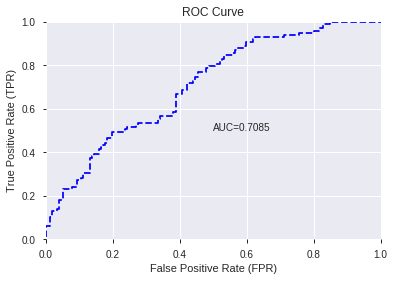

This function is available for GLM models only


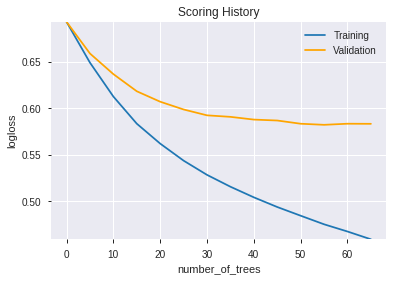

--2019-08-27 16:02:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


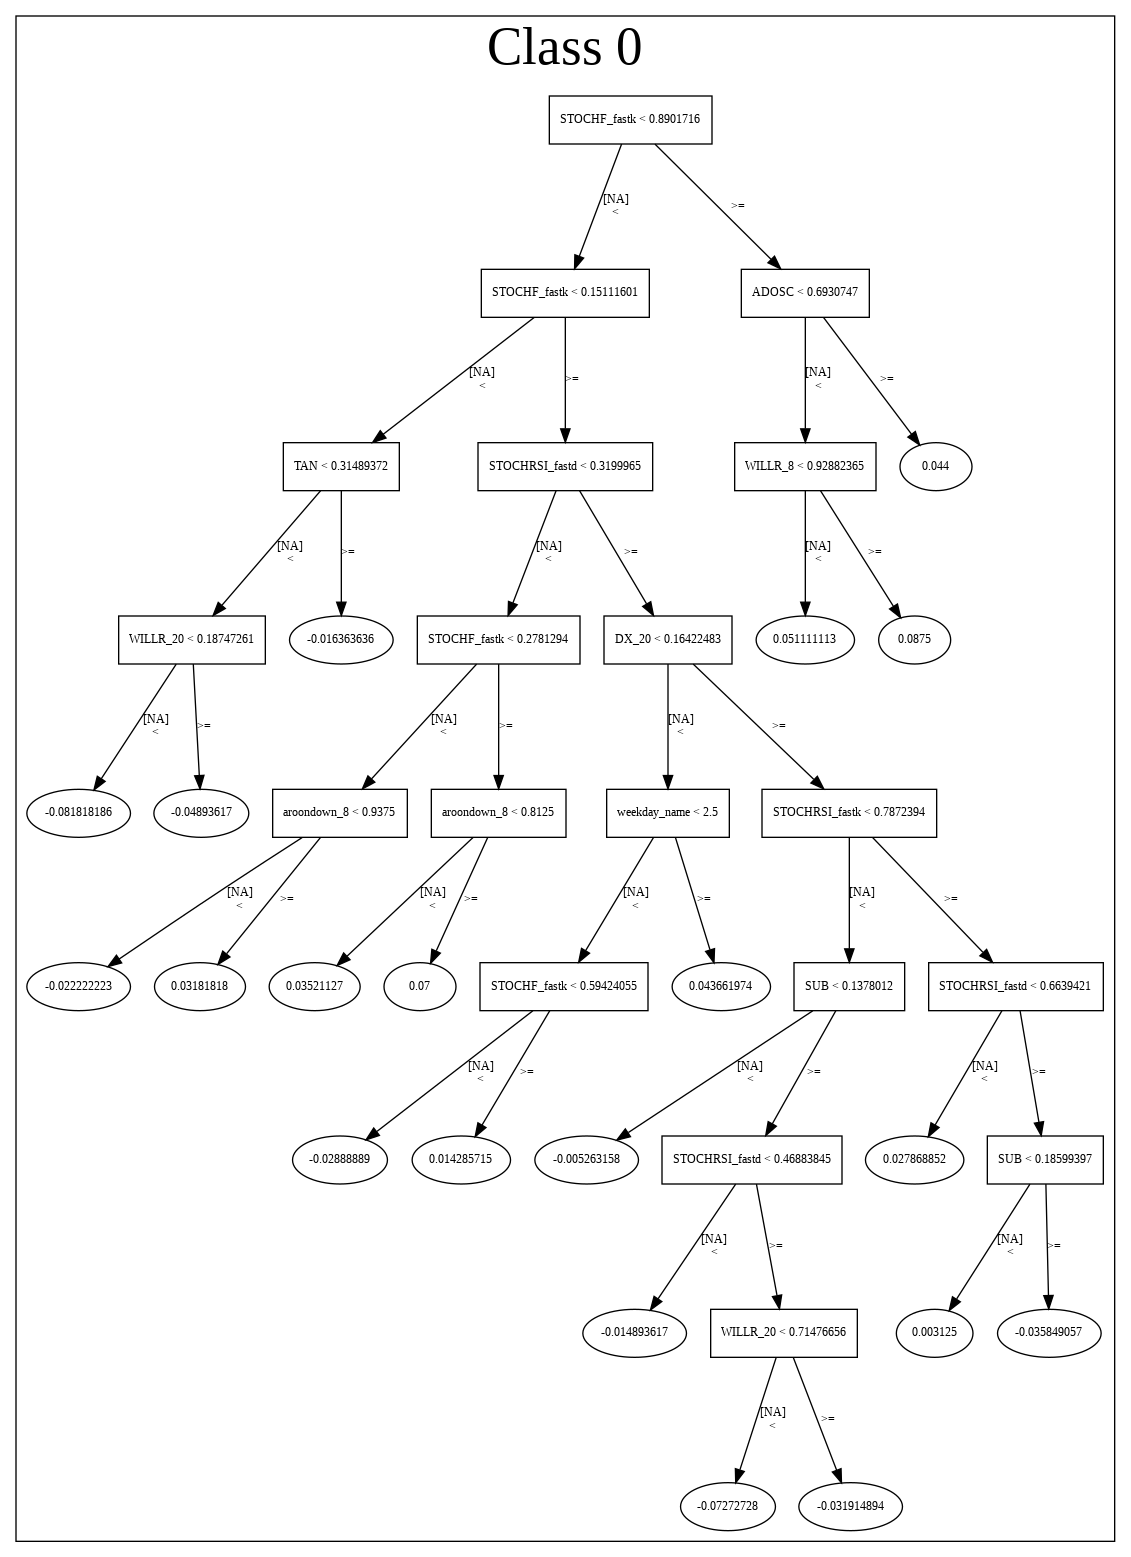

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_160235',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_160235',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_b362',
   'type

['BOP',
 'STOCHF_fastk',
 'SUB',
 'STOCHRSI_fastk',
 'WILLR_8',
 'TRANGE',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'TAN',
 'WILLR_20',
 'weekday_name',
 'SAREXT',
 'DIV',
 'WILLR_14',
 'DX_24',
 'CORREL_20',
 'DX_20',
 'ADX_24',
 'SIN',
 'ULTOSC',
 'AD',
 'WILLR_12',
 'COS',
 'CORREL_12',
 'DX_30',
 'CORREL_24',
 'day',
 'ADOSC',
 'CORREL_14',
 'WILLR_30',
 'ADXR_14',
 'ADX_20',
 'aroondown_8',
 'DX_8',
 'AROONOSC_8',
 'Volume',
 'month',
 'WILLR_24',
 'CDLLONGLINE',
 'days_in_month',
 'CDLSHORTLINE',
 'HT_TRENDMODE',
 'CDLDOJI']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_160307_model_1  0.699761  0.689689              0.357955  0.48747  0.237627

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.050875           1.000000    0.039365
1                 CDLLONGLINE             0.028873           0.567530    0.022341
2          CDLCLOSINGMARUBOZU             0.023826           0.468332    0.018436
3                STOCHF_fastk             0.022163           0.435628    0.017148
4                 CDLBELTHOLD             0.020634           0.405593    0.015966
...                       ...                  ...                ...         ...
1037  BBANDS_lowerband_24_6_3             0.000006           0.000124    0.000005
1038                  MA_14_1             0.000004           0.000085    0.000003
1039  BBANDS_upperband_14_0_5             0.000004           0.000085    0.000003
1040  BBANDS_upperband_12_1_2             0.000002           0.000048    0.000002
1041  BBANDS_lowerband_14_2_2             0.000002           0.000036    0.000001

[1042 rows x 4 columns]

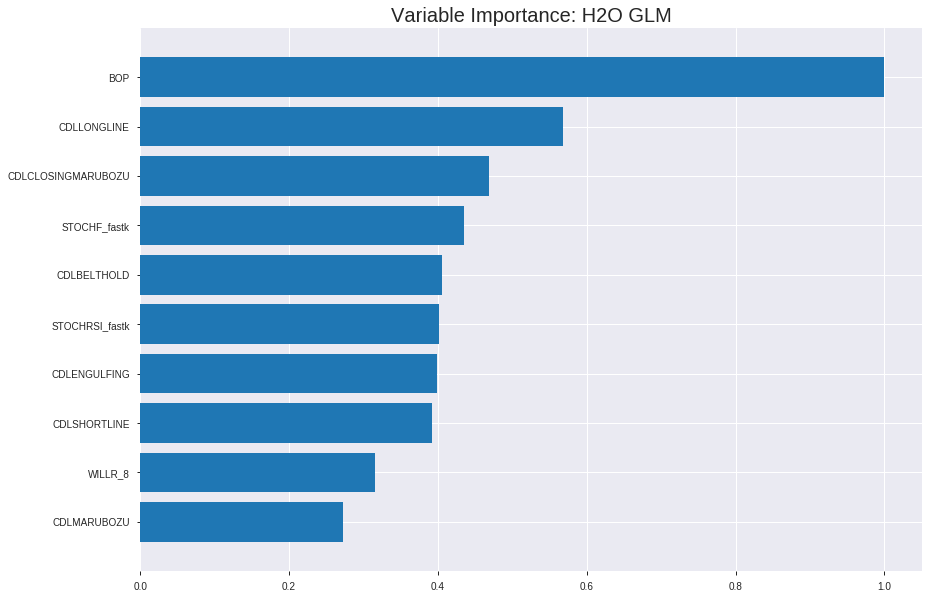

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_160307_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22818825598401382
RMSE: 0.4776905441643301
LogLoss: 0.6489646799556816
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2429.758140071244
Residual deviance: 2275.2701679246197
AIC: 4361.27016792462
AUC: 0.7294979624252997
pr_auc: 0.7278873194699714
Gini: 0.4589959248505995
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47643866945360624: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      396  467   0.5411   (467.0/863.0)
1      136  754   0.1528   (136.0/890.0)
Total  532  1221  0.344    (603.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476439     0.714353  246
max f2                       0.387801     0.844305  361
max f0point5                 0.51503      0.671882  182
max accuracy                 0.51503      0.665716  182
max precision                0.683643     1         0
max recall                   0.316329     1         397
max specificity              0.683643     1         0
max absolute_mcc             0.476439     0.332803  246
max min_per_class_accuracy   0.512745     0.663963  186
max mean_per_class_accuracy  0.51503      0.665865  182

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.629923           1.96966   1.96966            1                0.648251  1                           0.648251            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.618087           1.75081   1.86024            0.888889         0.62252   0.944444                    0.635386            0.0179775       0.0382022                  75.0811   86.0237
    3        0.0302339                   0.612917           1.50621   1.74668            0.764706         0.61533   0.886792                    0.628953            0.0146067       0.052809                   50.6213   74.6682
    4        0.040502                    0.607762           1.75081   1.74773            0.888889         0.610917  0.887324                    0.62438             0.0179775       0.0707865                  75.0811   74.7729
    5        0.0501997                   0.602484           1.96966   1.7906             1                0.605145  0.909091                    0.620664            0.0191011       0.0898876                  96.9663   79.0603
    6        0.100399                    0.587495           1.54439   1.6675             0.784091         0.594376  0.846591                    0.60752             0.0775281       0.167416                   54.4395   66.7499
    7        0.150029                    0.575514           1.44895   1.5952             0.735632         0.581014  0.809886                    0.598752            0.0719101       0.239326                   44.8947   59.5202
    8        0.200228                    0.5657             1.43248   1.55441            0.727273         0.570155  0.789174                    0.591583            0.0719101       0.311236                   43.2482   55.4406
    9        0.300057                    0.547806           1.22682   1.44542            0.622857         0.55651   0.73384                     0.579914            0.122472        0.433708                   22.6819   44.5418
    10       0.399886                    0.532271           1.14803   1.37118            0.582857         0.540334  0.696148                    0.570033            0.114607        0.548315                   14.8032   37.1178
    11       0.500285                    0.51292            1.14151   1.32509            0.579545         0.522558  0.672748                    0.560506            0.114607        0.662921                   14.1509   32.5087
    12       0.600114                    0.494896           0.911673  1.25632            0.462857         0.503177  0.637833                    0.550969            0.0910112       0.753933                   -8.83274  25.6315
    13       0.699943                    0.475449           0.945438  1.21198            0.48             0.485032  0.615322                    0.541565            0.094382        0.848315                   -5.45618  21.1977
    14       0.799772                    0.449894           0.709079  1.1492             0.36             0.464016  0.583452                    0.531885            0.0707865       0.919101                   -29.0921  14.9204
    15       0.899601                    0.417196           0.506485  1.07788            0.257143         0.434753  0.547242                    0.521106            0.0505618       0.969663                   -49.3515  7.78815
    16       1                           0.307922           0.302164  1                  0.153409         0.387589  0.507701                    0.507701         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24114733964295648
RMSE: 0.4910675509977792
LogLoss: 0.7263160454337684
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 693.6357161682504
Residual deviance: 727.7686775246359
AIC: 2813.7686775246357
AUC: 0.6702119145939371
pr_auc: 0.637057760943164
Gini: 0.3404238291878743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44290593096110786: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      54   180  0.7692   (180.0/234.0)
1      12   255  0.0449   (12.0/267.0)
Total  66   435  0.3832   (192.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442906     0.726496  336
max f2                       0.369371     0.851403  398
max f0point5                 0.51658      0.676968  217
max accuracy                 0.51658      0.656687  217
max precision                0.991204     0.727273  6
max recall                   0.369371     1         398
max specificity              0.999936     0.991453  0
max absolute_mcc             0.51658      0.309377  217
max min_per_class_accuracy   0.521058     0.636752  206
max mean_per_class_accuracy  0.51658      0.654398  217

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 54.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.998416           0.938202  0.938202           0.5              0.999208  0.5                         0.999208            0.011236        0.011236                   -6.17978  -6.17978
    2        0.0219561                   0.991204           1.8764    1.36466            1                0.995662  0.727273                    0.997596            0.0187266       0.0299625                  87.6404   36.4658
    3        0.0319361                   0.971329           0.750562  1.17275            0.4              0.979414  0.625                       0.991914            0.00749064      0.0374532                  -24.9438  17.2753
    4        0.0419162                   0.90119            1.12584   1.16158            0.6              0.915985  0.619048                    0.973836            0.011236        0.0486891                  12.5843   16.1584
    5        0.0518962                   0.870187           1.12584   1.15471            0.6              0.880563  0.615385                    0.955899            0.011236        0.0599251                  12.5843   15.471
    6        0.101796                    0.696114           1.05079   1.10377            0.56             0.767379  0.588235                    0.863487            0.0524345       0.11236                    5.07865   10.3767
    7        0.151697                    0.635194           1.35101   1.1851             0.72             0.657243  0.631579                    0.795643            0.0674157       0.179775                   35.1011   18.5098
    8        0.201597                    0.593625           1.35101   1.22617            0.72             0.608882  0.653465                    0.749415            0.0674157       0.247191                   35.1011   22.6165
    9        0.301397                    0.568024           1.35101   1.26751            0.72             0.581654  0.675497                    0.693865            0.134831        0.382022                   35.1011   26.7505
    10       0.401198                    0.544437           1.31348   1.27894            0.7              0.557032  0.681592                    0.659827            0.131086        0.513109                   31.3483   27.8942
    11       0.500998                    0.522266           1.2009    1.2634             0.64             0.531789  0.673307                    0.634321            0.11985         0.632959                   20.0899   26.3396
    12       0.600798                    0.502919           1.01326   1.22184            0.54             0.514184  0.651163                    0.614365            0.101124        0.734082                   1.32584   22.1845
    13       0.700599                    0.472708           0.863146  1.17075            0.46             0.486573  0.623932                    0.596161            0.0861423       0.820225                   -13.6854  17.0748
    14       0.800399                    0.455003           0.750562  1.11836            0.4              0.464427  0.59601                     0.579735            0.0749064       0.895131                   -24.9438  11.8356
    15       0.9002                      0.430273           0.675506  1.06926            0.36             0.445751  0.569845                    0.564881            0.0674157       0.962547                   -32.4494  6.92593
    16       1                           0.349508           0.375281  1                  0.2              0.402819  0.532934                    0.548707         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:03:10  0.000 sec   2            22        1021          1.36366           2.11693
    2019-08-27 16:03:12  2.271 sec   4            16        1039          1.35736           4.91502
    2019-08-27 16:03:15  4.523 sec   6            12        1039          1.34947           7.67112
    2019-08-27 16:03:17  6.817 sec   8            8.4       1042          1.33974           7.66275
    2019-08-27 16:03:19  9.072 sec   10           6.1       1043          1.32795           7.59697
    2019-08-27 16:03:21  11.347 sec  12           4.5       1043          1.31398           1.93077
    2019-08-27 16:03:24  13.582 sec  14           3.3       1043          1.29793           1.45263
    2019-08-27 16:03:26  15.932 sec  16           2.4       1043          1.28006           1.9551
    2019-08-27 16:03:28  18.212 sec  18           1.7       1043          1.26085           3.664
    2019-08-27 16:03:31  20.463 sec  20           1.3       1043          1.24087           6.15344
    2019-08-27 16:03:33  22.745 sec  22           0.91      1043          1.22082           9.27731
    2019-08-27 16:03:35  25.009 sec  24           0.66      1043          1.20127           13.0725

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6733067729083665)

('F1', 0.6338028169014085)

('auc', 0.6997607655502392)

('logloss', 0.689689159494161)

('mean_per_class_error', 0.3419391281233386)

('rmse', 0.48746995745230903)

('mse', 0.237626959418556)

glm prediction progress: |████████████████████████████████████████████████| 100%


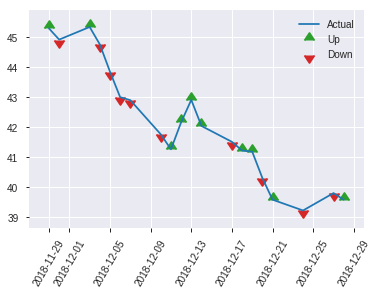


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.237626959418556
RMSE: 0.48746995745230903
LogLoss: 0.689689159494161
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 349.6521945213129
Residual deviance: 346.2239580660688
AIC: 2432.223958066069
AUC: 0.6997607655502392
pr_auc: 0.5395549337695855
Gini: 0.3995215311004785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44408481229338576: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   95   0.625    (95.0/152.0)
1      9    90   0.0909   (9.0/99.0)
Total  66   185  0.4143   (104.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444085     0.633803  184
max f2                       0.397032     0.799677  222
max f0point5                 0.499437     0.585859  98
max accuracy                 0.499437     0.673307  98
max precision                0.986673     0.666667  2
max recall                   0.397032     1         222
max specificity              0.996242     0.993421  0
max absolute_mcc             0.428266     0.320874  200
max min_per_class_accuracy   0.487189     0.625     118
max mean_per_class_accuracy  0.499437     0.658061  98

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.959828           1.69024   1.69024            0.666667         0.992799  0.666667                    0.992799            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.9293             0         0.845118           0                0.930688  0.333333                    0.961743            0               0.020202                   -100      -15.4882
    3        0.0318725                   0.818426           1.26768   0.950758           0.5              0.876752  0.375                       0.940496            0.010101        0.030303                   26.7677   -4.92424
    4        0.0438247                   0.801712           0.845118  0.921947           0.333333         0.804116  0.363636                    0.903301            0.010101        0.040404                   -15.4882  -7.80533
    5        0.0517928                   0.73036            2.53535   1.17016            1                0.765217  0.461538                    0.882057            0.020202        0.0606061                  153.535   17.0163
    6        0.103586                    0.607132           1.95027   1.56022            0.769231         0.64359   0.615385                    0.762824            0.10101         0.161616                   95.0272   56.0218
    7        0.151394                    0.566641           1.47896   1.53456            0.583333         0.582486  0.605263                    0.705875            0.0707071       0.232323                   47.8956   53.4556
    8        0.203187                    0.549153           1.75524   1.59081            0.692308         0.557394  0.627451                    0.668027            0.0909091       0.323232                   75.5245   59.081
    9        0.302789                    0.515696           1.31838   1.5012             0.52             0.529187  0.592105                    0.622356            0.131313        0.454545                   31.8384   50.1196
    10       0.40239                     0.497417           1.31838   1.45595            0.52             0.505495  0.574257                    0.59343             0.131313        0.585859                   31.8384   45.5946
    11       0.501992                    0.479009           0.811313  1.32804            0.32             0.489167  0.52381                     0.572743            0.0808081       0.666667                   -18.8687  32.8042
    12       0.601594                    0.460377           0.912727  1.25928            0.36             0.468318  0.496689                    0.555454            0.0909091       0.757576                   -8.72727  25.9282
    13       0.701195                    0.450261           1.11556   1.23887            0.44             0.454312  0.488636                    0.541087            0.111111        0.868687                   11.5556   23.8866
    14       0.800797                    0.428266           0.912727  1.1983             0.36             0.438693  0.472637                    0.528351            0.0909091       0.959596                   -8.72727  19.8301
    15       0.900398                    0.392406           0.405657  1.11062            0.16             0.411059  0.438053                    0.515377            0.040404        1                          -59.4343  11.0619
    16       1                           0.319068           0         1                  0                0.374259  0.394422                    0.501321       

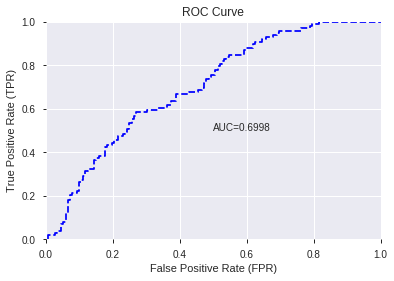

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


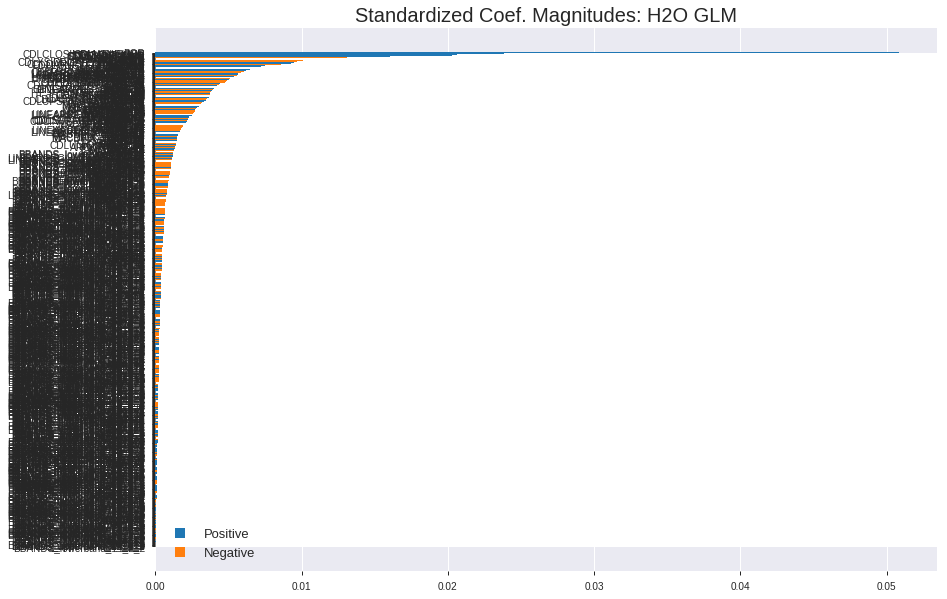

'log_likelihood'
--2019-08-27 16:04:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


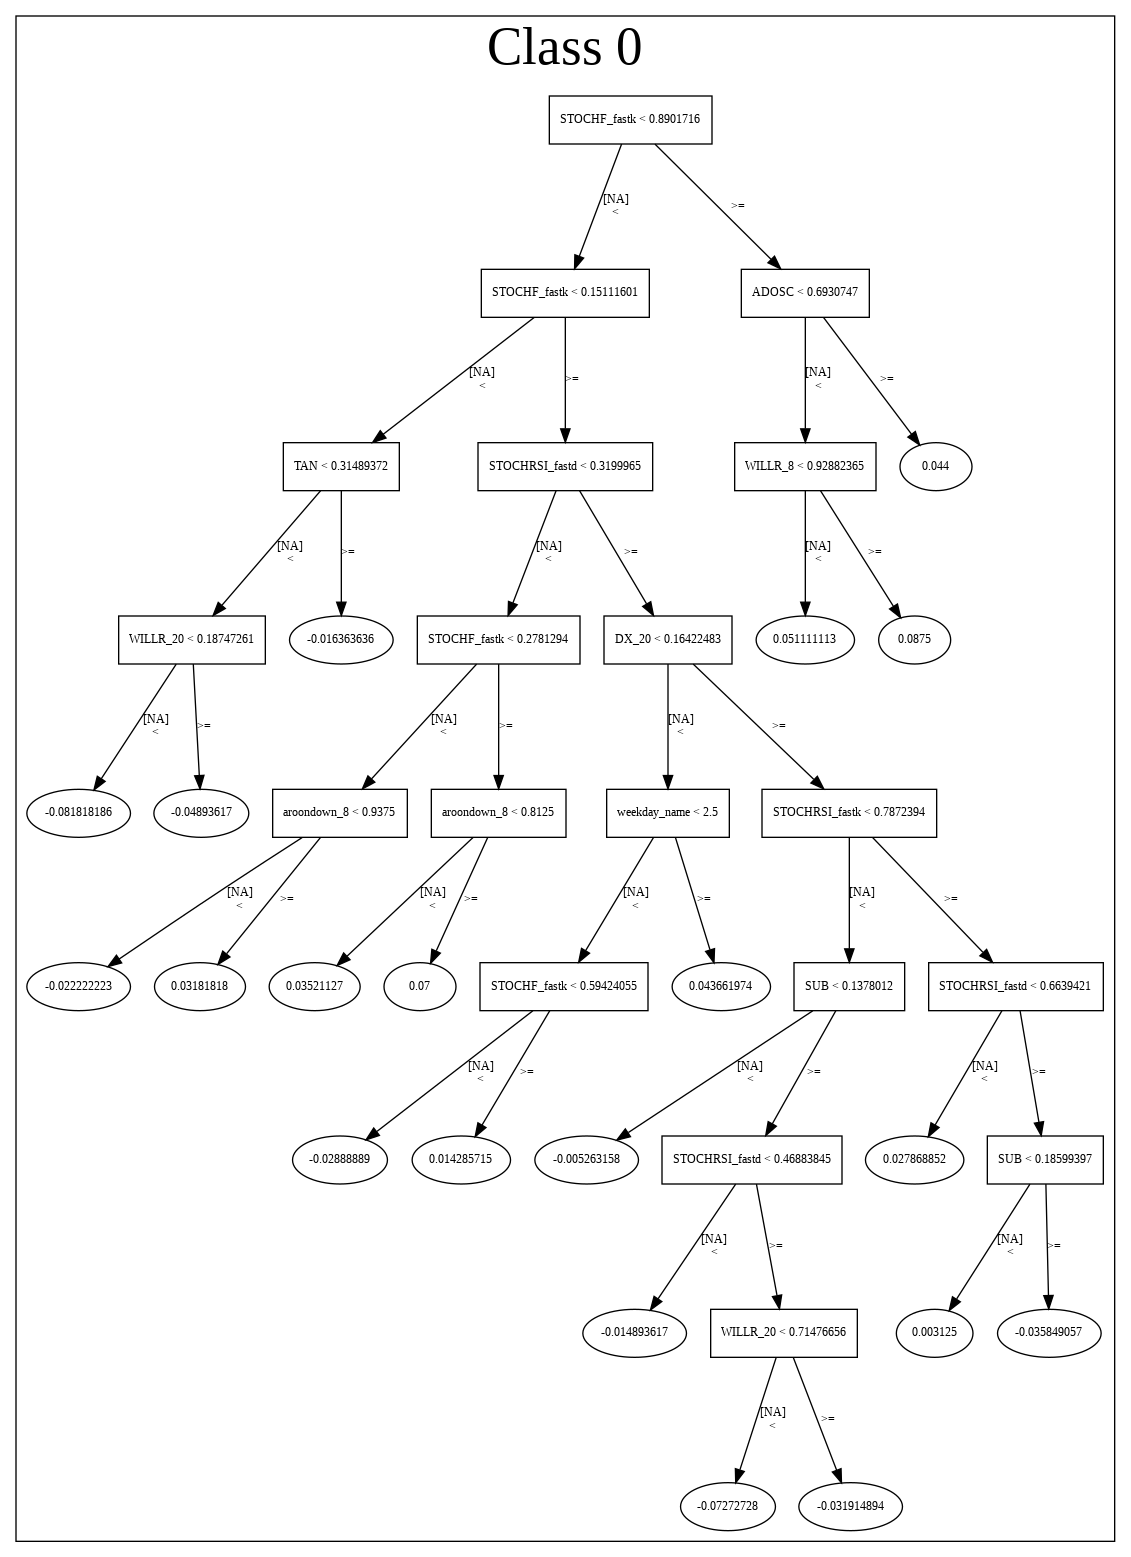

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_160307_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_160307_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

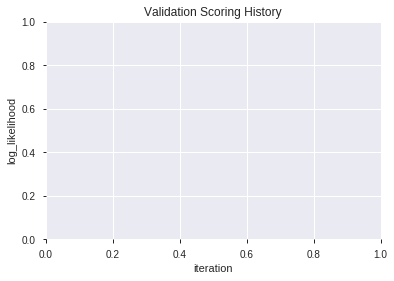

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_160417  0.725346  0.614583              0.302133  0.462001  0.213445
1               XGBoost_3_AutoML_20190827_160417  0.718235  0.612005              0.333400  0.460956  0.212481
2               XGBoost_2_AutoML_20190827_160417  0.714912  0.618706              0.341507  0.465131  0.216347
3  XGBoost_grid_1_AutoML_20190827_160417_model_3  0.708267  0.613722              0.367125  0.462255  0.213679
4  XGBoost_grid_1_AutoML_20190827_160417_model_4  0.706938  0.618962              0.350080  0.464688  0.215935
5  XGBoost_grid_1_AutoML_20190827_160417_model_7  0.698631  0.626737              0.351243  0.468061  0.219081
6  XGBoost_grid_1_AutoML_20190827_160417_model_2  0.688929  0.637493              0.357955  0.473205  0.223923
7  XGBoost_grid_1_AutoML_20190827_160417_model_6  0.681685  0.630414              0.390384  0.469817  0.220728
8  XGBoost_grid_1_AutoML_20190827_160417_model_1  0.678363  0.622906              0.366295  0.467102  0.218184
9  XGBoost_grid_1_AutoML_20190827_160417_model_5  0.647329  0.646347              0.393308  0.478018  0.228501

variable  relative_importance  scaled_importance  percentage
0                        BOP          1865.193848           1.000000    0.164097
1               STOCHF_fastk           536.898010           0.287851    0.047235
2                        SUB           336.432373           0.180374    0.029599
3                        DIV           155.643433           0.083446    0.013693
4                        TAN           131.597656           0.070554    0.011578
..                       ...                  ...                ...         ...
413  BBANDS_lowerband_20_7_5             0.571533           0.000306    0.000050
414   BBANDS_upperband_8_2_2             0.456871           0.000245    0.000040
415  BBANDS_lowerband_30_5_4             0.279985           0.000150    0.000025
416   BBANDS_upperband_8_0_4             0.177618           0.000095    0.000016
417  BBANDS_upperband_12_1_4             0.027969           0.000015    0.000002

[418 rows x 4 columns]

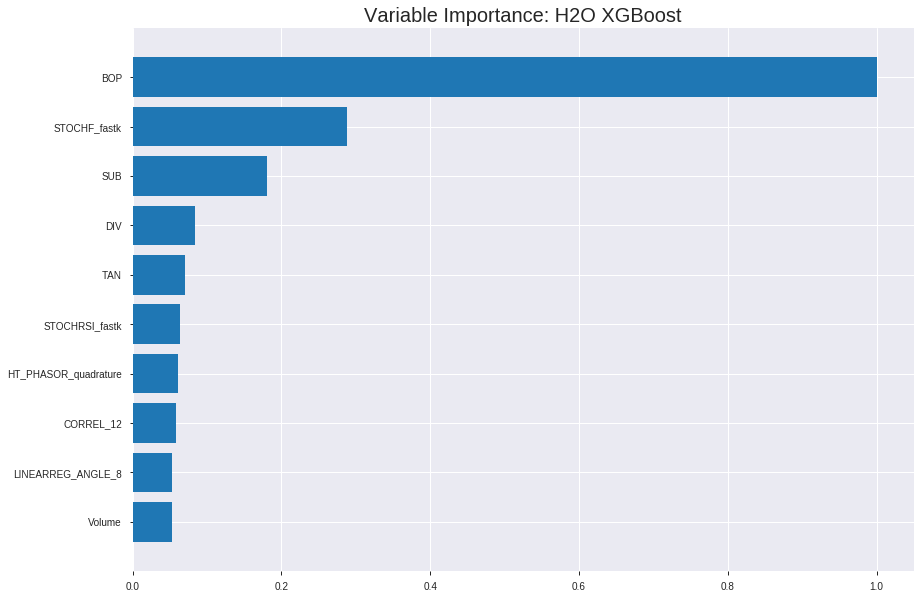

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_160417


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09789191641940463
RMSE: 0.31287683905876545
LogLoss: 0.3496382528260113
Mean Per-Class Error: 0.08377947322509671
AUC: 0.9759390420143997
pr_auc: 0.9757572657763096
Gini: 0.9518780840287995
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5040875434875488: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      789  74   0.0857   (74.0/863.0)
1      73   817  0.082    (73.0/890.0)
Total  862  891  0.0839   (147.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504088     0.917462  193
max f2                       0.397435     0.940466  236
max f0point5                 0.585206     0.939538  162
max accuracy                 0.518789     0.916144  189
max precision                0.93273      1         0
max recall                   0.260571     1         296
max specificity              0.93273      1         0
max absolute_mcc             0.518789     0.832346  189
max min_per_class_accuracy   0.504088     0.914253  193
max mean_per_class_accuracy  0.518789     0.916221  189

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.68 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.912205           1.96966    1.96966            1                0.923021  1                           0.923021            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.901402           1.96966    1.96966            1                0.907127  1                           0.915074            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.888289           1.96966    1.96966            1                0.893842  1                           0.908264            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.879552           1.96966    1.96966            1                0.883489  1                           0.901983            0.0202247       0.0797753                  96.9663   96.9663
    5        0.0501997                   0.873289           1.96966    1.96966            1                0.876003  1                           0.896964            0.0191011       0.0988764                  96.9663   96.9663
    6        0.100399                    0.84559            1.96966    1.96966            1                0.85961   1                           0.878287            0.0988764       0.197753                   96.9663   96.9663
    7        0.150029                    0.813483           1.96966    1.96966            1                0.829963  1                           0.862301            0.0977528       0.295506                   96.9663   96.9663
    8        0.200228                    0.787846           1.96966    1.96966            1                0.800694  1                           0.846856            0.0988764       0.394382                   96.9663   96.9663
    9        0.300057                    0.723061           1.94715    1.96217            0.988571         0.757113  0.996198                    0.816998            0.194382        0.588764                   94.7152   96.2174
    10       0.399886                    0.633333           1.78958    1.91909            0.908571         0.678494  0.974322                    0.782422            0.178652        0.767416                   78.9579   91.9087
    11       0.500285                    0.518856           1.42129    1.81919            0.721591         0.575573  0.923603                    0.74091             0.142697        0.910112                   42.1291   81.9187
    12       0.600114                    0.410511           0.630292   1.62141            0.32             0.461963  0.823194                    0.694508            0.0629213       0.973034                   -36.9708  62.1415
    13       0.699943                    0.303849           0.202594   1.41906            0.102857         0.356747  0.720456                    0.646335            0.0202247       0.993258                   -79.7406  41.9056
    14       0.799772                    0.21809            0.0675313  1.25036            0.0342857        0.260416  0.634807                    0.598164            0.00674157      1                          -93.2469  25.0357
    15       0.899601                    0.142212           0          1.1116             0                0.177685  0.564363                    0.551503            0               1                          -100      11.1604
    16       1                           0.0328456          0          1                  0                0.105983  0.507701                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20130269371194146
RMSE: 0.4486676873945141
LogLoss: 0.5886354580075693
Mean Per-Class Error: 0.28877364832421004
AUC: 0.7536492845481609
pr_auc: 0.7541825022101664
Gini: 0.5072985690963219
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42476221919059753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  102  0.4359   (102.0/234.0)
1      51   216  0.191    (51.0/267.0)
Total  183  318  0.3054   (153.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424762     0.738462  250
max f2                       0.198079     0.860602  364
max f0point5                 0.565056     0.744292  163
max accuracy                 0.565056     0.704591  163
max precision                0.929915     1         0
max recall                   0.143077     1         389
max specificity              0.929915     1         0
max absolute_mcc             0.565056     0.428038  163
max min_per_class_accuracy   0.493692     0.692308  203
max mean_per_class_accuracy  0.565056     0.711226  163

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.896676           1.56367   1.56367            0.833333         0.913454  0.833333                    0.913454            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.888906           1.8764    1.70582            1                0.892958  0.909091                    0.904138            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.870905           1.50112   1.64185            0.8              0.880509  0.875                       0.896754            0.0149813       0.0524345                  50.1124   64.1854
    4        0.0419162                   0.861076           1.12584   1.51899            0.6              0.865136  0.809524                    0.889226            0.011236        0.0636704                  12.5843   51.8994
    5        0.0518962                   0.852677           1.8764    1.58773            1                0.857206  0.846154                    0.883068            0.0187266       0.082397                   87.6404   58.7727
    6        0.101796                    0.79765            1.65124   1.61886            0.88             0.82127   0.862745                    0.852775            0.082397        0.164794                   65.1236   61.8859
    7        0.151697                    0.765747           1.27596   1.50606            0.68             0.781042  0.802632                    0.829179            0.0636704       0.228464                   27.5955   50.6062
    8        0.201597                    0.732662           1.42607   1.48626            0.76             0.751822  0.792079                    0.810031            0.071161        0.299625                   42.6067   48.6261
    9        0.301397                    0.66043            1.42607   1.46633            0.76             0.694139  0.781457                    0.771656            0.142322        0.441948                   42.6067   46.6329
    10       0.401198                    0.572993           1.4636    1.46565            0.78             0.614903  0.781095                    0.732663            0.146067        0.588015                   46.3596   46.5649
    11       0.500998                    0.501775           0.900674  1.3531             0.48             0.536641  0.721116                    0.693615            0.0898876       0.677903                   -9.93258  35.3104
    12       0.600798                    0.442583           0.97573   1.29042            0.52             0.470665  0.687708                    0.65658             0.0973783       0.775281                   -2.42697  29.0418
    13       0.700599                    0.382272           0.750562  1.21352            0.4              0.412458  0.646724                    0.621805            0.0749064       0.850187                   -24.9438  21.3515
    14       0.800399                    0.296749           0.637978  1.14175            0.34             0.336374  0.608479                    0.586215            0.0636704       0.913858                   -36.2022  14.1752
    15       0.9002                      0.210878           0.562921  1.07758            0.3              0.252838  0.574279                    0.549255            0.0561798       0.970037                   -43.7079  7.75804
    16       1                           0.0539733          0.300225  1                  0.16             0.161084  0.532934                    0.510515          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:04:18  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-27 16:04:19  1.410 sec   5                  0.47096          0.636425            0.866579        0.857978           1.96966          0.223046                         0.483969           0.6614                0.733666          0.737014             1.56367            0.311377
    2019-08-27 16:04:19  1.722 sec   10                 0.4451           0.58754             0.897728        0.898235           1.96966          0.188819                         0.472065           0.637921              0.748632          0.756583             1.8764             0.343313
    2019-08-27 16:04:20  2.027 sec   15                 0.426108         0.552112            0.910064        0.910885           1.96966          0.172276                         0.464425           0.622528              0.756066          0.76116              1.8764             0.305389
    2019-08-27 16:04:20  2.337 sec   20                 0.40857          0.519639            0.921308        0.921178           1.96966          0.167712                         0.459996           0.613289              0.754906          0.756424             1.56367            0.305389
    2019-08-27 16:04:20  2.654 sec   25                 0.39271          0.490194            0.9297          0.931042           1.96966          0.15231                          0.458233           0.609305              0.748135          0.748813             1.56367            0.313373
    2019-08-27 16:04:21  2.966 sec   30                 0.380072         0.46686             0.936585        0.937074           1.96966          0.13862                          0.45444            0.601326              0.752369          0.749757             1.56367            0.307385
    2019-08-27 16:04:21  3.291 sec   35                 0.367862         0.4447              0.944487        0.944321           1.96966          0.131774                         0.453175           0.597925              0.749904          0.753769             1.56367            0.319361
    2019-08-27 16:04:21  3.611 sec   40                 0.357277         0.425973            0.952533        0.954612           1.96966          0.125499                         0.452452           0.59617               0.747895          0.752597             1.56367            0.343313
    2019-08-27 16:04:22  3.936 sec   45                 0.345777         0.406393            0.961517        0.962752           1.96966          0.11352                          0.451116           0.593614              0.749096          0.753585             1.56367            0.331337
    2019-08-27 16:04:22  4.235 sec   50                 0.336927         0.390737            0.965145        0.966557           1.96966          0.106104                         0.449933           0.590962              0.751769          0.755972             1.56367            0.337325
    2019-08-27 16:04:22  4.549 sec   55                 0.32818          0.375511            0.968972        0.970346           1.96966          0.100399                         0.449362           0.589781              0.751665          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1865.19384765625       1.0                     0.16409685393213969
STOCHF_fastk             536.8980102539062      0.28785105147572576     0.047235451948224996
SUB                      336.432373046875       0.18037394529776432     0.029598796954690986
DIV                      155.6434326171875      0.08344625027192999     0.013693267142057668
TAN                      131.59765625           0.07055441256969719     0.01157775713371752
---                      ---                    ---                     ---
BBANDS_lowerband_20_7_5  0.571533203125         0.00030642027038807387  5.02826023517185e-05
BBANDS_upperband_8_2_2   0.45687103271484375    0.0002449456035301291   4.019480292380339e-05
BBANDS_lowerband_30_5_4  0.2799854278564453     0.00015011063231216805  2.4632682504190968e-05
BBANDS_upperband_8_0_4   0.17761802673339844    9.522764990705295e-05   1.5626557757098604e-05
BBANDS_upperband_12_1_4  0.027968883514404297   1.4995161789510086e-05  2.4606588738620388e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.6550218340611353)

('auc', 0.7253455608718766)

('logloss', 0.6145832328482278)

('mean_per_class_error', 0.3021331738437001)

('rmse', 0.4620009619885711)

('mse', 0.2134448888783651)

xgboost prediction progress: |████████████████████████████████████████████| 100%


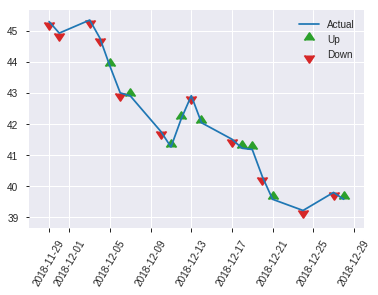


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2134448888783651
RMSE: 0.4620009619885711
LogLoss: 0.6145832328482278
Mean Per-Class Error: 0.3021331738437001
AUC: 0.7253455608718766
pr_auc: 0.614002132686021
Gini: 0.45069112174375325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4818528890609741: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      97   55   0.3618   (55.0/152.0)
1      24   75   0.2424   (24.0/99.0)
Total  121  130  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481853     0.655022  129
max f2                       0.302004     0.794702  207
max f0point5                 0.481853     0.605816  129
max accuracy                 0.506265     0.685259  111
max precision                0.915372     1         0
max recall                   0.216022     1         243
max specificity              0.915372     1         0
max absolute_mcc             0.481853     0.38706   129
max min_per_class_accuracy   0.503617     0.676768  113
max mean_per_class_accuracy  0.481853     0.697867  129

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 49.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.850558           2.53535   2.53535            1                0.878589  1                           0.878589            0.030303        0.030303                   153.535   153.535
    2        0.0239044                   0.829861           2.53535   2.53535            1                0.835093  1                           0.856841            0.030303        0.0606061                  153.535   153.535
    3        0.0318725                   0.823235           2.53535   2.53535            1                0.824582  1                           0.848776            0.020202        0.0808081                  153.535   153.535
    4        0.0438247                   0.792295           1.69024   2.30487            0.666667         0.807773  0.909091                    0.837593            0.020202        0.10101                    69.0236   130.487
    5        0.0517928                   0.759382           1.26768   2.1453             0.5              0.776542  0.846154                    0.828201            0.010101        0.111111                   26.7677   114.53
    6        0.103586                    0.717099           1.56022   1.85276            0.615385         0.734207  0.730769                    0.781204            0.0808081       0.191919                   56.0218   85.2758
    7        0.151394                    0.678167           1.0564    1.60128            0.416667         0.697863  0.631579                    0.754886            0.0505051       0.242424                   5.63973   60.1276
    8        0.203187                    0.649685           1.56022   1.59081            0.615385         0.662038  0.627451                    0.731219            0.0808081       0.323232                   56.0218   59.081
    9        0.302789                    0.602889           1.21697   1.46784            0.48             0.620514  0.578947                    0.694803            0.121212        0.444444                   21.697    46.7836
    10       0.40239                     0.534075           1.4198    1.45595            0.56             0.561279  0.574257                    0.661752            0.141414        0.585859                   41.9798   45.5946
    11       0.501992                    0.492742           1.4198    1.44877            0.56             0.507537  0.571429                    0.631154            0.141414        0.727273                   41.9798   44.8773
    12       0.601594                    0.449498           0.709899  1.32644            0.28             0.467401  0.523179                    0.604043            0.0707071       0.79798                    -29.0101  32.6443
    13       0.701195                    0.397802           0.811313  1.25327            0.32             0.416349  0.494318                    0.577382            0.0808081       0.878788                   -18.8687  25.3271
    14       0.800797                    0.33189            0.709899  1.18569            0.28             0.365697  0.467662                    0.551053            0.0707071       0.949495                   -29.0101  18.5688
    15       0.900398                    0.278558           0.304242  1.08818            0.12             0.296042  0.429204                    0.522844            0.030303        0.979798                   -69.5758  8.81827
    16       1                           0.116147           0.202828  1                  0.08             0.224099  0.394422                    0.493088           

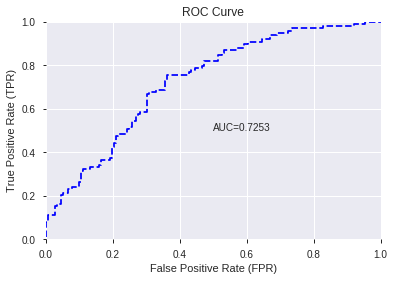

This function is available for GLM models only


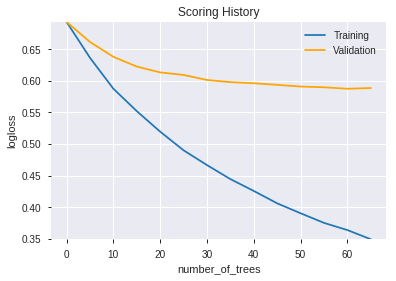

--2019-08-27 16:05:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

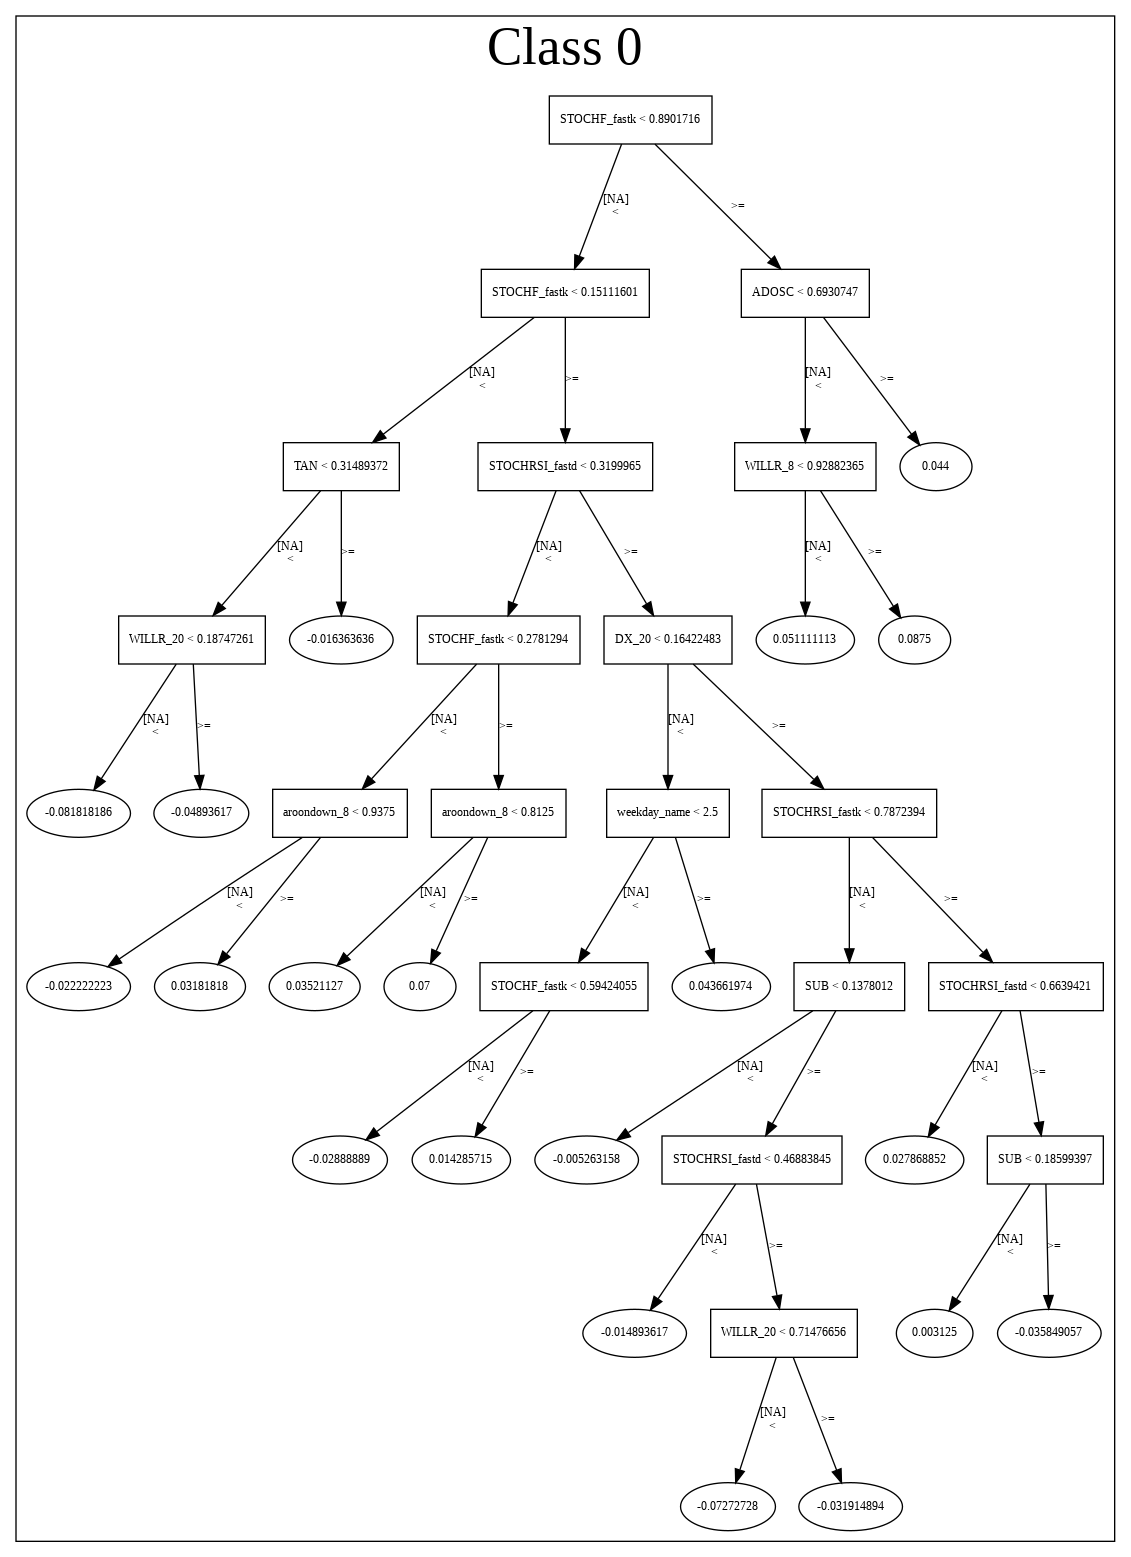

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_160417',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_160417',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b362',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_160559_model_6  0.692517  0.649919              0.354765  0.478865  0.229312
1  DeepLearning_grid_1_AutoML_20190827_160559_model_9  0.692185  0.654798              0.402246  0.481379  0.231726
2  DeepLearning_grid_1_AutoML_20190827_160559_model_5  0.689859  0.707869              0.386497  0.501874  0.251877
3  DeepLearning_grid_1_AutoML_20190827_160559_model_8  0.689660  0.659997              0.363935  0.484890  0.235119
4  DeepLearning_grid_1_AutoML_20190827_160559_model_7  0.687932  0.770046              0.339846  0.513250  0.263425
5  DeepLearning_grid_1_AutoML_20190827_160559_model_3  0.644870  0.890984              0.400585  0.555947  0.309077
6  DeepLearning_grid_1_AutoML_20190827_160559_model_4  0.640484  1.011929              0.464281  0.572080  0.327276
7               DeepLearning_1_AutoML_20190827_160559  0.629984  0.721480              0.407164  0.506884  0.256932
8  DeepLearning_grid_1_AutoML_20190827_160559_model_1  0.574628  1.458405              0.480263  0.623241  0.388429
9  DeepLearning_grid_1_AutoML_20190827_160559_model_2  0.532562  1.411871              0.478967  0.641738  0.411827

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.046023
1         CDLSHORTLINE             0.590057           0.590057    0.027156
2                  SUB             0.564456           0.564456    0.025978
3          CDLLONGLINE             0.537514           0.537514    0.024738
4   CDLCLOSINGMARUBOZU             0.511561           0.511561    0.023544
5               TRANGE             0.484204           0.484204    0.022285
6         weekday_name             0.479040           0.479040    0.022047
7                  DIV             0.473187           0.473187    0.021778
8               ULTOSC             0.461179           0.461179    0.021225
9        days_in_month             0.457117           0.457117    0.021038
10              SAREXT             0.453522           0.453522    0.020873
11        CDLENGULFING             0.446186           0.446186    0.020535
12           CORREL_12             0.445680           0.445680    0.020512
13               month             0.436680           0.436680    0.020097
14           CORREL_14             0.426459           0.426459    0.019627
15                  AD             0.426002           0.426002    0.019606
16             CDLDOJI             0.424512           0.424512    0.019537
17                 TAN             0.420811           0.420811    0.019367
18          AROONOSC_8             0.417079           0.417079    0.019195
19   CDLLONGLEGGEDDOJI             0.415727           0.415727    0.019133
20              ADX_24             0.415315           0.415315    0.019114
21           CORREL_20             0.414933           0.414933    0.019097
22         CDLBELTHOLD             0.414472           0.414472    0.019075
23        HT_TRENDMODE             0.414254           0.414254    0.019065
24            WILLR_20             0.412234           0.412234    0.018972
25              Volume             0.411845           0.411845    0.018954
26                 SIN             0.409825           0.409825    0.018861
27                 day             0.408196           0.408196    0.018786
28         STOCH_slowd             0.406551           0.406551    0.018711
29            WILLR_14             0.406292           0.406292    0.018699
30               DX_20             0.405878           0.405878    0.018680
31      STOCHRSI_fastk             0.401112           0.401112    0.018460
32         CDLMARUBOZU             0.401035           0.401035    0.018457
33            WILLR_30             0.400729           0.400729    0.018443
34        STOCHF_fastk             0.400153           0.400153    0.018416
35         aroondown_8             0.397022           0.397022    0.018272
36               DX_24             0.396142           0.396142    0.018232
37               DX_30             0.395316           0.395316    0.018194
38           CORREL_24             0.393858           0.393858    0.018127
39                 COS             0.392100           0.392100    0.018046
40            WILLR_24             0.388663           0.388663    0.017888
41               ADOSC             0.387886           0.387886    0.017852
42            WILLR_12             0.385833           0.385833    0.017757
43             ADXR_14             0.381454           0.381454    0.017556
44      STOCHRSI_fastd             0.377992           0.377992    0.017396
45             WILLR_8             0.376078           0.376078    0.017308
46                DX_8             0.369900           0.369900    0.017024
47      CDLEVENINGSTAR             0.364134           0.364134    0.016759
48   CDLDARKCLOUDCOVER             0.364017           0.364017    0.016753
49              ADX_20             0.363998           0.363998    0.016752

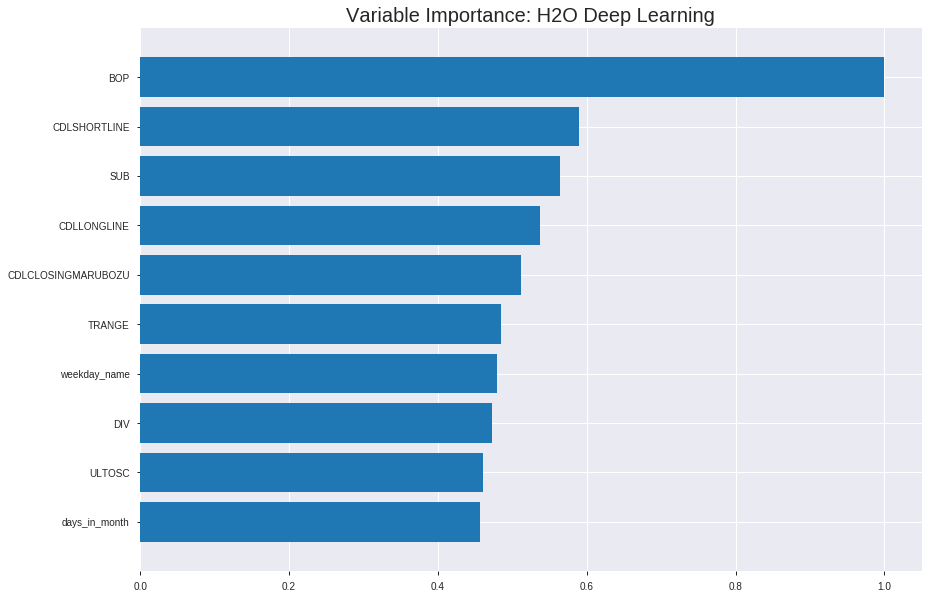

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_160559_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1858545092198294
RMSE: 0.43110846572507644
LogLoss: 0.5458270408213972
Mean Per-Class Error: 0.28941958415248614
AUC: 0.7901949041103025
pr_auc: 0.7845121309237751
Gini: 0.5803898082206049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37827499180918006: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      396  467   0.5411   (467.0/863.0)
1      74   816   0.0831   (74.0/890.0)
Total  470  1283  0.3086   (541.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378275     0.751035  269
max f2                       0.209393     0.859666  334
max f0point5                 0.566462     0.718016  173
max accuracy                 0.447137     0.711922  236
max precision                0.979781     1         0
max recall                   0.033172     1         389
max specificity              0.979781     1         0
max absolute_mcc             0.434026     0.437949  242
max min_per_class_accuracy   0.524785     0.698876  196
max mean_per_class_accuracy  0.49741      0.71058   210

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.963206           1.86024   1.86024            0.944444         0.972507  0.944444                    0.972507            0.0191011       0.0191011                  86.0237   86.0237
    2        0.0205362                   0.937093           1.96966   1.91495            1                0.952481  0.972222                    0.962494            0.0202247       0.0393258                  96.9663   91.495
    3        0.0302339                   0.923502           1.8538    1.89534            0.941176         0.928847  0.962264                    0.951702            0.0179775       0.0573034                  85.38     89.5336
    4        0.040502                    0.907882           1.96966   1.91418            1                0.918386  0.971831                    0.943255            0.0202247       0.0775281                  96.9663   91.4179
    5        0.0501997                   0.891981           1.73794   1.88013            0.882353         0.900074  0.954545                    0.934913            0.0168539       0.094382                   73.7938   88.0133
    6        0.100399                    0.834183           1.72346   1.80179            0.875            0.86453   0.914773                    0.899722            0.0865169       0.180899                   72.3455   80.1794
    7        0.150029                    0.781343           1.65271   1.75248            0.83908          0.807123  0.889734                    0.86909             0.0820225       0.262921                   65.2706   75.2476
    8        0.200228                    0.728979           1.4101    1.66664            0.715909         0.75397   0.846154                    0.840228            0.0707865       0.333708                   41.01     66.6638
    9        0.300057                    0.636461           1.35063   1.5615             0.685714         0.677464  0.792776                    0.786077            0.134831        0.468539                   35.0626   56.1501
    10       0.399886                    0.575378           1.24933   1.48357            0.634286         0.605914  0.75321                     0.7411              0.124719        0.593258                   24.9329   48.3569
    11       0.500285                    0.524618           1.01841   1.39022            0.517045         0.549112  0.705815                    0.702571            0.102247        0.695506                   1.84053   39.0218
    12       0.600114                    0.469132           1.06925   1.33682            0.542857         0.49733   0.678707                    0.668429            0.106742        0.802247                   6.92456   33.6824
    13       0.699943                    0.404061           0.821631  1.26335            0.417143         0.4366    0.641402                    0.635365            0.0820225       0.88427                    -17.8369  26.3345
    14       0.799772                    0.313265           0.697823  1.19276            0.354286         0.362813  0.605563                    0.601344            0.0696629       0.953933                   -30.2177  19.2756
    15       0.899601                    0.167177           0.360167  1.10036            0.182857         0.245478  0.558656                    0.561854            0.0359551       0.989888                   -63.9833  10.0363
    16       1                           0.00181165         0.100721  1                  0.0511364        0.081942  0.507701                    0.513671          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20030565522001292
RMSE: 0.4475551979588807
LogLoss: 0.5831165663812499
Mean Per-Class Error: 0.30795640065302987
AUC: 0.7499199718300842
pr_auc: 0.761318667868255
Gini: 0.4998399436601684
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3996301185210709: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   141  0.6026   (141.0/234.0)
1      21   246  0.0787   (21.0/267.0)
Total  114  387  0.3234   (162.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39963      0.752294  294
max f2                       0.258122     0.864238  345
max f0point5                 0.536767     0.715428  197
max accuracy                 0.536767     0.690619  197
max precision                0.974967     1         0
max recall                   0.0811737    1         389
max specificity              0.974967     1         0
max absolute_mcc             0.536767     0.383315  197
max min_per_class_accuracy   0.52701      0.681648  204
max mean_per_class_accuracy  0.536767     0.692044  197

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 53.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.960447           1.56367   1.56367            0.833333         0.965996  0.833333                    0.965996            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.938196           1.8764    1.70582            1                0.944768  0.909091                    0.956347            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.920059           1.8764    1.75913            1                0.925118  0.9375                      0.946588            0.0187266       0.0561798                  87.6404   75.9129
    4        0.0419162                   0.908708           1.50112   1.6977             0.8              0.913192  0.904762                    0.938637            0.0149813       0.071161                   50.1124   69.7699
    5        0.0518962                   0.883337           1.50112   1.6599             0.8              0.893261  0.884615                    0.92991             0.0149813       0.0861423                  50.1124   65.9896
    6        0.101796                    0.828609           1.80135   1.72924            0.96             0.848719  0.921569                    0.890111            0.0898876       0.17603                    80.1348   72.9236
    7        0.151697                    0.771158           1.42607   1.62951            0.76             0.803564  0.868421                    0.861641            0.071161        0.247191                   42.6067   62.9509
    8        0.201597                    0.733832           1.27596   1.542              0.68             0.748997  0.821782                    0.833759            0.0636704       0.310861                   27.5955   54.1996
    9        0.301397                    0.640781           1.23843   1.44148            0.66             0.680167  0.768212                    0.782901            0.123596        0.434457                   23.8427   44.1476
    10       0.401198                    0.582782           1.12584   1.36296            0.6              0.609738  0.726368                    0.739825            0.11236         0.546816                   12.5843   36.296
    11       0.500998                    0.530894           1.27596   1.34563            0.68             0.557107  0.717131                    0.703427            0.127341        0.674157                   27.5955   34.5629
    12       0.600798                    0.487458           0.750562  1.24678            0.4              0.509848  0.664452                    0.671271            0.0749064       0.749064                   -24.9438  24.678
    13       0.700599                    0.442292           1.05079   1.21886            0.56             0.463275  0.649573                    0.641642            0.104869        0.853933                   5.07865   21.8861
    14       0.800399                    0.368182           0.825618  1.16983            0.44             0.409314  0.623441                    0.612674            0.082397        0.93633                    -17.4382  16.9828
    15       0.9002                      0.226681           0.412809  1.0859             0.22             0.302538  0.578714                    0.578291            0.0411985       0.977528                   -58.7191  8.59015
    16       1                           0.00801703         0.225169  1                  0.12             0.133331  0.532934                    0.533883            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:09:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:09:39  1 min 44.920 sec  896 obs/sec       1         1             1753       0.596817         1.31285             -0.425098      0.741868        0.721959           1.86024          0.322875                         0.612561           1.35909               -0.507467        0.729929          0.714896             0.938202           0.341317
    2019-08-27 16:09:45  1 min 50.355 sec  1530 obs/sec      6         6             10518      0.446208         0.578157            0.203405       0.772574        0.768305           1.96966          0.318882                         0.456608           0.602261              0.162401         0.747983          0.756888             1.56367            0.333333
    2019-08-27 16:09:50  1 min 56.032 sec  2183 obs/sec      15        15            26295      0.431108         0.545827            0.256406       0.790195        0.784512           1.86024          0.308614                         0.447555           0.583117              0.195286         0.74992           0.761319             1.56367            0.323353
    2019-08-27 16:09:56  2 min  1.302 sec  2502 obs/sec      24        24            42072      0.423293         0.529096            0.283123       0.806053        0.803767           1.86024          0.281232                         0.447708           0.583521              0.194738         0.75088           0.758351             1.56367            0.331337
    2019-08-27 16:10:01  2 min  6.548 sec  2685 obs/sec      33        33            57849      0.415197         0.51152             0.310282       0.823618        0.822174           1.96966          0.274387                         0.451362           0.592452              0.181538         0.738084          0.744809             1.56367            0.337325
    2019-08-27 16:10:06  2 min 11.707 sec  2811 obs/sec      42        42            73626      0.407145         0.495415            0.336774       0.840226        0.83762            1.96966          0.257844                         0.449755           0.59064               0.187356         0.743526          0.75393              1.56367            0.335329
    2019-08-27 16:10:12  2 min 17.359 sec  2911 obs/sec      52        52            91156      0.398027         0.477683            0.366147       0.856852        0.852734           1.96966          0.238448                         0.451361           0.594278              0.181541         0.740637          0.754858             1.56367            0.335329
    2019-08-27 16:10:12  2 min 17.879 sec  2909 obs/sec      52        52            91156      0.431108         0.545827            0.256406       0.790195        0.784512           1.86024          0.308614                         0.447555           0.583117              0.195286         0.74992           0.761319             1.56367            0.323353

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04602315541982159
CDLSHORTLINE        0.5900571346282959     0.5900571346282959   0.027156291213572655
SUB                 0.5644561648368835     0.5644561648368835   0.02597805380196433
CDLLONGLINE         0.5375135540962219     0.5375135540962219   0.024738069840431105
CDLCLOSINGMARUBOZU  0.5115609765052795     0.5115609765052795   0.023543650328418184
---                 ---                    ---                  ---
WILLR_8             0.37607836723327637    0.37607836723327637  0.01730831314520982
DX_8                0.3698996901512146     0.3698996901512146   0.0170239509295732
CDLEVENINGSTAR      0.36413440108299255    0.36413440108299255  0.01675861413474622
CDLDARKCLOUDCOVER   0.3640173077583313     0.3640173077583313   0.01675322513046671
ADX_20              0.3639983832836151     0.3639983832836151   0.01675235416642561


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.6122448979591837)

('auc', 0.6925172780435938)

('logloss', 0.6499185349114545)

('mean_per_class_error', 0.34310207336523124)

('rmse', 0.4788652400200169)

('mse', 0.2293119180994284)

deeplearning prediction progress: |███████████████████████████████████████| 100%


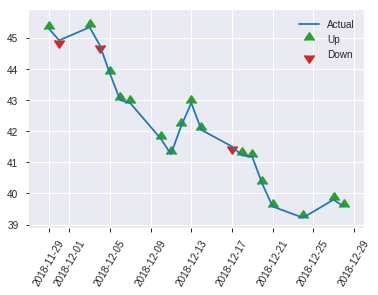


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2293119180994284
RMSE: 0.4788652400200169
LogLoss: 0.6499185349114545
Mean Per-Class Error: 0.34310207336523124
AUC: 0.6925172780435938
pr_auc: 0.5971513471984926
Gini: 0.3850345560871875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49132913088885655: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   71   0.4671   (71.0/152.0)
1      24   75   0.2424   (24.0/99.0)
Total  105  146  0.3785   (95.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491329     0.612245  145
max f2                       0.239549     0.778302  239
max f0point5                 0.640487     0.619048  53
max accuracy                 0.640487     0.701195  53
max precision                0.949926     1         0
max recall                   0.239549     1         239
max specificity              0.949926     1         0
max absolute_mcc             0.640487     0.351162  53
max min_per_class_accuracy   0.521096     0.631579  118
max mean_per_class_accuracy  0.601271     0.656898  73

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 52.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.924332           1.69024   1.69024            0.666667         0.940169  0.666667                    0.940169            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.908622           2.53535   2.11279            1                0.914865  0.833333                    0.927517            0.030303        0.0505051                  153.535   111.279
    3        0.0318725                   0.89294            2.53535   2.21843            1                0.899465  0.875                       0.920504            0.020202        0.0707071                  153.535   121.843
    4        0.0438247                   0.870826           1.69024   2.07438            0.666667         0.879491  0.818182                    0.909319            0.020202        0.0909091                  69.0236   107.438
    5        0.0517928                   0.839198           1.26768   1.95027            0.5              0.850894  0.769231                    0.90033             0.010101        0.10101                    26.7677   95.0272
    6        0.103586                    0.719699           1.75524   1.85276            0.692308         0.776658  0.730769                    0.838494            0.0909091       0.191919                   75.5245   85.2758
    7        0.151394                    0.675857           1.47896   1.73472            0.583333         0.6916    0.684211                    0.792106            0.0707071       0.262626                   47.8956   73.4716
    8        0.203187                    0.65187            1.95027   1.78966            0.769231         0.657572  0.705882                    0.757813            0.10101         0.363636                   95.0272   78.9661
    9        0.302789                    0.594349           1.21697   1.60128            0.48             0.618677  0.631579                    0.712045            0.121212        0.484848                   21.697    60.1276
    10       0.40239                     0.551998           0.811313  1.40574            0.32             0.567716  0.554455                    0.67632             0.0808081       0.565657                   -18.8687  40.5741
    11       0.501992                    0.513933           0.811313  1.2878             0.32             0.532159  0.507937                    0.647717            0.0808081       0.646465                   -18.8687  28.7799
    12       0.601594                    0.486207           1.11556   1.25928            0.44             0.500848  0.496689                    0.623401            0.111111        0.757576                   11.5556   25.9282
    13       0.701195                    0.454076           0.709899  1.18124            0.28             0.472974  0.465909                    0.602033            0.0707071       0.828283                   -29.0101  18.1244
    14       0.800797                    0.393927           0.709899  1.12262            0.28             0.424397  0.442786                    0.579939            0.0707071       0.89899                    -29.0101  12.2619
    15       0.900398                    0.321872           0.304242  1.03209            0.12             0.359729  0.40708                     0.55558             0.030303        0.929293                   -69.5758  3.20908
    16       1                           0.023802           0.709899  1                  0.28             0.232215  0.394422                    0.523372         

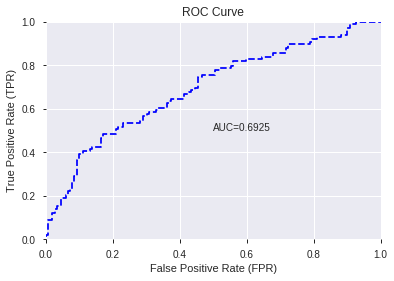

This function is available for GLM models only


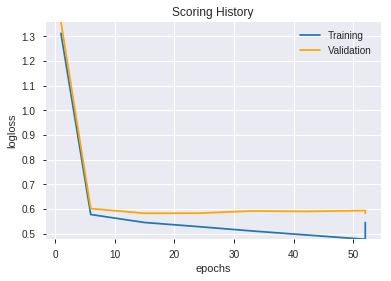

--2019-08-27 16:13:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


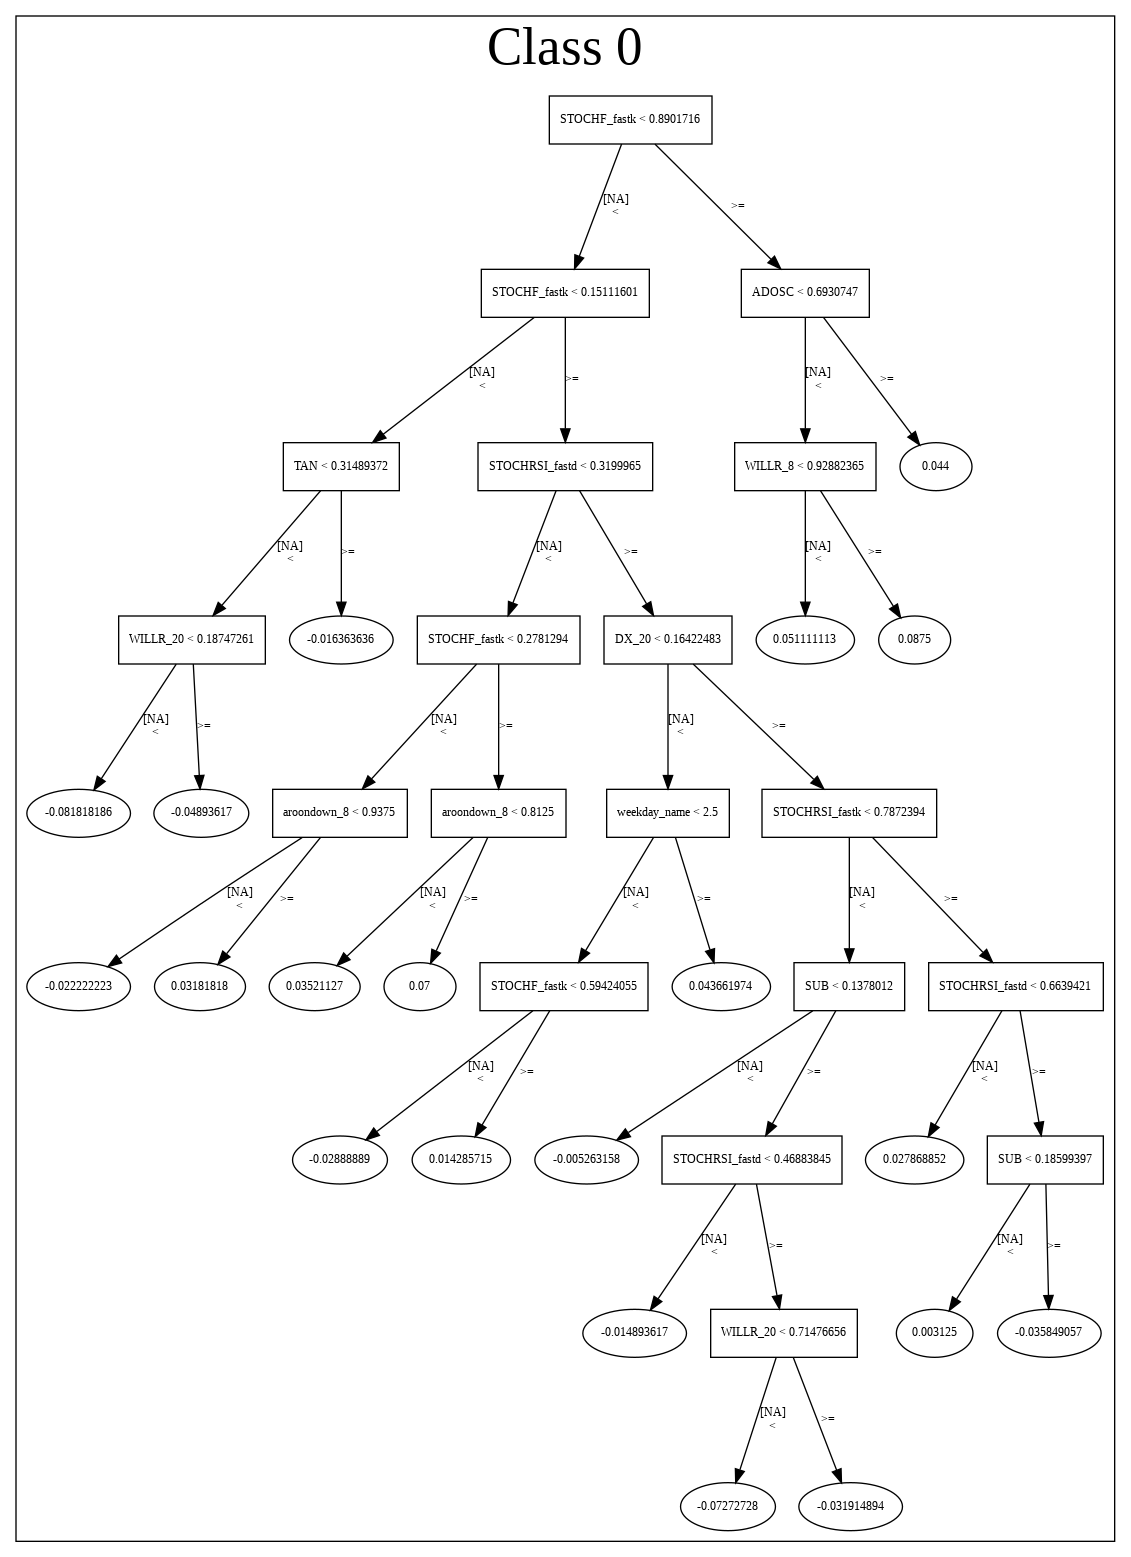

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_160559_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_160559_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLSHORTLINE',
 'SUB',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'weekday_name',
 'DIV',
 'ULTOSC',
 'days_in_month',
 'SAREXT',
 'CDLENGULFING',
 'CORREL_12',
 'month',
 'CORREL_14',
 'AD',
 'CDLDOJI',
 'TAN',
 'AROONOSC_8',
 'CDLLONGLEGGEDDOJI',
 'ADX_24',
 'CORREL_20',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'WILLR_20',
 'Volume',
 'SIN',
 'day',
 'STOCH_slowd',
 'WILLR_14',
 'DX_20',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'WILLR_30',
 'STOCHF_fastk',
 'aroondown_8',
 'DX_24',
 'DX_30',
 'CORREL_24',
 'COS',
 'WILLR_24',
 'ADOSC',
 'WILLR_12',
 'ADXR_14',
 'STOCHRSI_fastd',
 'WILLR_8',
 'DX_8',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'ADX_20']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_161345_model_1  0.701754  0.628874              0.377691  0.468681  0.219662

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.768706           1.000000    0.186814
1                  SUB             0.340187           0.442545    0.082673
2            CORREL_12             0.181628           0.236277    0.044140
3                  DIV             0.162282           0.211110    0.039438
4         weekday_name             0.160682           0.209030    0.039050
5               SAREXT             0.128621           0.167321    0.031258
6          STOCH_slowd             0.109056           0.141870    0.026503
7               ULTOSC             0.108421           0.141044    0.026349
8          aroondown_8             0.103639           0.134822    0.025187
9              WILLR_8             0.100276           0.130447    0.024369
10           CORREL_14             0.096740           0.125847    0.023510
11        CDLENGULFING             0.095732           0.124536    0.023265
12           CORREL_24             0.093517           0.121656    0.022727
13                  AD             0.090225           0.117373    0.021927
14              ADX_24             0.089782           0.116796    0.021819
15              TRANGE             0.081323           0.105792    0.019763
16            WILLR_14             0.080904           0.105247    0.019662
17             ADXR_14             0.078826           0.102544    0.019157
18                 SIN             0.077429           0.100726    0.018817
19               ADOSC             0.076850           0.099974    0.018676
20              ADX_20             0.070590           0.091830    0.017155
21          AROONOSC_8             0.070399           0.091581    0.017109
22         CDLMARUBOZU             0.065269           0.084907    0.015862
23   CDLLONGLEGGEDDOJI             0.063121           0.082113    0.015340
24               DX_20             0.060607           0.078843    0.014729
25        CDLSHORTLINE             0.059999           0.078052    0.014581
26      STOCHRSI_fastd             0.052853           0.068755    0.012844
27         CDLBELTHOLD             0.050203           0.065309    0.012201
28        HT_TRENDMODE             0.049568           0.064482    0.012046
29               DX_24             0.047426           0.061696    0.011526
30  CDLCLOSINGMARUBOZU             0.045354           0.059000    0.011022
31      STOCHRSI_fastk             0.044518           0.057913    0.010819
32            WILLR_20             0.042484           0.055266    0.010325
33              Volume             0.038173           0.049658    0.009277
34      CDLEVENINGSTAR             0.036963           0.048085    0.008983
35            WILLR_24             0.029657           0.038580    0.007207
36               DX_30             0.028269           0.036775    0.006870
37   CDLDARKCLOUDCOVER             0.027809           0.036177    0.006758
38               month             0.026714           0.034752    0.006492
39                DX_8             0.025942           0.033747    0.006304
40       days_in_month             0.024867           0.032350    0.006043
41            WILLR_12             0.021022           0.027347    0.005109
42                 COS             0.021017           0.027341    0.005108
43        STOCHF_fastk             0.018219           0.023701    0.004428
44            WILLR_30             0.017868           0.023244    0.004342
45                 day             0.017050           0.022180    0.004144
46           CORREL_20             0.016987           0.022098    0.004128
47         CDLLONGLINE             0.015512           0.020180    0.003770
48                 TAN             0.000848           0.001103    0.000206
49             CDLDOJI             0.000696           0.000905    0.000169

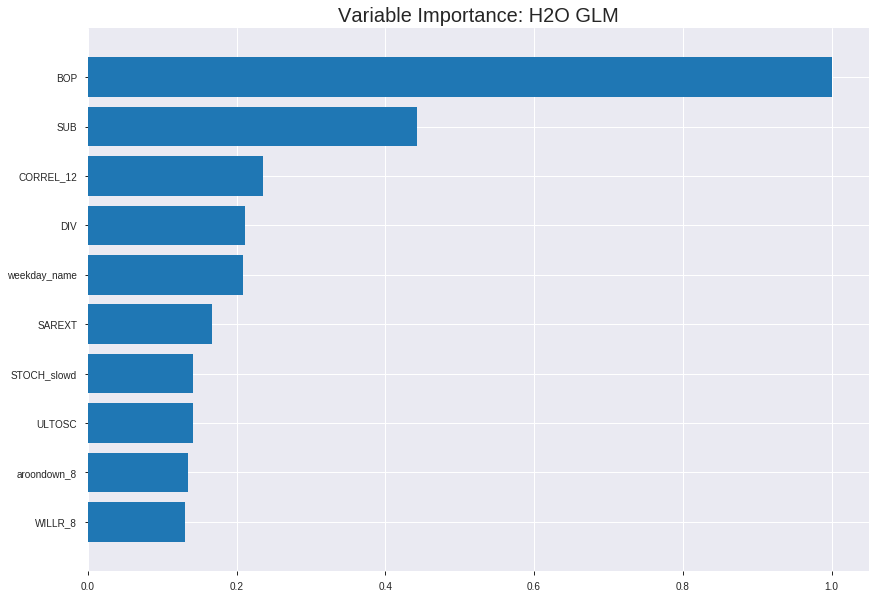

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_161345_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19383820975334992
RMSE: 0.44027060968607695
LogLoss: 0.5695428145810378
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.758140071244
Residual deviance: 1996.8171079211188
AIC: 2098.817107921119
AUC: 0.7738207455049669
pr_auc: 0.7704661272513659
Gini: 0.5476414910099339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37512342639300905: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      440  423   0.4902   (423.0/863.0)
1      117  773   0.1315   (117.0/890.0)
Total  557  1196  0.308    (540.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375123     0.741131  257
max f2                       0.205896     0.848337  339
max f0point5                 0.600034     0.708837  152
max accuracy                 0.477829     0.703936  209
max precision                0.938415     1         0
max recall                   0.0848372    1         389
max specificity              0.938415     1         0
max absolute_mcc             0.423788     0.411045  234
max min_per_class_accuracy   0.538807     0.688764  181
max mean_per_class_accuracy  0.477829     0.70289   209

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.885447           1.96966   1.96966            1                0.900691  1                           0.900691            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.870082           1.86024   1.91495            0.944444         0.877579  0.972222                    0.889135            0.0191011       0.0393258                  86.0237   91.495
    3        0.0302339                   0.856595           1.8538    1.89534            0.941176         0.862084  0.962264                    0.880458            0.0179775       0.0573034                  85.38     89.5336
    4        0.040502                    0.840958           1.86024   1.88644            0.944444         0.848526  0.957746                    0.872363            0.0191011       0.0764045                  86.0237   88.6438
    5        0.0501997                   0.829213           1.50621   1.81299            0.764706         0.836217  0.920455                    0.86538             0.0146067       0.0910112                  50.6213   81.2985
    6        0.100399                    0.786312           1.61154   1.71226            0.818182         0.804637  0.869318                    0.835009            0.0808989       0.17191                    61.1542   71.2264
    7        0.150029                    0.754681           1.63007   1.68507            0.827586         0.769246  0.855513                    0.813255            0.0808989       0.252809                   63.0066   68.5073
    8        0.200228                    0.725651           1.52201   1.64419            0.772727         0.740638  0.834758                    0.795049            0.0764045       0.329213                   52.2012   64.4192
    9        0.300057                    0.666158           1.36188   1.55027            0.691429         0.697047  0.787072                    0.762444            0.135955        0.465169                   36.1881   55.0267
    10       0.399886                    0.60859            1.20431   1.4639             0.611429         0.63691   0.743224                    0.731105            0.120225        0.585393                   20.4308   46.3901
    11       0.500285                    0.538464           1.01841   1.3745             0.517045         0.575622  0.697834                    0.699902            0.102247        0.68764                    1.84053   37.4497
    12       0.600114                    0.443284           1.0805    1.32559            0.548571         0.492847  0.673004                    0.665459            0.107865        0.795506                   8.05008   32.5591
    13       0.699943                    0.355111           0.821631  1.25371            0.417143         0.399291  0.636512                    0.627497            0.0820225       0.877528                   -17.8369  25.3714
    14       0.799772                    0.274933           0.596526  1.17168            0.302857         0.316838  0.594864                    0.58872             0.0595506       0.937079                   -40.3474  17.1683
    15       0.899601                    0.191986           0.405188  1.08662            0.205714         0.232719  0.55168                     0.549214            0.0404494       0.977528                   -59.4812  8.66244
    16       1                           0.0474245          0.223825  1                  0.113636         0.135735  0.507701                    0.507701          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20157569754114668
RMSE: 0.4489718226583342
LogLoss: 0.5885109768932965
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.6357161682504
Residual deviance: 589.687998847083
AIC: 691.687998847083
AUC: 0.7516885943852236
pr_auc: 0.7467997306061048
Gini: 0.5033771887704472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3043433639765982: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   142  0.6068   (142.0/234.0)
1      18   249  0.0674   (18.0/267.0)
Total  110  391  0.3194   (160.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304343     0.756839  305
max f2                       0.187906     0.860495  368
max f0point5                 0.591359     0.727595  168
max accuracy                 0.591359     0.692615  168
max precision                0.928232     1         0
max recall                   0.117618     1         388
max specificity              0.928232     1         0
max absolute_mcc             0.591359     0.399454  168
max min_per_class_accuracy   0.54685      0.681648  194
max mean_per_class_accuracy  0.591359     0.698142  168

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.887548           1.56367   1.56367            0.833333         0.907422  0.833333                    0.907422            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.872681           1.50112   1.53524            0.8              0.878561  0.818182                    0.894304            0.0149813       0.0337079                  50.1124   53.524
    3        0.0319361                   0.856935           1.50112   1.52458            0.8              0.863594  0.8125                      0.884707            0.0149813       0.0486891                  50.1124   52.4579
    4        0.0419162                   0.843309           1.8764    1.60835            1                0.847289  0.857143                    0.875798            0.0187266       0.0674157                  87.6404   60.8347
    5        0.0518962                   0.83289            1.8764    1.6599             1                0.836515  0.884615                    0.868243            0.0187266       0.0861423                  87.6404   65.9896
    6        0.101796                    0.79192            1.50112   1.58207            0.8              0.808731  0.843137                    0.839071            0.0749064       0.161049                   50.1124   58.2067
    7        0.151697                    0.761839           1.35101   1.50606            0.72             0.77351   0.802632                    0.817505            0.0674157       0.228464                   35.1011   50.6062
    8        0.201597                    0.736093           1.50112   1.50484            0.8              0.750569  0.80198                     0.800936            0.0749064       0.303371                   50.1124   50.4839
    9        0.301397                    0.671335           1.4636    1.49118            0.78             0.698275  0.794702                    0.766942            0.146067        0.449438                   46.3596   49.1182
    10       0.401198                    0.610482           1.27596   1.43764            0.68             0.643224  0.766169                    0.736167            0.127341        0.576779                   27.5955   43.7643
    11       0.500998                    0.54998            0.938202  1.33815            0.5              0.578497  0.713147                    0.704758            0.093633        0.670412                   -6.17978  33.8153
    12       0.600798                    0.462397           0.78809   1.24678            0.42             0.494706  0.664452                    0.669866            0.0786517       0.749064                   -21.191   24.678
    13       0.700599                    0.376794           1.01326   1.21352            0.54             0.422298  0.646724                    0.6346              0.101124        0.850187                   1.32584   21.3515
    14       0.800399                    0.289296           0.863146  1.16983            0.46             0.331738  0.623441                    0.596837            0.0861423       0.93633                    -13.6854  16.9828
    15       0.9002                      0.216776           0.375281  1.08174            0.2              0.256072  0.576497                    0.559058            0.0374532       0.973783                   -62.4719  8.1741
    16       1                           0.0827738          0.262697  1                  0.14             0.154944  0.532934                    0.518727            0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 16:13:45  0.000 sec   2            .22E2     50            1.369286451383421   1.3689664393080818
     2019-08-27 16:13:45  0.012 sec   4            .14E2     51            1.3606167211812277  1.3609360891860507
     2019-08-27 16:13:45  0.025 sec   6            .84E1     51            1.3484951241588545  1.349708651817747
     2019-08-27 16:13:45  0.039 sec   8            .52E1     51            1.3324511041096696  1.3348451458200932
     2019-08-27 16:13:45  0.051 sec   10           .33E1     51            1.312526028549876   1.316377220795824
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 16:13:45  0.210 sec   34           .11E-1    51            1.135292959627974   1.1776463607634096
     2019-08-27 16:13:45  0.222 sec   36           .66E-2    51            1.132670885471178   1.1792077588301648
     2019-08-27 16:13:45  0.234 sec   38           .41E-2    51            1.1309464713680555  1.181218736369635
     2019-08-27 16:13:45  0.247 sec   40           .26E-2    51            1.1298475149199725  1.1833462195625135
     2019-08-27 16:13:45  0.260 sec   42           .16E-2    51            1.1291436101534074  1.1853274904611695


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.6206896551724137)

('auc', 0.7017543859649124)

('logloss', 0.6288741483186301)

('mean_per_class_error', 0.3355927698032961)

('rmse', 0.46868142210291364)

('mse', 0.2196622754244095)

glm prediction progress: |████████████████████████████████████████████████| 100%


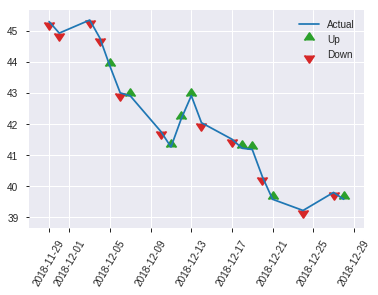


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2196622754244095
RMSE: 0.46868142210291364
LogLoss: 0.6288741483186301
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.6521945213129
Residual deviance: 315.6948224559523
AIC: 417.6948224559523
AUC: 0.7017543859649124
pr_auc: 0.574431370718296
Gini: 0.4035087719298247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29952332124071845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   101  0.6645   (101.0/152.0)
1      9    90   0.0909   (9.0/99.0)
Total  60   191  0.4382   (110.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299523     0.62069   190
max f2                       0.191266     0.784469  234
max f0point5                 0.576249     0.599572  91
max accuracy                 0.602251     0.685259  79
max precision                0.832305     0.75      11
max recall                   0.191266     1         234
max specificity              0.892901     0.993421  0
max absolute_mcc             0.576249     0.333502  91
max min_per_class_accuracy   0.504953     0.636364  116
max mean_per_class_accuracy  0.576249     0.664407  91

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.8648             1.69024   1.69024            0.666667         0.876418  0.666667                    0.876418            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.861441           1.69024   1.69024            0.666667         0.863219  0.666667                    0.869818            0.020202        0.040404                   69.0236   69.0236
    3        0.0318725                   0.856302           1.26768   1.5846             0.5              0.858689  0.625                       0.867036            0.010101        0.0505051                  26.7677   58.4596
    4        0.0438247                   0.836089           2.53535   1.84389            1                0.846191  0.727273                    0.861351            0.030303        0.0808081                  153.535   84.3893
    5        0.0517928                   0.812618           1.26768   1.75524            0.5              0.823918  0.692308                    0.855592            0.010101        0.0909091                  26.7677   75.5245
    6        0.103586                    0.758502           1.56022   1.65773            0.615385         0.777876  0.653846                    0.816734            0.0808081       0.171717                   56.0218   65.7731
    7        0.151394                    0.719692           1.69024   1.668              0.666667         0.733128  0.657895                    0.790332            0.0808081       0.252525                   69.0236   66.7996
    8        0.203187                    0.683795           1.56022   1.64052            0.615385         0.700265  0.647059                    0.767374            0.0808081       0.333333                   56.0218   64.0523
    9        0.302789                    0.607005           1.4198    1.56792            0.56             0.645592  0.618421                    0.727314            0.141414        0.474747                   41.9798   56.7916
    10       0.40239                     0.551604           1.11556   1.45595            0.44             0.582533  0.574257                    0.691477            0.111111        0.585859                   11.5556   45.5946
    11       0.501992                    0.48234            0.709899  1.30792            0.28             0.51619   0.515873                    0.656698            0.0707071       0.656566                   -29.0101  30.792
    12       0.601594                    0.394269           1.11556   1.27607            0.44             0.433564  0.503311                    0.619755            0.111111        0.767677                   11.5556   27.6072
    13       0.701195                    0.341807           0.709899  1.19565            0.28             0.363744  0.471591                    0.58339             0.0707071       0.838384                   -29.0101  19.565
    14       0.800797                    0.282206           0.912727  1.16046            0.36             0.305835  0.457711                    0.548868            0.0909091       0.929293                   -8.72727  16.046
    15       0.900398                    0.220221           0.405657  1.07696            0.16             0.253018  0.424779                    0.516141            0.040404        0.969697                   -59.4343  7.69643
    16       1                           0.0751808          0.304242  1                  0.12             0.160702  0.394422                    0.480739            

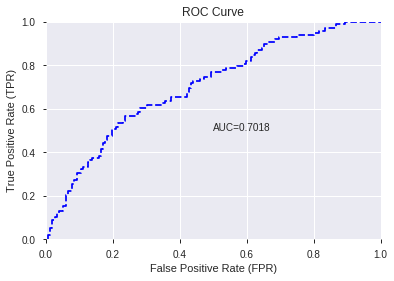

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


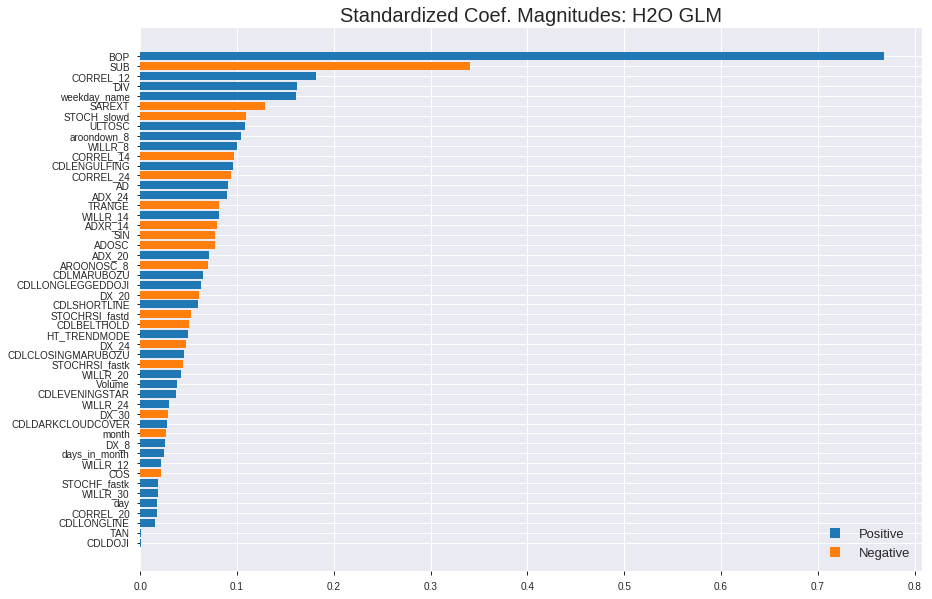

'log_likelihood'
--2019-08-27 16:13:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


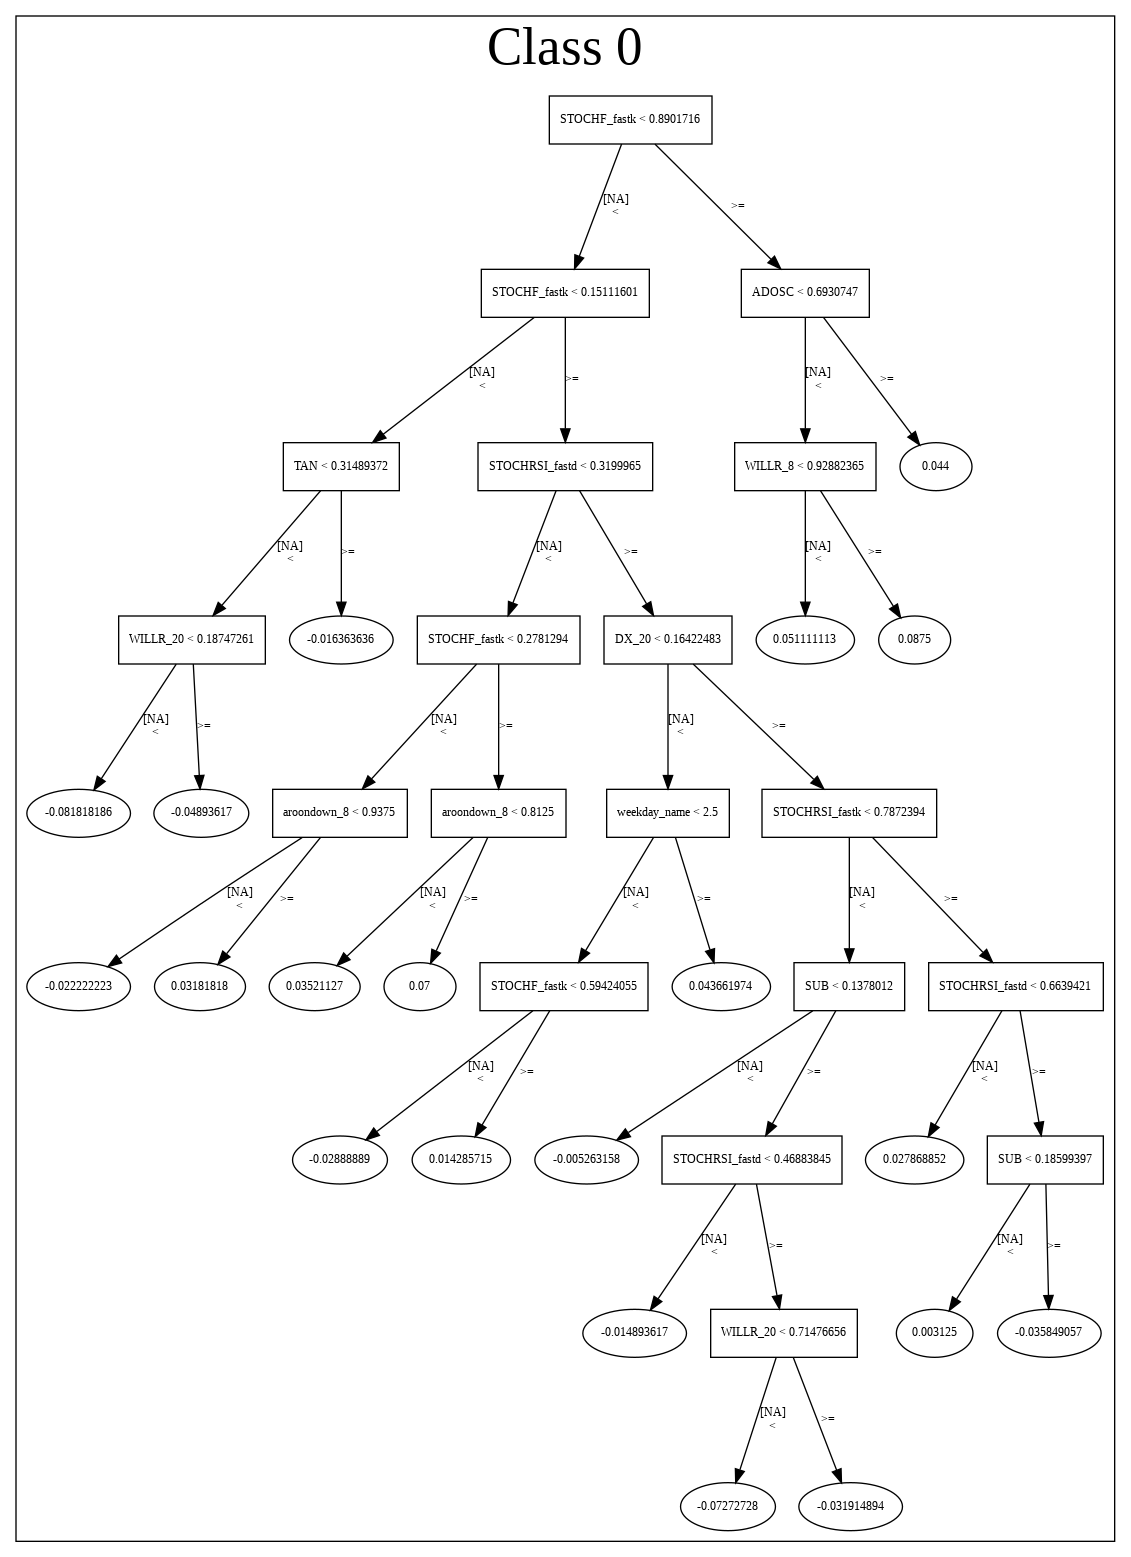

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_161345_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_161345_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'CORREL_12',
 'DIV',
 'weekday_name',
 'SAREXT',
 'STOCH_slowd',
 'ULTOSC',
 'aroondown_8',
 'WILLR_8',
 'CORREL_14',
 'CDLENGULFING',
 'CORREL_24',
 'AD',
 'ADX_24',
 'TRANGE',
 'WILLR_14',
 'ADXR_14',
 'SIN',
 'ADOSC',
 'ADX_20',
 'AROONOSC_8',
 'CDLMARUBOZU',
 'CDLLONGLEGGEDDOJI',
 'DX_20',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'DX_24',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'WILLR_20',
 'Volume',
 'CDLEVENINGSTAR',
 'WILLR_24',
 'DX_30',
 'CDLDARKCLOUDCOVER',
 'month',
 'DX_8',
 'days_in_month',
 'WILLR_12',
 'COS',
 'STOCHF_fastk',
 'WILLR_30',
 'day',
 'CORREL_20',
 'CDLLONGLINE',
 'TAN',
 'CDLDOJI']

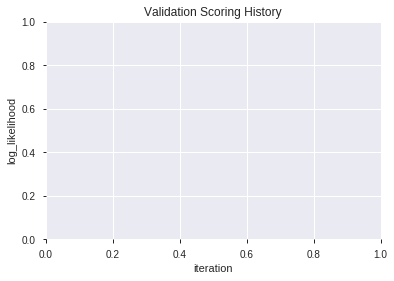

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_161401  0.708466  0.638485              0.347854  0.473534  0.224235
1  XGBoost_grid_1_AutoML_20190827_161401_model_4  0.708068  0.629141              0.363703  0.469076  0.220033
2               XGBoost_3_AutoML_20190827_161401  0.706473  0.638295              0.375698  0.474298  0.224959
3               XGBoost_1_AutoML_20190827_161401  0.692584  0.649028              0.371112  0.479013  0.229454
4  XGBoost_grid_1_AutoML_20190827_161401_model_5  0.687267  0.672417              0.374867  0.488614  0.238744
5  XGBoost_grid_1_AutoML_20190827_161401_model_2  0.679359  0.656107              0.354532  0.482205  0.232521
6  XGBoost_grid_1_AutoML_20190827_161401_model_1  0.678695  0.657530              0.374635  0.483514  0.233785
7  XGBoost_grid_1_AutoML_20190827_161401_model_6  0.673312  0.662072              0.362872  0.484312  0.234558
8  XGBoost_grid_1_AutoML_20190827_161401_model_3  0.667065  0.666739              0.377093  0.487719  0.237870
9  XGBoost_grid_1_AutoML_20190827_161401_model_7  0.664341  0.680931              0.395069  0.493123  0.243170

variable  relative_importance  scaled_importance  percentage
0              BOP          2016.542358           1.000000    0.274420
1     STOCHF_fastk           404.204193           0.200444    0.055006
2              SUB           332.167969           0.164722    0.045203
3   STOCHRSI_fastk           238.606506           0.118325    0.032471
4          WILLR_8           234.026123           0.116053    0.031847
5           TRANGE           210.115082           0.104196    0.028593
6   STOCHRSI_fastd           193.105408           0.095761    0.026279
7      STOCH_slowd           184.053391           0.091272    0.025047
8              TAN           179.461151           0.088994    0.024422
9         WILLR_20           172.849625           0.085716    0.023522
10    weekday_name           164.106628           0.081380    0.022332
11          SAREXT           162.610703           0.080638    0.022129
12             DIV           157.781525           0.078244    0.021472
13        WILLR_14           156.901154           0.077807    0.021352
14           DX_24           153.699097           0.076219    0.020916
15       CORREL_20           152.058990           0.075406    0.020693
16           DX_20           144.024353           0.071421    0.019600
17          ADX_24           141.066315           0.069955    0.019197
18             SIN           134.126709           0.066513    0.018253
19          ULTOSC           132.218124           0.065567    0.017993
20              AD           128.052124           0.063501    0.017426
21        WILLR_12           125.699066           0.062334    0.017106
22             COS           115.475830           0.057264    0.015714
23       CORREL_12           113.291801           0.056181    0.015417
24           DX_30           112.170883           0.055625    0.015265
25       CORREL_24           106.845062           0.052984    0.014540
26             day           104.618042           0.051880    0.014237
27           ADOSC           104.221375           0.051683    0.014183
28       CORREL_14            98.066589           0.048631    0.013345
29        WILLR_30            92.852448           0.046045    0.012636
30         ADXR_14            84.555702           0.041931    0.011507
31          ADX_20            80.427185           0.039884    0.010945
32     aroondown_8            70.733215           0.035076    0.009626
33            DX_8            70.372223           0.034897    0.009577
34      AROONOSC_8            62.663414           0.031075    0.008528
35          Volume            53.758869           0.026659    0.007316
36           month            53.376812           0.026469    0.007264
37        WILLR_24            45.437653           0.022532    0.006183
38     CDLLONGLINE            17.805962           0.008830    0.002423
39   days_in_month            17.711821           0.008783    0.002410
40    CDLSHORTLINE            16.011461           0.007940    0.002179
41    HT_TRENDMODE             6.459501           0.003203    0.000879
42         CDLDOJI             4.034752           0.002001    0.000549

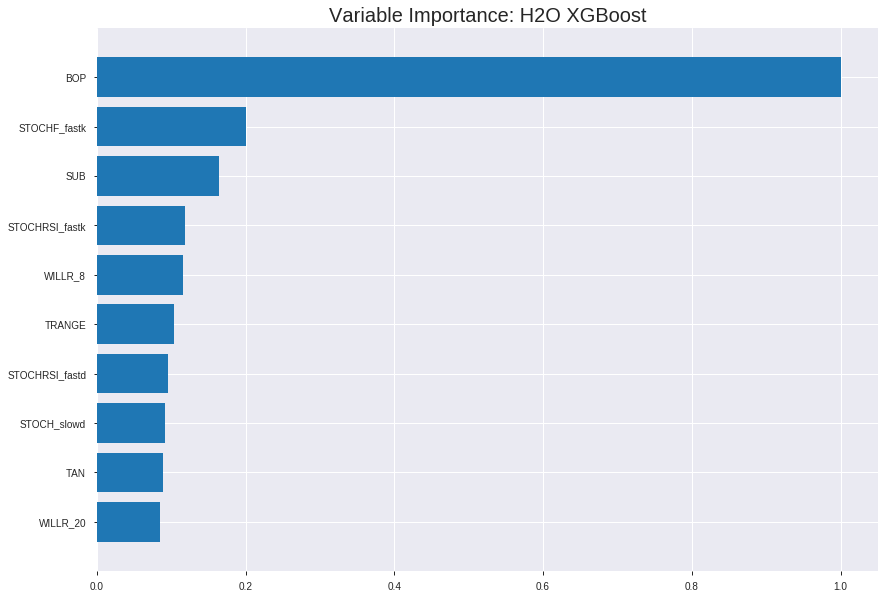

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_161401


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14522059843532853
RMSE: 0.3810782051434174
LogLoss: 0.45897220993750915
Mean Per-Class Error: 0.1878715481661828
AUC: 0.8948761180621558
pr_auc: 0.8982042277457161
Gini: 0.7897522361243117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4870515465736389: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      655  208  0.241    (208.0/863.0)
1      130  760  0.1461   (130.0/890.0)
Total  785  968  0.1928   (338.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487052     0.818084  209
max f2                       0.30937      0.887793  291
max f0point5                 0.592428     0.834209  159
max accuracy                 0.539532     0.811751  184
max precision                0.927003     1         0
max recall                   0.147969     1         368
max specificity              0.927003     1         0
max absolute_mcc             0.539532     0.624667  184
max min_per_class_accuracy   0.520063     0.807648  193
max mean_per_class_accuracy  0.539532     0.812128  184

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.88148            1.96966    1.96966            1                0.897254  1                           0.897254            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.874264           1.96966    1.96966            1                0.878034  1                           0.887644            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.866786           1.96966    1.96966            1                0.869626  1                           0.881864            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.859455           1.96966    1.96966            1                0.862711  1                           0.877009            0.0202247       0.0797753                  96.9663   96.9663
    5        0.0501997                   0.848856           1.96966    1.96966            1                0.853405  1                           0.872449            0.0191011       0.0988764                  96.9663   96.9663
    6        0.100399                    0.809729           1.9249     1.94728            0.977273         0.828136  0.988636                    0.850292            0.0966292       0.195506                   92.4898   94.728
    7        0.150029                    0.775722           1.83382    1.90975            0.931034         0.79324   0.969582                    0.83142             0.0910112       0.286517                   83.3824   90.9749
    8        0.200228                    0.741167           1.83537    1.8911             0.931818         0.760635  0.960114                    0.813673            0.0921348       0.378652                   83.5368   89.1101
    9        0.300057                    0.672564           1.65452    1.81239            0.84             0.706818  0.920152                    0.778122            0.165169        0.54382                    65.4517   81.2389
    10       0.399886                    0.603775           1.46318    1.72521            0.742857         0.641297  0.875892                    0.743965            0.146067        0.689888                   46.3178   72.5211
    11       0.500285                    0.524953           1.11913    1.60358            0.568182         0.563695  0.814139                    0.707788            0.11236         0.802247                   11.9127   60.358
    12       0.600114                    0.449743           0.810376   1.47163            0.411429         0.486763  0.747148                    0.67102             0.0808989       0.883146                   -18.9624  47.163
    13       0.699943                    0.353635           0.686568   1.35966            0.348571         0.403625  0.690302                    0.632883            0.0685393       0.951685                   -31.3432  35.9661
    14       0.799772                    0.255567           0.292636   1.22647            0.148571         0.303329  0.622682                    0.591748            0.0292135       0.980899                   -70.7364  22.6473
    15       0.899601                    0.173229           0.157573   1.10786            0.08             0.215006  0.56246                     0.549941            0.0157303       0.996629                   -84.2427  10.7857
    16       1                           0.0549382          0.0335738  1                  0.0170455        0.129966  0.507701                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1993551086437061
RMSE: 0.4464920028888604
LogLoss: 0.5833369299349388
Mean Per-Class Error: 0.29672044559685007
AUC: 0.756570312750088
pr_auc: 0.7574435551875186
Gini: 0.513140625500176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3536398410797119: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  132  0.5641   (132.0/234.0)
1      28   239  0.1049   (28.0/267.0)
Total  130  371  0.3194   (160.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35364      0.749216  288
max f2                       0.193364     0.862295  363
max f0point5                 0.556684     0.72549   192
max accuracy                 0.556684     0.702595  192
max precision                0.918503     1         0
max recall                   0.114824     1         396
max specificity              0.918503     1         0
max absolute_mcc             0.556684     0.405683  192
max min_per_class_accuracy   0.550072     0.696629  194
max mean_per_class_accuracy  0.556684     0.70328   192

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 53.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.882692           1.56367   1.56367            0.833333         0.89927   0.833333                    0.89927             0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.872818           1.8764    1.70582            1                0.877047  0.909091                    0.889169            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.86226            1.8764    1.75913            1                0.866882  0.9375                      0.882204            0.0187266       0.0561798                  87.6404   75.9129
    4        0.0419162                   0.855804           1.50112   1.6977             0.8              0.858086  0.904762                    0.876462            0.0149813       0.071161                   50.1124   69.7699
    5        0.0518962                   0.845881           1.50112   1.6599             0.8              0.850624  0.884615                    0.871493            0.0149813       0.0861423                  50.1124   65.9896
    6        0.101796                    0.812221           1.50112   1.58207            0.8              0.828202  0.843137                    0.850272            0.0749064       0.161049                   50.1124   58.2067
    7        0.151697                    0.773396           1.42607   1.53075            0.76             0.789955  0.815789                    0.830431            0.071161        0.23221                    42.6067   53.0751
    8        0.201597                    0.752652           1.42607   1.50484            0.76             0.763454  0.80198                     0.813852            0.071161        0.303371                   42.6067   50.4839
    9        0.301397                    0.694436           1.50112   1.50361            0.8              0.724526  0.801325                    0.784274            0.149813        0.453184                   50.1124   50.3609
    10       0.401198                    0.62982            1.2009    1.42831            0.64             0.655988  0.761194                    0.752362            0.11985         0.573034                   20.0899   42.8308
    11       0.500998                    0.556627           1.2009    1.38301            0.64             0.591603  0.737052                    0.720339            0.11985         0.692884                   20.0899   38.3007
    12       0.600798                    0.475338           0.675506  1.26548            0.36             0.51668   0.674419                    0.686508            0.0674157       0.7603                     -32.4494  26.5482
    13       0.700599                    0.405511           0.900674  1.21352            0.48             0.436831  0.646724                    0.650942            0.0898876       0.850187                   -9.93258  21.3515
    14       0.800399                    0.3094             0.825618  1.16515            0.44             0.349659  0.620948                    0.613375            0.082397        0.932584                   -17.4382  16.5149
    15       0.9002                      0.201417           0.450337  1.0859             0.24             0.259311  0.578714                    0.574122            0.0449438       0.977528                   -54.9663  8.59015
    16       1                           0.0863657          0.225169  1                  0.12             0.159704  0.532934                    0.532763          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:14:04  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-27 16:14:04  0.057 sec   5                  0.477657         0.64923             0.812669        0.801941           1.7727           0.279521                         0.482746           0.659061              0.74864           0.752612             1.8764             0.331337
    2019-08-27 16:14:04  0.106 sec   10                 0.458715         0.6127              0.832088        0.829498           1.96966          0.270394                         0.471462           0.636865              0.746759          0.749669             1.8764             0.345309
    2019-08-27 16:14:04  0.162 sec   15                 0.443611         0.583493            0.840259        0.841914           1.96966          0.261266                         0.462178           0.618398              0.751056          0.753137             1.8764             0.331337
    2019-08-27 16:14:04  0.214 sec   20                 0.432658         0.562031            0.845934        0.846966           1.96966          0.254421                         0.456683           0.607155              0.753761          0.750521             1.56367            0.295409
    2019-08-27 16:14:04  0.268 sec   25                 0.423483         0.543678            0.851757        0.854403           1.96966          0.25328                          0.452767           0.598788              0.75589           0.75569              1.56367            0.333333
    2019-08-27 16:14:04  0.323 sec   30                 0.416004         0.528354            0.855407        0.859528           1.96966          0.251569                         0.449823           0.592477              0.757715          0.753881             1.56367            0.317365
    2019-08-27 16:14:04  0.384 sec   35                 0.409711         0.515601            0.861633        0.866384           1.96966          0.252139                         0.449269           0.59084               0.754706          0.751495             1.56367            0.313373
    2019-08-27 16:14:04  0.442 sec   40                 0.40389          0.504161            0.869181        0.874611           1.96966          0.250428                         0.448053           0.587904              0.75609           0.757973             1.8764             0.311377
    2019-08-27 16:14:04  0.514 sec   45                 0.39887          0.493741            0.873505        0.879405           1.96966          0.236737                         0.447739           0.586901              0.75557           0.758585             1.8764             0.317365
    2019-08-27 16:14:04  0.573 sec   50                 0.394303         0.484375            0.878413        0.884789           1.96966          0.232744                         0.446174           0.583429              0.758787          0.760998             1.8764             0.323353
    2019-08-27 16:14:04  0.637 sec   55                 0.389662         0.475123            0.883284        0.887513           1.96966          0.222476                         0.445943           0.582261              0.758739          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2016.5423583984375     1.0                    0.2744204671927109
STOCHF_fastk    404.2041931152344      0.20044418676940576    0.055005987379323336
SUB             332.16796875           0.1647215429750813     0.04520296277992602
STOCHRSI_fastk  238.60650634765625     0.11832456945618561    0.032470683630542826
WILLR_8         234.026123046875       0.1160531649990935     0.031847363758244006
---             ---                    ---                    ---
CDLLONGLINE     17.80596160888672      0.008829946732697661   0.0024231181076736436
days_in_month   17.711820602416992     0.008783262364240112   0.0024103069614709264
CDLSHORTLINE    16.01146125793457      0.007940056994712012   0.0021789141500256222
HT_TRENDMODE    6.459501266479492      0.0032032559294264996  0.0008790389886910414
CDLDOJI         4.034752368927002      0.002000826985916354   0.0005490678762469495


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.6433566433566434)

('auc', 0.7084662413609782)

('logloss', 0.638485252103263)

('mean_per_class_error', 0.34220494417862835)

('rmse', 0.473534295610618)

('mse', 0.22423472911944417)

xgboost prediction progress: |████████████████████████████████████████████| 100%


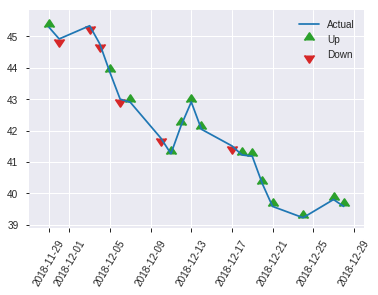


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22423472911944417
RMSE: 0.473534295610618
LogLoss: 0.638485252103263
Mean Per-Class Error: 0.34220494417862835
AUC: 0.7084662413609782
pr_auc: 0.599310609723768
Gini: 0.4169324827219565
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38370534777641296: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   95   0.625    (95.0/152.0)
1      7    92   0.0707   (7.0/99.0)
Total  64   187  0.4064   (102.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383705     0.643357  186
max f2                       0.281126     0.793269  227
max f0point5                 0.636989     0.590361  78
max accuracy                 0.636989     0.681275  78
max precision                0.902444     1         0
max recall                   0.281126     1         227
max specificity              0.902444     1         0
max absolute_mcc             0.383705     0.341209  186
max min_per_class_accuracy   0.541341     0.611842  119
max mean_per_class_accuracy  0.44105      0.657795  164

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 52.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.87726            2.53535   2.53535            1                0.889117  1                           0.889117            0.030303        0.030303                   153.535   153.535
    2        0.0239044                   0.841525           2.53535   2.53535            1                0.85782   1                           0.873468            0.030303        0.0606061                  153.535   153.535
    3        0.0318725                   0.829094           0         1.90152            0                0.835281  0.75                        0.863921            0               0.0606061                  -100      90.1515
    4        0.0438247                   0.816661           2.53535   2.07438            1                0.819684  0.818182                    0.851857            0.030303        0.0909091                  153.535   107.438
    5        0.0517928                   0.811462           1.26768   1.95027            0.5              0.815392  0.769231                    0.846247            0.010101        0.10101                    26.7677   95.0272
    6        0.103586                    0.776193           1.56022   1.75524            0.615385         0.793083  0.692308                    0.819665            0.0808081       0.181818                   56.0218   75.5245
    7        0.151394                    0.736151           1.26768   1.60128            0.5              0.75459   0.631579                    0.799115            0.0606061       0.242424                   26.7677   60.1276
    8        0.203187                    0.69133            1.36519   1.5411             0.538462         0.705098  0.607843                    0.77515             0.0707071       0.313131                   36.519    54.1097
    9        0.302789                    0.646886           1.52121   1.53456            0.6              0.668502  0.605263                    0.740068            0.151515        0.464646                   52.1212   53.4556
    10       0.40239                     0.572507           0.709899  1.33043            0.28             0.602882  0.524752                    0.706111            0.0707071       0.535354                   -29.0101  33.0433
    11       0.501992                    0.530554           1.31838   1.32804            0.52             0.547335  0.52381                     0.674608            0.131313        0.666667                   31.8384   32.8042
    12       0.601594                    0.474691           1.21697   1.30965            0.48             0.494452  0.516556                    0.644781            0.121212        0.787879                   21.697    30.9653
    13       0.701195                    0.410368           0.912727  1.25327            0.36             0.44478   0.494318                    0.616372            0.0909091       0.878788                   -8.72727  25.3271
    14       0.800797                    0.343707           0.608485  1.17307            0.24             0.377193  0.462687                    0.586623            0.0606061       0.939394                   -39.1515  17.3074
    15       0.900398                    0.283206           0.507071  1.0994             0.2              0.318358  0.433628                    0.556948            0.0505051       0.989899                   -49.2929  9.94011
    16       1                           0.147              0.101414  1                  0.04             0.232756  0.394422                    0.524658         

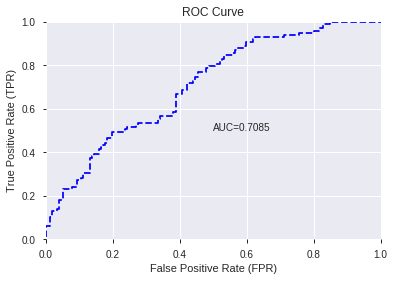

This function is available for GLM models only


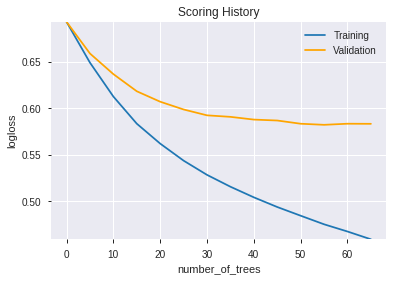

--2019-08-27 16:14:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


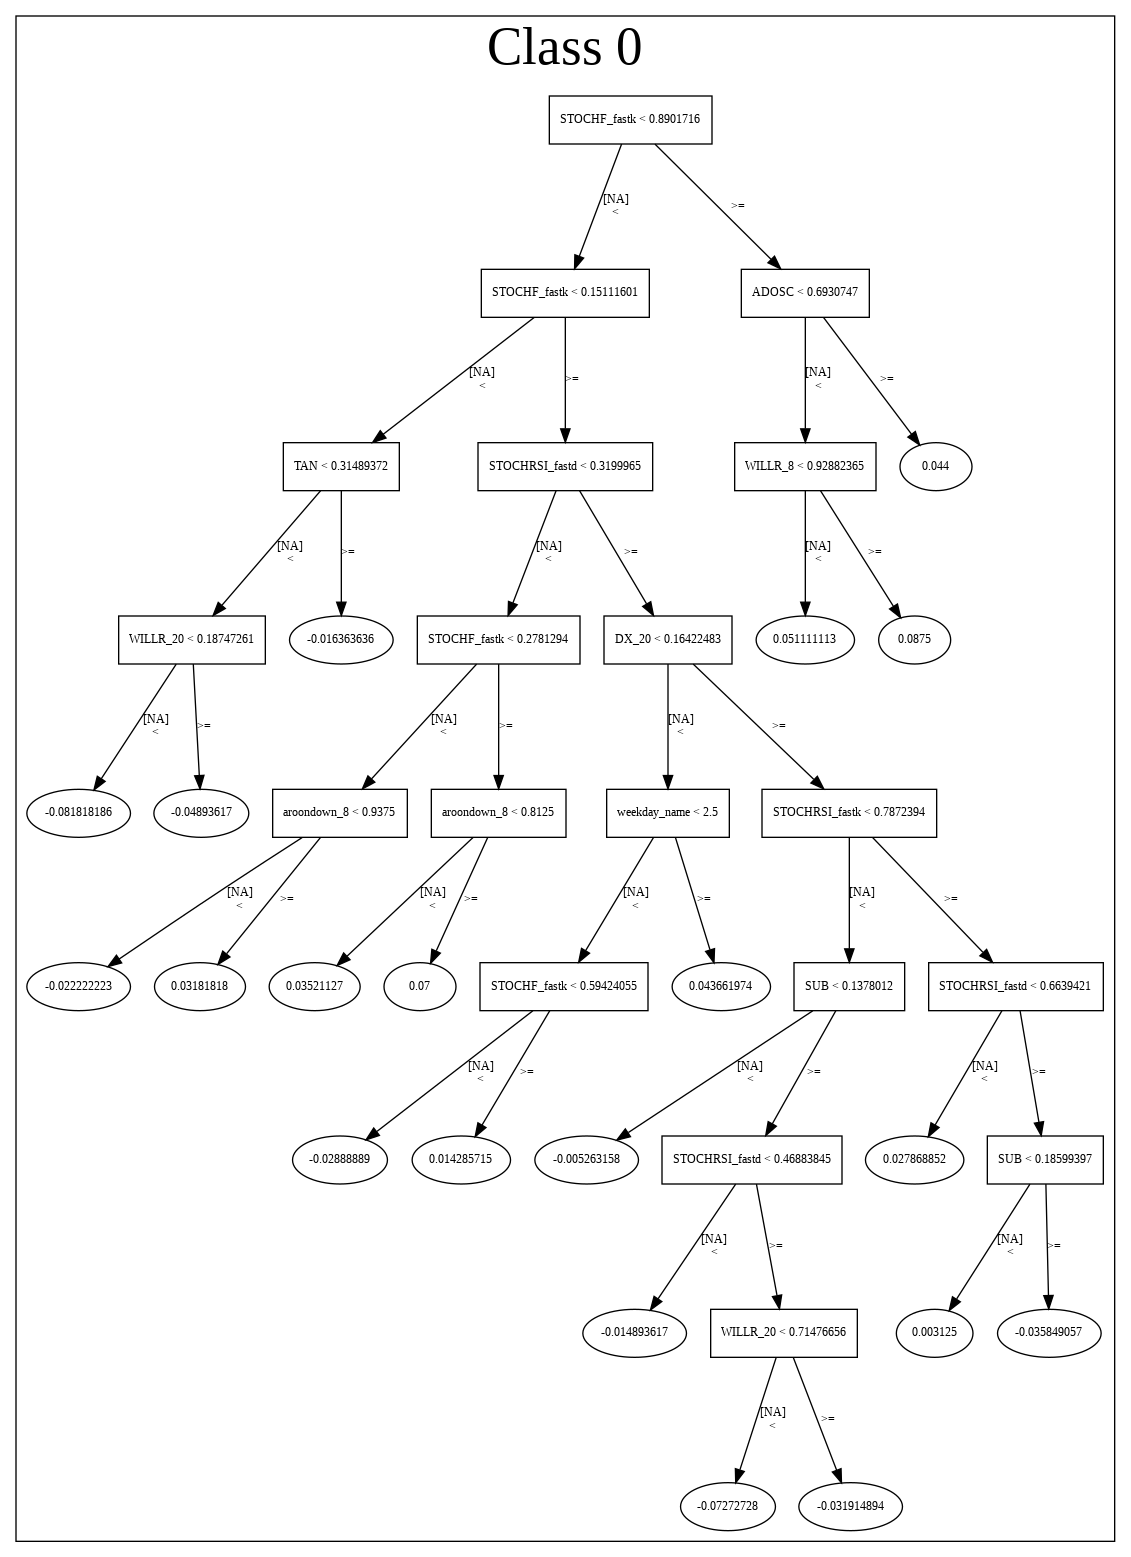

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_161401',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_161401',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_b362',
   'type

['BOP',
 'STOCHF_fastk',
 'SUB',
 'STOCHRSI_fastk',
 'WILLR_8',
 'TRANGE',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'TAN',
 'WILLR_20',
 'weekday_name',
 'SAREXT',
 'DIV',
 'WILLR_14',
 'DX_24',
 'CORREL_20',
 'DX_20',
 'ADX_24',
 'SIN',
 'ULTOSC',
 'AD',
 'WILLR_12',
 'COS',
 'CORREL_12',
 'DX_30',
 'CORREL_24',
 'day',
 'ADOSC',
 'CORREL_14',
 'WILLR_30',
 'ADXR_14',
 'ADX_20',
 'aroondown_8',
 'DX_8',
 'AROONOSC_8',
 'Volume',
 'month',
 'WILLR_24',
 'CDLLONGLINE',
 'days_in_month',
 'CDLSHORTLINE',
 'HT_TRENDMODE',
 'CDLDOJI']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [896 918] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


32

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_161438_model_6  0.714314  0.651811              0.367590  0.479523  0.229943
1  DeepLearning_grid_1_AutoML_20190827_161438_model_9  0.699827  0.650951              0.408360  0.480490  0.230871
2  DeepLearning_grid_1_AutoML_20190827_161438_model_8  0.698631  0.674854              0.333732  0.488583  0.238713
3  DeepLearning_grid_1_AutoML_20190827_161438_model_3  0.695707  0.702952              0.419757  0.492972  0.243021
4               DeepLearning_1_AutoML_20190827_161438  0.694245  0.640568              0.368288  0.474227  0.224891
5  DeepLearning_grid_1_AutoML_20190827_161438_model_4  0.692517  0.687174              0.326788  0.482072  0.232394
6  DeepLearning_grid_1_AutoML_20190827_161438_model_1  0.690590  0.775690              0.354300  0.498303  0.248306
7  DeepLearning_grid_1_AutoML_20190827_161438_model_5  0.684510  0.696889              0.329844  0.501560  0.251563
8  DeepLearning_grid_1_AutoML_20190827_161438_model_2  0.669059  0.734462              0.411649  0.497207  0.247215
9  DeepLearning_grid_1_AutoML_20190827_161438_model_7  0.653841  0.773978              0.396598  0.515394  0.265631

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.070262
1         CDLSHORTLINE             0.620520           0.620520    0.043599
2                  SUB             0.547744           0.547744    0.038485
3          CDLLONGLINE             0.536553           0.536553    0.037699
4   CDLCLOSINGMARUBOZU             0.506430           0.506430    0.035583
5               TRANGE             0.483417           0.483417    0.033966
6         CDLENGULFING             0.471756           0.471756    0.033146
7         STOCHF_fastk             0.449539           0.449539    0.031585
8                CCI_8             0.439256           0.439256    0.030863
9       STOCHRSI_fastk             0.437750           0.437750    0.030757
10         CDLBELTHOLD             0.425217           0.425217    0.029876
11              ULTOSC             0.413125           0.413125    0.029027
12            WILLR_14             0.408399           0.408399    0.028695
13              RSI_14             0.408194           0.408194    0.028680
14               ADOSC             0.406400           0.406400    0.028554
15              CCI_14             0.405941           0.405941    0.028522
16              CMO_14             0.399712           0.399712    0.028084
17            WILLR_20             0.399674           0.399674    0.028082
18             WILLR_8             0.398927           0.398927    0.028029
19              CMO_20             0.398606           0.398606    0.028007
20              CCI_12             0.396233           0.396233    0.027840
21            WILLR_24             0.395863           0.395863    0.027814
22         CDLMARUBOZU             0.395150           0.395150    0.027764
23              CMO_12             0.395064           0.395064    0.027758
24            WILLR_30             0.393534           0.393534    0.027650
25            WILLR_12             0.391947           0.391947    0.027539
26              CMO_24             0.391085           0.391085    0.027478
27              RSI_24             0.388924           0.388924    0.027326
28               RSI_8             0.387814           0.387814    0.027248
29              RSI_20             0.385600           0.385600    0.027093
30               CMO_8             0.380216           0.380216    0.026715
31              RSI_12             0.373944           0.373944    0.026274

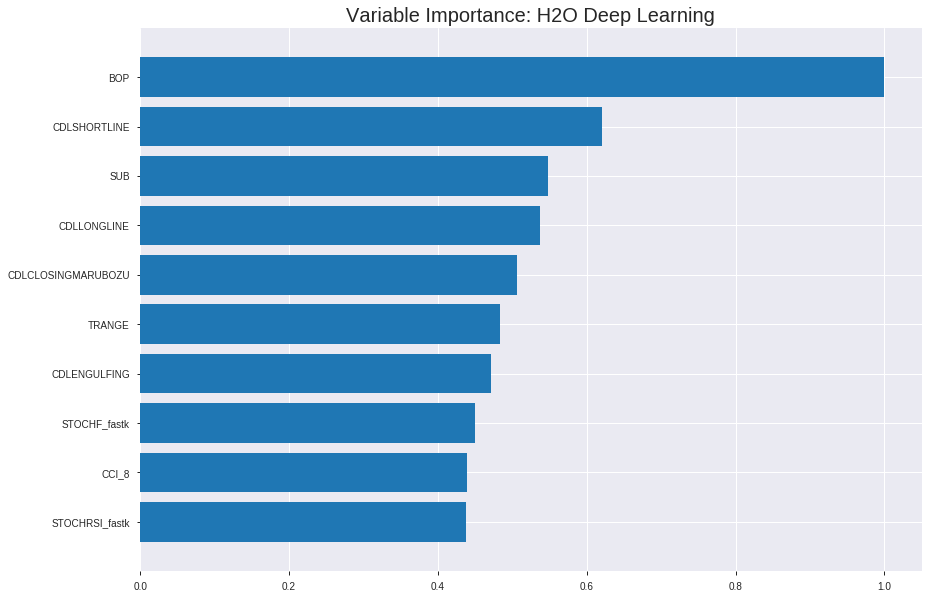

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_161438_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2022540638106877
RMSE: 0.4497266545477238
LogLoss: 0.587004094800664
Mean Per-Class Error: 0.30388506255940206
AUC: 0.7570768289348627
pr_auc: 0.753235315040311
Gini: 0.5141536578697254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4279135944915211: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      389  474   0.5492   (474.0/863.0)
1      108  782   0.1213   (108.0/890.0)
Total  497  1256  0.332    (582.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427914     0.728798  254
max f2                       0.198162     0.851562  342
max f0point5                 0.607261     0.702441  167
max accuracy                 0.583532     0.69652   180
max precision                0.965652     1         0
max recall                   0.104989     1         381
max specificity              0.965652     1         0
max absolute_mcc             0.583532     0.393068  180
max min_per_class_accuracy   0.602579     0.689455  170
max mean_per_class_accuracy  0.607261     0.696115  167

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 55.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.930409           1.96966   1.96966            1                0.943341  1                           0.943341            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.905455           1.75081   1.86024            0.888889         0.917435  0.944444                    0.930388            0.0179775       0.0382022                  75.0811   86.0237
    3        0.0302339                   0.886021           1.62208   1.78385            0.823529         0.896113  0.90566                     0.919394            0.0157303       0.0539326                  62.2075   78.3846
    4        0.040502                    0.871823           1.86024   1.80321            0.944444         0.87793   0.915493                    0.908882            0.0191011       0.0730337                  86.0237   80.3213
    5        0.0501997                   0.865519           1.62208   1.76822            0.823529         0.867848  0.897727                    0.900955            0.0157303       0.088764                   62.2075   76.822
    6        0.100399                    0.829465           1.70107   1.73465            0.863636         0.846177  0.880682                    0.873566            0.0853933       0.174157                   70.1073   73.4646
    7        0.150029                    0.80292            1.53951   1.67009            0.781609         0.816116  0.847909                    0.854561            0.0764045       0.250562                   53.9507   67.0094
    8        0.200228                    0.760144           1.25342   1.56563            0.636364         0.783626  0.794872                    0.836777            0.0629213       0.313483                   25.3422   56.563
    9        0.300057                    0.689725           1.36188   1.49784            0.691429         0.719444  0.760456                    0.79774             0.135955        0.449438                   36.1881   49.7843
    10       0.399886                    0.645511           1.13678   1.4077             0.577143         0.666823  0.714693                    0.765058            0.113483        0.562921                   13.6777   40.7705
    11       0.500285                    0.602701           1.26461   1.37899            0.642045         0.624664  0.700114                    0.736883            0.126966        0.689888                   26.4613   37.8989
    12       0.600114                    0.542469           0.900417  1.29938            0.457143         0.575142  0.659696                    0.709977            0.0898876       0.779775                   -9.95827  29.9378
    13       0.699943                    0.442372           0.79912   1.22803            0.405714         0.495722  0.623472                    0.679419            0.0797753       0.859551                   -20.088   22.8029
    14       0.799772                    0.332687           0.686568  1.16044            0.348571         0.391107  0.589158                    0.643432            0.0685393       0.92809                    -31.3432  16.0443
    15       0.899601                    0.187775           0.528995  1.09037            0.268571         0.255911  0.553583                    0.600428            0.052809        0.980899                   -47.1005  9.03714
    16       1                           0.040281           0.190252  1                  0.0965909        0.126519  0.507701                    0.552848           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20322999172573394
RMSE: 0.4508103722472831
LogLoss: 0.5906255449106773
Mean Per-Class Error: 0.3111255161816959
AUC: 0.7503521239476295
pr_auc: 0.7628095551939017
Gini: 0.500704247895259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34930600182899846: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   161  0.688    (161.0/234.0)
1      11   256  0.0412   (11.0/267.0)
Total  84   417  0.3433   (172.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349306     0.748538  318
max f2                       0.340849     0.862995  322
max f0point5                 0.639166     0.710549  162
max accuracy                 0.592201     0.690619  199
max precision                0.952348     1         0
max recall                   0.102346     1         395
max specificity              0.952348     1         0
max absolute_mcc             0.592201     0.378076  199
max min_per_class_accuracy   0.603453     0.677903  189
max mean_per_class_accuracy  0.592201     0.688874  199

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 57.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.926286           1.8764    1.8764             1                0.937428  1                           0.937428            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.918294           1.50112   1.70582            0.8              0.920532  0.909091                    0.929748            0.0149813       0.0374532                  50.1124   70.5822
    3        0.0319361                   0.891204           1.8764    1.75913            1                0.90293   0.9375                      0.921367            0.0187266       0.0561798                  87.6404   75.9129
    4        0.0419162                   0.874295           1.8764    1.78705            1                0.879404  0.952381                    0.911376            0.0187266       0.0749064                  87.6404   78.7052
    5        0.0518962                   0.863988           1.8764    1.80424            1                0.866692  0.961538                    0.902783            0.0187266       0.093633                   87.6404   80.4235
    6        0.101796                    0.833524           1.42607   1.61886            0.76             0.850952  0.862745                    0.877375            0.071161        0.164794                   42.6067   61.8859
    7        0.151697                    0.80779            1.50112   1.58013            0.8              0.821305  0.842105                    0.858931            0.0749064       0.2397                     50.1124   58.013
    8        0.201597                    0.758915           1.35101   1.52342            0.72             0.784226  0.811881                    0.84044             0.0674157       0.307116                   35.1011   52.3418
    9        0.301397                    0.705584           1.35101   1.46633            0.72             0.731317  0.781457                    0.804306            0.134831        0.441948                   35.1011   46.6329
    10       0.401198                    0.652108           1.12584   1.38163            0.6              0.674863  0.736318                    0.772106            0.11236         0.554307                   12.5843   38.1631
    11       0.500998                    0.609116           1.12584   1.33068            0.6              0.631387  0.709163                    0.744075            0.11236         0.666667                   12.5843   33.0677
    12       0.600798                    0.557984           0.900674  1.25925            0.48             0.585876  0.671096                    0.717796            0.0898876       0.756554                   -9.93258  25.9248
    13       0.700599                    0.463796           0.900674  1.20817            0.48             0.509825  0.643875                    0.68817             0.0898876       0.846442                   -9.93258  20.8169
    14       0.800399                    0.379367           0.78809   1.15579            0.42             0.42045   0.61596                     0.654789            0.0786517       0.925094                   -21.191   15.579
    15       0.9002                      0.242827           0.525393  1.0859             0.28             0.321283  0.578714                    0.617815            0.0524345       0.977528                   -47.4607  8.59015
    16       1                           0.0611706          0.225169  1                  0.12             0.170976  0.532934                    0.57322            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:18:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:18:32  2 min  5.679 sec  1269 obs/sec      2.78152   1             4876       0.460769         0.613458            0.150566       0.75481         0.751547           1.96966          0.322875                         0.460932           0.61463               0.146463         0.751176          0.757175             1.8764             0.321357
    2019-08-27 16:18:37  2 min 10.813 sec  2306 obs/sec      11.1637   4             19570      0.449727         0.587004            0.190792       0.757077        0.753235           1.96966          0.332002                         0.45081            0.590626              0.183538         0.750352          0.76281              1.8764             0.343313
    2019-08-27 16:18:43  2 min 16.555 sec  2845 obs/sec      22.2807   8             39058      0.446205         0.580191            0.203414       0.76755         0.76515            1.96966          0.322305                         0.450796           0.591252              0.183591         0.753529          0.763669             1.56367            0.315369
    2019-08-27 16:18:49  2 min 22.236 sec  3094 obs/sec      33.3965   12            58544      0.443658         0.573867            0.212483       0.769108        0.769309           1.96966          0.324016                         0.450523           0.592254              0.18458          0.750128          0.756708             1.8764             0.331337
    2019-08-27 16:18:54  2 min 27.796 sec  3255 obs/sec      44.5528   16            78101      0.439627         0.565395            0.22673        0.773855        0.768213           1.96966          0.312037                         0.452803           0.601789              0.176305         0.740077          0.732214             1.25094            0.327345
    2019-08-27 16:19:00  2 min 33.451 sec  3346 obs/sec      55.6594   20            97571      0.439468         0.565321            0.227289       0.774916        0.773426           1.96966          0.327439                         0.451024           0.596167              0.182765         0.744358          0.743089             1.56367            0.317365
    2019-08-27 16:19:01  2 min 33.940 sec  3344 obs/sec      55.6594   20            97571      0.449727         0.587004            0.190792       0.757077        0.753235           1.96966          0.332002                         0.45081            0.590626              0.183538         0.750352          0.76281              1.8764             0.343313

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.07026155859162286
CDLSHORTLINE        0.6205201148986816     0.6205201148986816   0.043598710410234276
SUB                 0.5477442741394043     0.5477442741394043   0.03848536641067169
CDLLONGLINE         0.536552906036377      0.536552906036377    0.037699043444980415
CDLCLOSINGMARUBOZU  0.5064295530319214     0.5064295530319214   0.03558252971288173
---                 ---                    ---                  ---
RSI_24              0.3889238238334656     0.3889238238334656   0.02732639403595305
RSI_8               0.38781389594078064    0.38781389594078064  0.027248408772288693
RSI_20              0.3856004476547241     0.3856004476547241   0.027092888445848406
CMO_8               0.3802158236503601     0.3802158236503601   0.026714556370871924
RSI_12              0.3739437460899353     0.3739437460899353   0.02627387042586893


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.6301369863013698)

('auc', 0.7143141945773525)

('logloss', 0.651810668408)

('mean_per_class_error', 0.31057283359914933)

('rmse', 0.47952327969585795)

('mse', 0.229942575770272)

deeplearning prediction progress: |███████████████████████████████████████| 100%


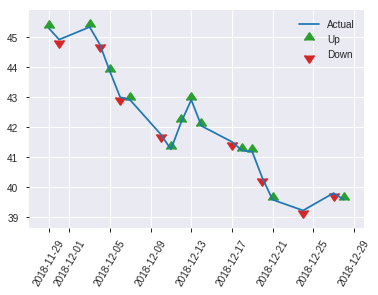


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.229942575770272
RMSE: 0.47952327969585795
LogLoss: 0.651810668408
Mean Per-Class Error: 0.31057283359914933
AUC: 0.7143141945773525
pr_auc: 0.6145604753518735
Gini: 0.4286283891547049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37470989373980407: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   101  0.6645   (101.0/152.0)
1      7    92   0.0707   (7.0/99.0)
Total  58   193  0.4303   (108.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37471      0.630137  192
max f2                       0.291853     0.789902  217
max f0point5                 0.646145     0.631808  89
max accuracy                 0.646145     0.709163  89
max precision                0.862723     0.875     7
max recall                   0.189074     1         243
max specificity              0.930624     0.993421  0
max absolute_mcc             0.643932     0.384255  91
max min_per_class_accuracy   0.606545     0.656566  110
max mean_per_class_accuracy  0.643932     0.689427  91

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 54.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.884461           1.69024   1.69024            0.666667         0.912824  0.666667                    0.912824            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.866538           2.53535   2.11279            1                0.876116  0.833333                    0.89447             0.030303        0.0505051                  153.535   111.279
    3        0.0318725                   0.861792           2.53535   2.21843            1                0.86299   0.875                       0.8866              0.020202        0.0707071                  153.535   121.843
    4        0.0438247                   0.856001           1.69024   2.07438            0.666667         0.85772   0.818182                    0.878724            0.020202        0.0909091                  69.0236   107.438
    5        0.0517928                   0.842624           1.26768   1.95027            0.5              0.850779  0.769231                    0.874424            0.010101        0.10101                    26.7677   95.0272
    6        0.103586                    0.803032           1.95027   1.95027            0.769231         0.818374  0.769231                    0.846399            0.10101         0.20202                    95.0272   95.0272
    7        0.151394                    0.760353           1.47896   1.80144            0.583333         0.780707  0.710526                    0.825655            0.0707071       0.272727                   47.8956   80.1435
    8        0.203187                    0.712374           1.36519   1.69024            0.538462         0.736059  0.666667                    0.802816            0.0707071       0.343434                   36.519    69.0236
    9        0.302789                    0.669299           1.62263   1.668              0.64             0.686849  0.657895                    0.764669            0.161616        0.505051                   62.2626   66.7996
    10       0.40239                     0.623515           1.01414   1.50615            0.4              0.646985  0.594059                    0.73554             0.10101         0.606061                   1.41414   50.6151
    11       0.501992                    0.562043           0.709899  1.34816            0.28             0.594337  0.531746                    0.707523            0.0707071       0.676768                   -29.0101  34.8164
    12       0.601594                    0.489898           0.405657  1.19212            0.16             0.523834  0.470199                    0.677111            0.040404        0.717172                   -59.4343  19.212
    13       0.701195                    0.426147           1.31838   1.21006            0.52             0.450511  0.477273                    0.644924            0.131313        0.848485                   31.8384   21.0055
    14       0.800797                    0.352323           0.811313  1.16046            0.32             0.387703  0.457711                    0.612931            0.0808081       0.929293                   -18.8687  16.046
    15       0.900398                    0.253626           0.507071  1.08818            0.2              0.298842  0.429204                    0.578187            0.0505051       0.979798                   -49.2929  8.81827
    16       1                           0.145748           0.202828  1                  0.08             0.205838  0.394422                    0.5411             

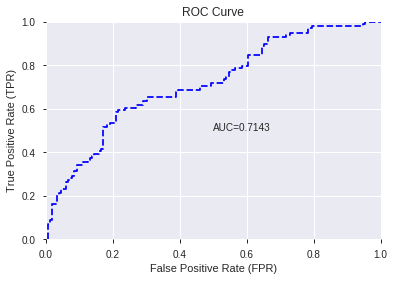

This function is available for GLM models only


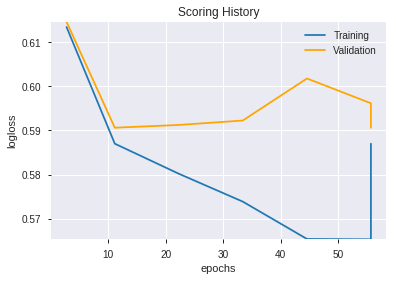

--2019-08-27 16:22:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


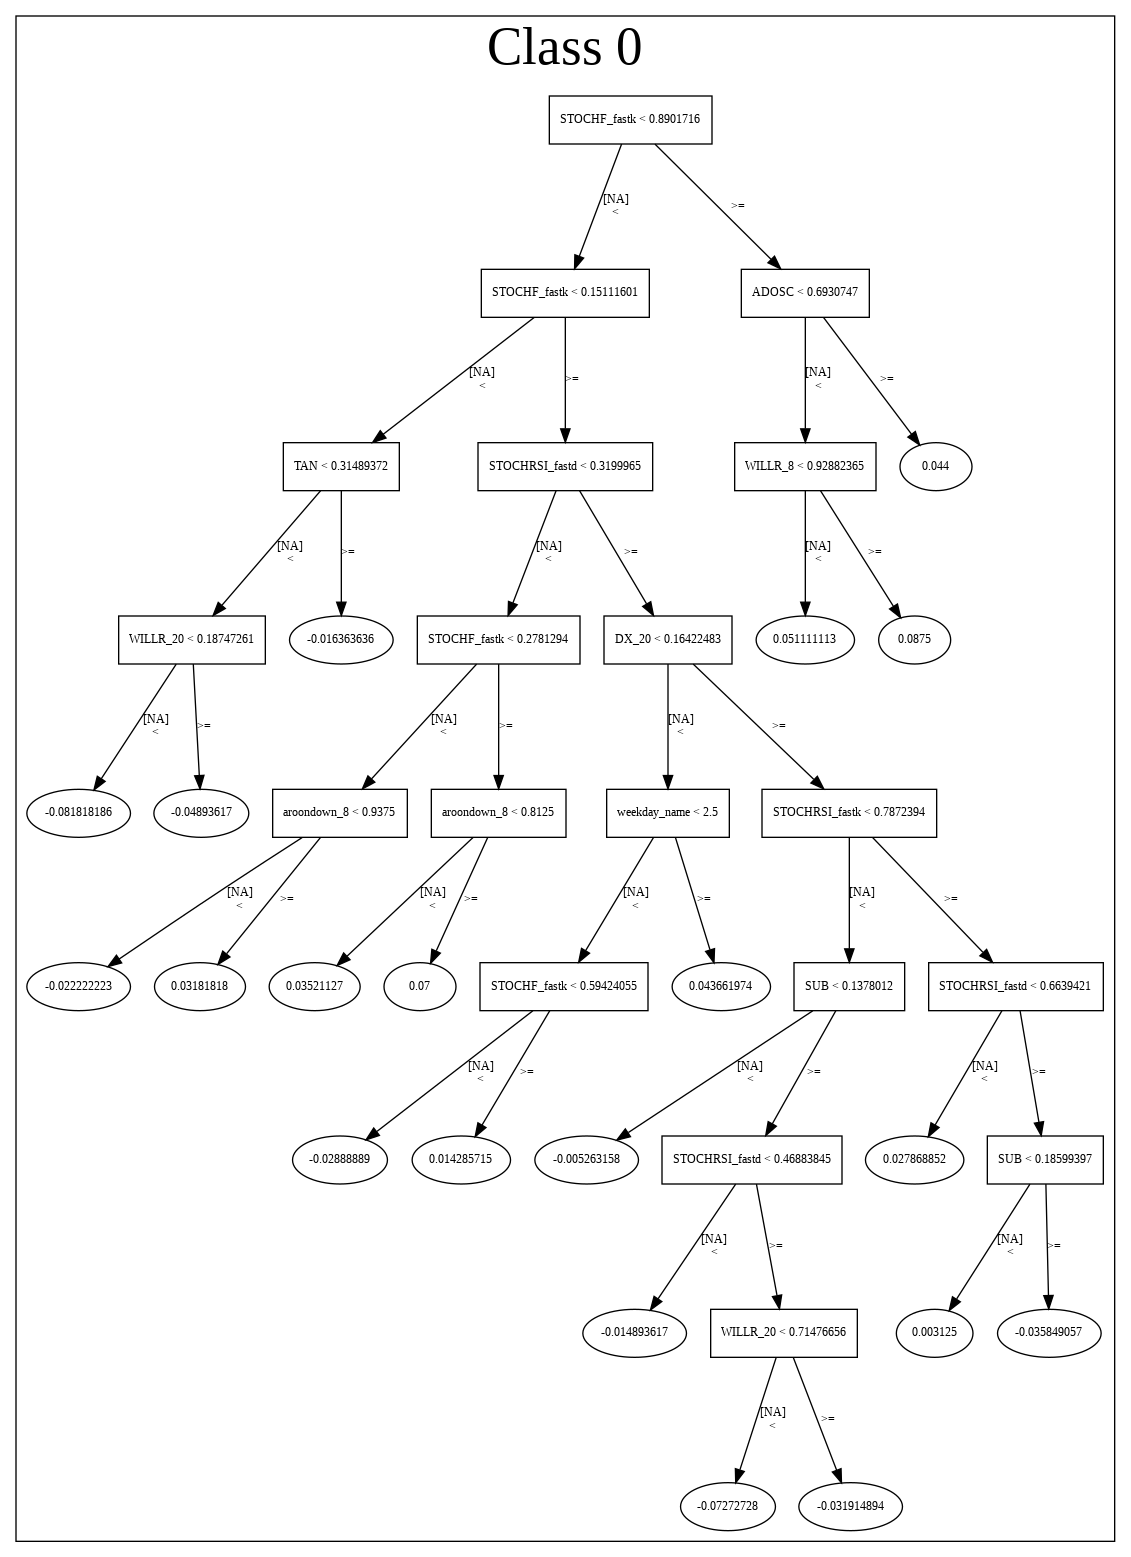

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_161438_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_161438_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLSHORTLINE',
 'SUB',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CDLENGULFING',
 'STOCHF_fastk',
 'CCI_8',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'ULTOSC',
 'WILLR_14',
 'RSI_14',
 'ADOSC',
 'CCI_14',
 'CMO_14',
 'WILLR_20',
 'WILLR_8',
 'CMO_20',
 'CCI_12',
 'WILLR_24',
 'CDLMARUBOZU',
 'CMO_12',
 'WILLR_30',
 'WILLR_12',
 'CMO_24',
 'RSI_24',
 'RSI_8',
 'RSI_20',
 'CMO_8',
 'RSI_12']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_162223_model_1  0.723086  0.635612              0.372873  0.470474  0.221346

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.943941           1.000000    0.289379
1                  SUB             0.323677           0.342900    0.099228
2             WILLR_30             0.230866           0.244577    0.070775
3                CCI_8             0.214309           0.227037    0.065700
4         STOCHF_fastk             0.129794           0.137502    0.039790
5               CCI_14             0.128055           0.135660    0.039257
6                ADOSC             0.101333           0.107351    0.031065
7             WILLR_12             0.096199           0.101912    0.029491
8          CDLMARUBOZU             0.095433           0.101101    0.029257
9               ULTOSC             0.090946           0.096348    0.027881
10        CDLENGULFING             0.082558           0.087461    0.025309
11         CDLBELTHOLD             0.081111           0.085928    0.024866
12            WILLR_14             0.070328           0.074504    0.021560
13            WILLR_20             0.065482           0.069371    0.020075
14              CMO_24             0.061279           0.064918    0.018786
15              RSI_24             0.059539           0.063075    0.018253
16            WILLR_24             0.059009           0.062514    0.018090
17             WILLR_8             0.053521           0.056699    0.016408
18              TRANGE             0.052358           0.055467    0.016051
19              RSI_20             0.051768           0.054843    0.015870
20              CMO_20             0.048506           0.051386    0.014870
21        CDLSHORTLINE             0.044703           0.047357    0.013704
22              CCI_12             0.041242           0.043691    0.012643
23      STOCHRSI_fastk             0.025952           0.027494    0.007956
24              CMO_14             0.022736           0.024086    0.006970
25         CDLLONGLINE             0.020668           0.021895    0.006336
26              RSI_12             0.018705           0.019816    0.005734
27              RSI_14             0.018034           0.019105    0.005529
28              CMO_12             0.013780           0.014599    0.004225
29  CDLCLOSINGMARUBOZU             0.008336           0.008831    0.002556
30               RSI_8             0.004748           0.005030    0.001456
31               CMO_8             0.003035           0.003216    0.000931

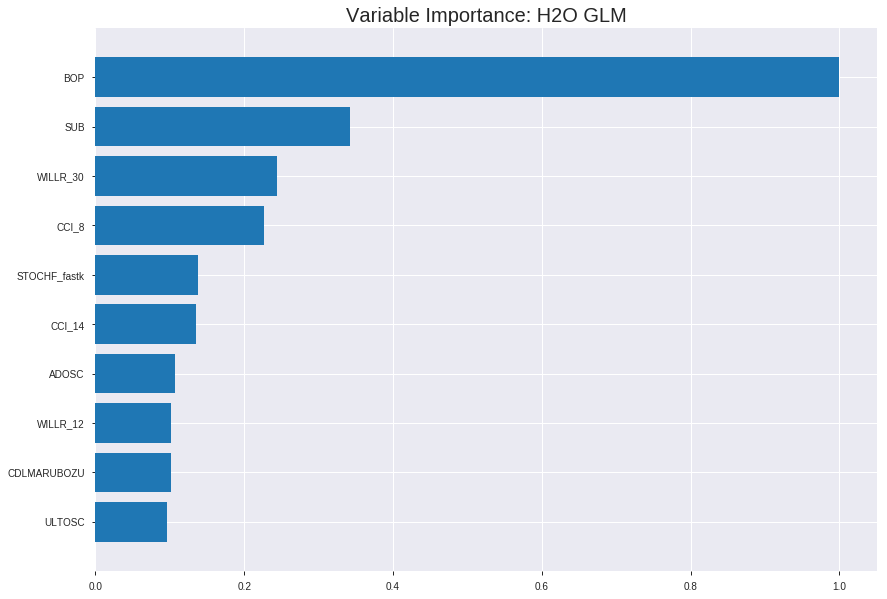

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_162223_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19773097237195436
RMSE: 0.44466950915478154
LogLoss: 0.5783054010012719
Null degrees of freedom: 1752
Residual degrees of freedom: 1720
Null deviance: 2429.758140071244
Residual deviance: 2027.5387359104593
AIC: 2093.5387359104593
AUC: 0.7619149296288099
pr_auc: 0.751362935544424
Gini: 0.5238298592576198
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34996315154079544: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      426  437   0.5064   (437.0/863.0)
1      116  774   0.1303   (116.0/890.0)
Total  542  1211  0.3155   (553.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349963     0.736792  269
max f2                       0.236283     0.853057  331
max f0point5                 0.519654     0.7026    193
max accuracy                 0.454276     0.702795  224
max precision                0.932993     1         0
max recall                   0.100923     1         389
max specificity              0.932993     1         0
max absolute_mcc             0.452565     0.409069  225
max min_per_class_accuracy   0.525105     0.694382  190
max mean_per_class_accuracy  0.454276     0.701556  224

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.885787           1.96966   1.96966            1                0.902419  1                           0.902419            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.868418           1.86024   1.91495            0.944444         0.876724  0.972222                    0.889572            0.0191011       0.0393258                  86.0237   91.495
    3        0.0302339                   0.854772           1.8538    1.89534            0.941176         0.861686  0.962264                    0.880627            0.0179775       0.0573034                  85.38     89.5336
    4        0.040502                    0.842155           1.53196   1.80321            0.777778         0.847541  0.915493                    0.872239            0.0157303       0.0730337                  53.196    80.3213
    5        0.0501997                   0.832059           1.8538    1.81299            0.941176         0.837686  0.920455                    0.865564            0.0179775       0.0910112                  85.38     81.2985
    6        0.100399                    0.796136           1.54439   1.67869            0.784091         0.812386  0.852273                    0.838975            0.0775281       0.168539                   54.4395   67.869
    7        0.150029                    0.763607           1.47159   1.61018            0.747126         0.779829  0.81749                     0.81941             0.0730337       0.241573                   47.1587   61.0181
    8        0.200228                    0.732209           1.43248   1.56563            0.727273         0.746881  0.794872                    0.801226            0.0719101       0.313483                   43.2482   56.563
    9        0.300057                    0.672047           1.29435   1.47537            0.657143         0.703512  0.749049                    0.768716            0.129213        0.442697                   29.435    47.5375
    10       0.399886                    0.601121           1.27184   1.42456            0.645714         0.639047  0.723252                    0.736345            0.126966        0.569663                   27.1839   42.4564
    11       0.500285                    0.526358           1.20866   1.38123            0.613636         0.565601  0.701254                    0.702079            0.121348        0.691011                   20.8657   38.1235
    12       0.600114                    0.437449           1.04674   1.32559            0.531429         0.480937  0.673004                    0.665293            0.104494        0.795506                   4.67352   32.5591
    13       0.699943                    0.340271           0.77661   1.24729            0.394286         0.385889  0.633252                    0.625443            0.0775281       0.873034                   -22.339   24.7293
    14       0.799772                    0.281802           0.675313  1.1759             0.342857         0.311012  0.597004                    0.586195            0.0674157       0.940449                   -32.4687  17.5897
    15       0.899601                    0.201812           0.427698  1.09287            0.217143         0.244033  0.554851                    0.548225            0.0426966       0.983146                   -57.2302  9.28694
    16       1                           0.0461603          0.167869  1                  0.0852273        0.144594  0.507701                    0.507701            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19761669973604395
RMSE: 0.4445409989371554
LogLoss: 0.5784831769731584
Null degrees of freedom: 500
Residual degrees of freedom: 468
Null deviance: 693.6357161682504
Residual deviance: 579.6401433271047
AIC: 645.6401433271047
AUC: 0.764116969173149
pr_auc: 0.7639030051107673
Gini: 0.528233938346298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3529614348094772: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  115  0.4915   (115.0/234.0)
1      28   239  0.1049   (28.0/267.0)
Total  147  354  0.2854   (143.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352961     0.769726  281
max f2                       0.220167     0.866142  362
max f0point5                 0.619915     0.714976  152
max accuracy                 0.352961     0.714571  281
max precision                0.923763     1         0
max recall                   0.162303     1         387
max specificity              0.923763     1         0
max absolute_mcc             0.352961     0.442322  281
max min_per_class_accuracy   0.504871     0.688034  205
max mean_per_class_accuracy  0.352961     0.701839  281

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.891827           1.56367   1.56367            0.833333         0.907067  0.833333                    0.907067            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.877112           1.50112   1.53524            0.8              0.880775  0.818182                    0.895116            0.0149813       0.0337079                  50.1124   53.524
    3        0.0319361                   0.869078           1.8764    1.64185            1                0.872266  0.875                       0.887975            0.0187266       0.0524345                  87.6404   64.1854
    4        0.0419162                   0.854735           1.50112   1.60835            0.8              0.860077  0.857143                    0.881333            0.0149813       0.0674157                  50.1124   60.8347
    5        0.0518962                   0.846882           1.8764    1.6599             1                0.85059   0.884615                    0.875421            0.0187266       0.0861423                  87.6404   65.9896
    6        0.101796                    0.804714           1.65124   1.65565            0.88             0.827687  0.882353                    0.852022            0.082397        0.168539                   65.1236   65.5651
    7        0.151697                    0.772882           1.57618   1.62951            0.84             0.789114  0.868421                    0.831329            0.0786517       0.247191                   57.618    62.9509
    8        0.201597                    0.749546           1.2009    1.52342            0.64             0.759859  0.811881                    0.813638            0.0599251       0.307116                   20.0899   52.3418
    9        0.301397                    0.686717           1.35101   1.46633            0.72             0.717801  0.781457                    0.781904            0.134831        0.441948                   35.1011   46.6329
    10       0.401198                    0.606089           1.23843   1.40964            0.66             0.645086  0.751244                    0.74787             0.123596        0.565543                   23.8427   40.9637
    11       0.500998                    0.518859           1.08831   1.34563            0.58             0.564309  0.717131                    0.711304            0.108614        0.674157                   8.83146   34.5629
    12       0.600798                    0.438906           0.900674  1.27172            0.48             0.475215  0.677741                    0.672086            0.0898876       0.764045                   -9.93258  27.1716
    13       0.700599                    0.363908           1.23843   1.26697            0.66             0.397635  0.675214                    0.632991            0.123596        0.88764                    23.8427   26.6974
    14       0.800399                    0.285882           0.487865  1.16983            0.26             0.320441  0.623441                    0.594019            0.0486891       0.93633                    -51.2135  16.9828
    15       0.9002                      0.227487           0.487865  1.09422            0.26             0.257561  0.583149                    0.556718            0.0486891       0.985019                   -51.2135  9.42226
    16       1                           0.0674847          0.150112  1                  0.08             0.176031  0.532934                    0.518725           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 16:22:23  0.000 sec   2            .22E2     33            1.3681410823831885  1.3684726114423702
     2019-08-27 16:22:23  0.007 sec   4            .14E2     33            1.3597847956263531  1.3608913551784656
     2019-08-27 16:22:23  0.017 sec   6            .84E1     33            1.348752032246132   1.350727545388032
     2019-08-27 16:22:23  0.025 sec   8            .52E1     33            1.3349123441700557  1.3376642864363197
     2019-08-27 16:22:23  0.033 sec   10           .33E1     33            1.3181869081695932  1.3213749851766976
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 16:22:23  0.140 sec   38           .41E-2    33            1.155652099903708   1.1572605004484284
     2019-08-27 16:22:23  0.148 sec   40           .26E-2    33            1.1550231280298138  1.157673755103025
     2019-08-27 16:22:23  0.152 sec   41           .16E-2    33            1.1545773816708877  1.158015803367613
     2019-08-27 16:22:23  0.157 sec   42           .99E-3    33            1.1542882546063056  1.158337271688501
     2019-08-27 16:22:23  0.162 sec   43           .61E-3    33            1.1540616732800058  1.1585022103631293


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.6223776223776225)

('auc', 0.7230861244019139)

('logloss', 0.6356116142598104)

('mean_per_class_error', 0.3176169590643274)

('rmse', 0.4704737074385506)

('mse', 0.22134550939097491)

glm prediction progress: |████████████████████████████████████████████████| 100%


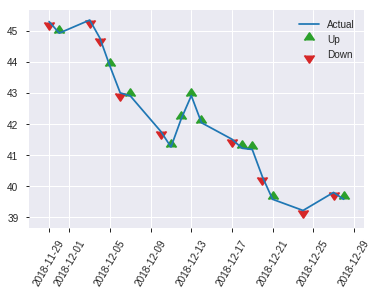


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22134550939097491
RMSE: 0.4704737074385506
LogLoss: 0.6356116142598104
Null degrees of freedom: 250
Residual degrees of freedom: 218
Null deviance: 349.6521945213129
Residual deviance: 319.07703035842485
AIC: 385.07703035842485
AUC: 0.7230861244019139
pr_auc: 0.60298255242638
Gini: 0.4461722488038278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35168639732202145: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      54   98   0.6447   (98.0/152.0)
1      10   89   0.101    (10.0/99.0)
Total  64   187  0.4303   (108.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351686     0.622378  186
max f2                       0.292478     0.795455  219
max f0point5                 0.634649     0.632184  83
max accuracy                 0.634649     0.709163  83
max precision                0.796461     0.782609  22
max recall                   0.26284      1         231
max specificity              0.933818     0.993421  0
max absolute_mcc             0.634649     0.377795  83
max min_per_class_accuracy   0.526236     0.657895  117
max mean_per_class_accuracy  0.634649     0.682383  83

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 52.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.887164           1.69024   1.69024            0.666667         0.912988  0.666667                    0.912988            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.870525           0.845118  1.26768            0.333333         0.872633  0.5                         0.89281             0.010101        0.030303                   -15.4882  26.7677
    3        0.0318725                   0.859446           2.53535   1.5846             1                0.868119  0.625                       0.886637            0.020202        0.0505051                  153.535   58.4596
    4        0.0438247                   0.847789           2.53535   1.84389            1                0.851052  0.727273                    0.876932            0.030303        0.0808081                  153.535   84.3893
    5        0.0517928                   0.833516           1.26768   1.75524            0.5              0.836951  0.692308                    0.870782            0.010101        0.0909091                  26.7677   75.5245
    6        0.103586                    0.789175           1.95027   1.85276            0.769231         0.808439  0.730769                    0.83961             0.10101         0.191919                   95.0272   85.2758
    7        0.151394                    0.760657           1.47896   1.73472            0.583333         0.779242  0.684211                    0.820546            0.0707071       0.262626                   47.8956   73.4716
    8        0.203187                    0.733491           1.75524   1.73995            0.692308         0.747654  0.686275                    0.801966            0.0909091       0.353535                   75.5245   73.9949
    9        0.302789                    0.660627           1.52121   1.668              0.6              0.696345  0.657895                    0.767222            0.151515        0.505051                   52.1212   66.7996
    10       0.40239                     0.590358           1.01414   1.50615            0.4              0.62177   0.594059                    0.731219            0.10101         0.606061                   1.41414   50.6151
    11       0.501992                    0.5105             0.912727  1.38841            0.36             0.541352  0.547619                    0.693547            0.0909091       0.69697                    -8.72727  38.8408
    12       0.601594                    0.439338           0.608485  1.25928            0.24             0.470322  0.496689                    0.656589            0.0606061       0.757576                   -39.1515  25.9282
    13       0.701195                    0.375838           0.811313  1.19565            0.32             0.403917  0.471591                    0.620698            0.0808081       0.838384                   -18.8687  19.565
    14       0.800797                    0.326976           0.912727  1.16046            0.36             0.351369  0.457711                    0.5872              0.0909091       0.929293                   -8.72727  16.046
    15       0.900398                    0.278461           0.608485  1.0994             0.24             0.303514  0.433628                    0.555819            0.0606061       0.989899                   -39.1515  9.94011
    16       1                           0.0931839          0.101414  1                  0.04             0.222207  0.394422                    0.52259            

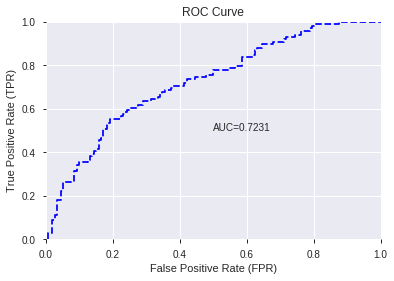

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


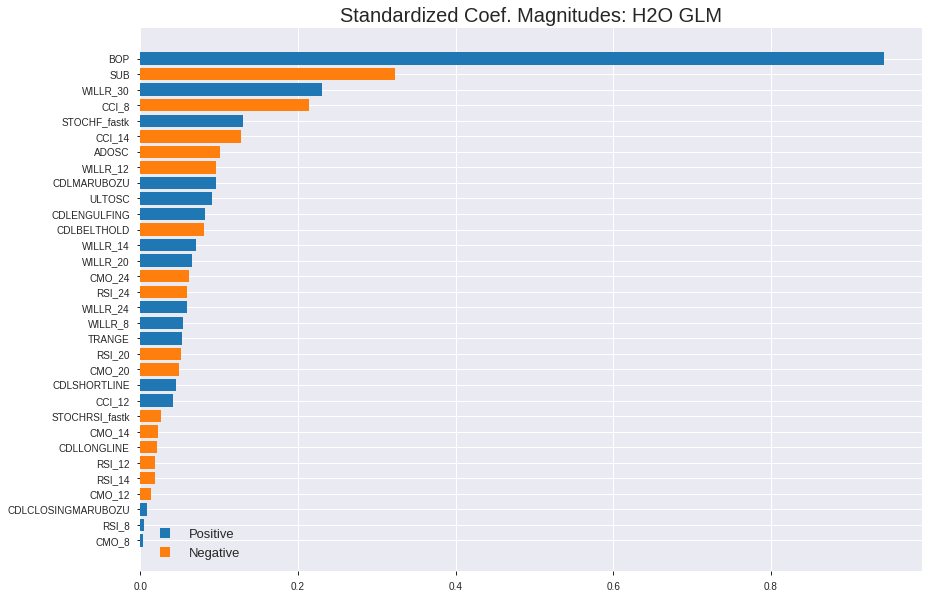

'log_likelihood'
--2019-08-27 16:22:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


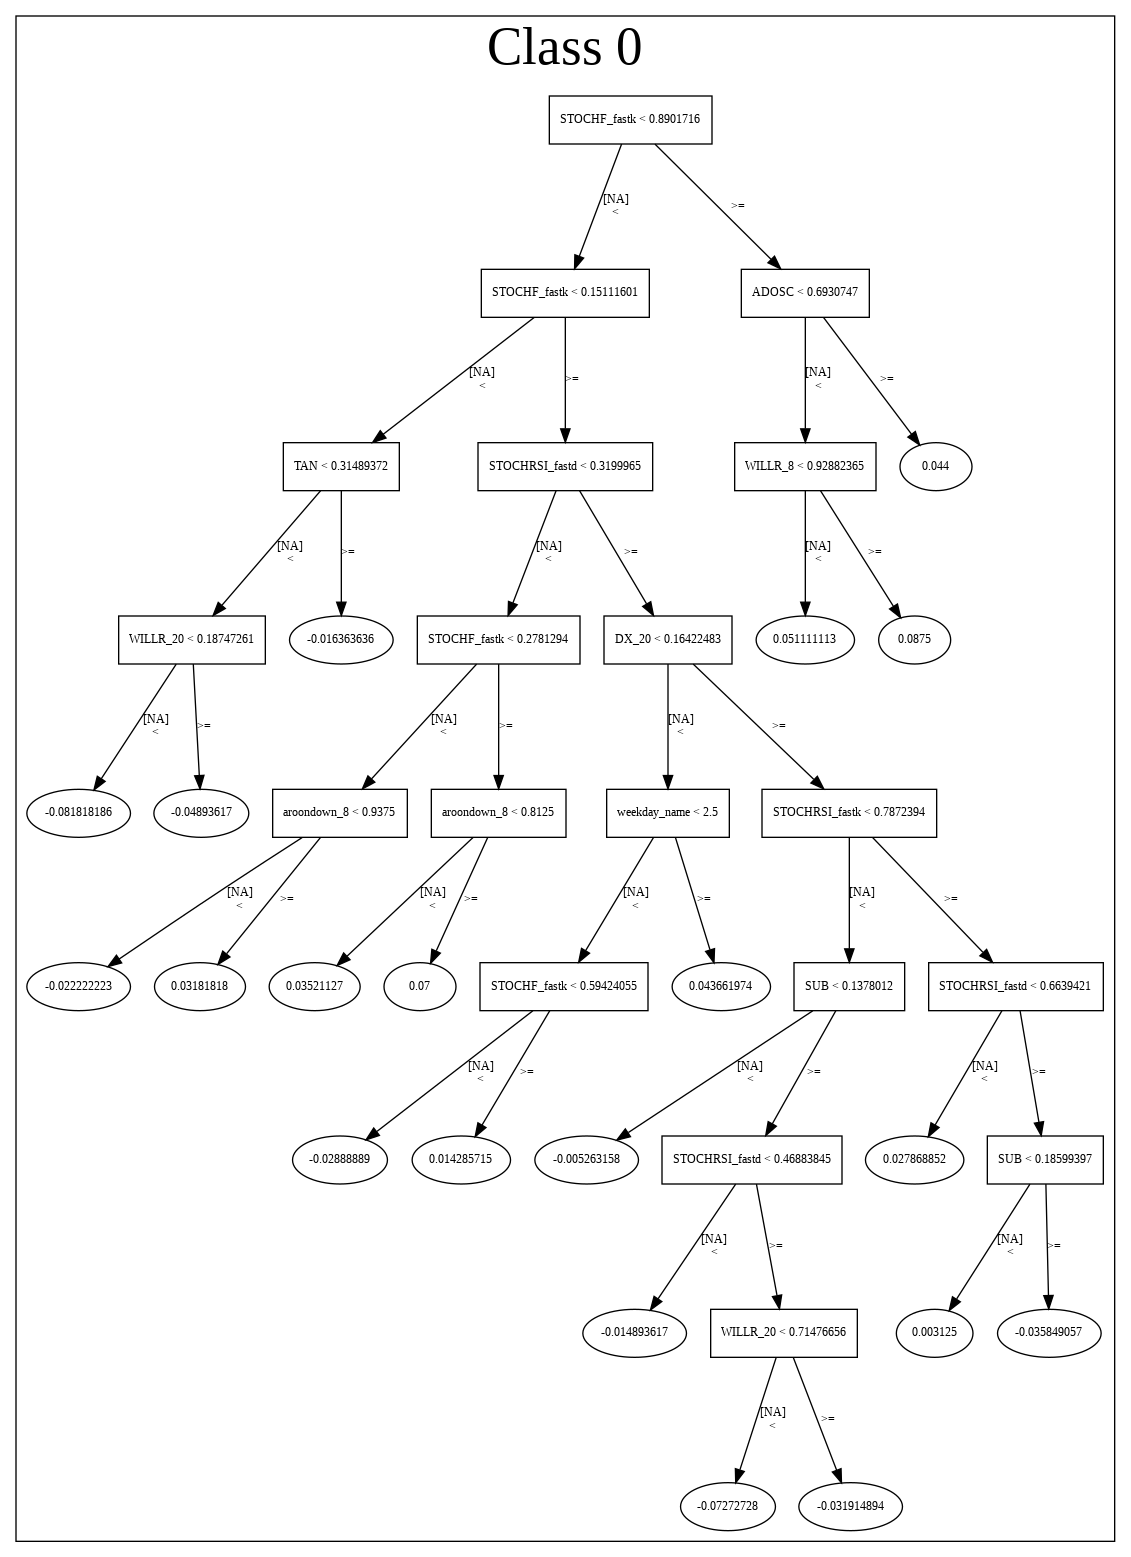

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_162223_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_162223_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'WILLR_30',
 'CCI_8',
 'STOCHF_fastk',
 'CCI_14',
 'ADOSC',
 'WILLR_12',
 'CDLMARUBOZU',
 'ULTOSC',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'WILLR_14',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'WILLR_8',
 'TRANGE',
 'RSI_20',
 'CMO_20',
 'CDLSHORTLINE',
 'CCI_12',
 'STOCHRSI_fastk',
 'CMO_14',
 'CDLLONGLINE',
 'RSI_12',
 'RSI_14',
 'CMO_12',
 'CDLCLOSINGMARUBOZU',
 'RSI_8',
 'CMO_8']

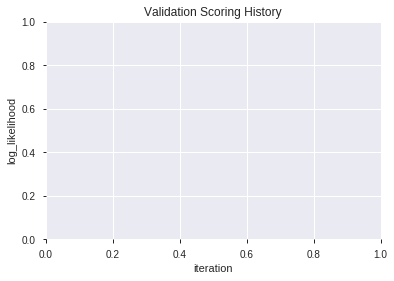

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_162241_model_3  0.742690  0.624534              0.313896  0.466858  0.217957
1  XGBoost_grid_1_AutoML_20190827_162241_model_4  0.736344  0.617089              0.349249  0.463614  0.214938
2  XGBoost_grid_1_AutoML_20190827_162241_model_6  0.734649  0.634749              0.315058  0.472503  0.223259
3  XGBoost_grid_1_AutoML_20190827_162241_model_1  0.724880  0.634873              0.340677  0.472591  0.223342
4               XGBoost_2_AutoML_20190827_162241  0.724016  0.627214              0.326821  0.468676  0.219657
5  XGBoost_grid_1_AutoML_20190827_162241_model_2  0.723418  0.632629              0.340444  0.471301  0.222125
6               XGBoost_1_AutoML_20190827_162241  0.723418  0.636467              0.320474  0.472983  0.223712
7               XGBoost_3_AutoML_20190827_162241  0.717969  0.635604              0.326455  0.472630  0.223380
8  XGBoost_grid_1_AutoML_20190827_162241_model_7  0.713849  0.646791              0.338450  0.477340  0.227854
9  XGBoost_grid_1_AutoML_20190827_162241_model_5  0.711523  0.675736              0.344199  0.487709  0.237860

variable  relative_importance  scaled_importance  percentage
0                  BOP          1863.928589           1.000000    0.273038
1         STOCHF_fastk           599.460449           0.321611    0.087812
2                  SUB           389.335327           0.208879    0.057032
3                CCI_8           382.794098           0.205370    0.056074
4               TRANGE           273.862793           0.146928    0.040117
5                CMO_8           261.843231           0.140479    0.038356
6               CCI_14           257.286163           0.138034    0.037689
7              WILLR_8           252.423080           0.135425    0.036976
8             WILLR_14           222.746368           0.119504    0.032629
9                ADOSC           216.055527           0.115914    0.031649
10            WILLR_12           196.345383           0.105340    0.028762
11      STOCHRSI_fastk           183.485825           0.098440    0.026878
12            WILLR_30           172.139511           0.092353    0.025216
13            WILLR_20           162.875946           0.087383    0.023859
14              CCI_12           147.232635           0.078990    0.021567
15              ULTOSC           139.334274           0.074753    0.020410
16            WILLR_24           129.882767           0.069682    0.019026
17              CMO_20           115.221786           0.061817    0.016878
18              CMO_12           113.132027           0.060695    0.016572
19              CMO_24            91.306503           0.048986    0.013375
20              RSI_14            87.121887           0.046741    0.012762
21               RSI_8            86.425095           0.046367    0.012660
22              CMO_14            85.529427           0.045887    0.012529
23              RSI_20            74.890068           0.040179    0.010970
24              RSI_12            71.235107           0.038218    0.010435
25              RSI_24            69.253922           0.037155    0.010145
26         CDLLONGLINE            49.510498           0.026562    0.007253
27        CDLSHORTLINE            47.604160           0.025540    0.006973
28  CDLCLOSINGMARUBOZU            38.653873           0.020738    0.005662
29        CDLENGULFING            37.725704           0.020240    0.005526
30         CDLMARUBOZU             5.794151           0.003109    0.000849
31         CDLBELTHOLD             2.180347           0.001170    0.000319

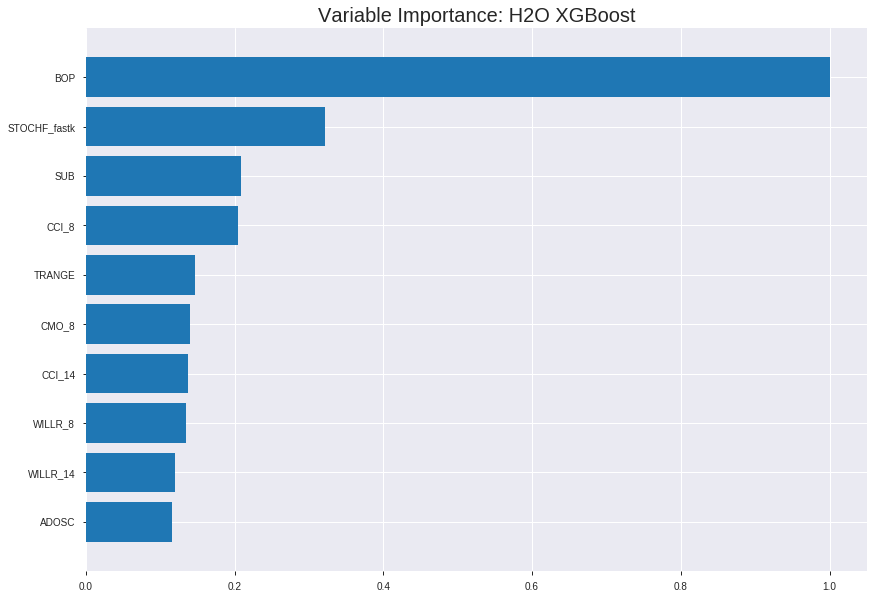

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_162241_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15021164940603912
RMSE: 0.3875714765124481
LogLoss: 0.4680085942234827
Mean Per-Class Error: 0.201125548452615
AUC: 0.8842677099743512
pr_auc: 0.8879014377247986
Gini: 0.7685354199487024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5037160664796829: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      641  222  0.2572   (222.0/863.0)
1      151  739  0.1697   (151.0/890.0)
Total  792  961  0.2128   (373.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503716     0.798487  204
max f2                       0.273612     0.889719  310
max f0point5                 0.587414     0.8307    158
max accuracy                 0.561487     0.79806   172
max precision                0.934323     1         0
max recall                   0.123493     1         370
max specificity              0.934323     1         0
max absolute_mcc             0.587414     0.606566  158
max min_per_class_accuracy   0.534336     0.788764  188
max mean_per_class_accuracy  0.587414     0.798874  158

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.93 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.907237           1.96966    1.96966            1                0.918324  1                           0.918324            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.895125           1.96966    1.96966            1                0.90056   1                           0.909442            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.885226           1.96966    1.96966            1                0.890587  1                           0.903394            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.869094           1.96966    1.96966            1                0.877155  1                           0.896742            0.0202247       0.0797753                  96.9663   96.9663
    5        0.0501997                   0.860995           1.96966    1.96966            1                0.863872  1                           0.890392            0.0191011       0.0988764                  96.9663   96.9663
    6        0.100399                    0.818397           1.9249     1.94728            0.977273         0.839028  0.988636                    0.86471             0.0966292       0.195506                   92.4898   94.728
    7        0.150029                    0.772386           1.7659     1.88728            0.896552         0.791825  0.958175                    0.8406              0.0876404       0.283146                   76.5905   88.7282
    8        0.200228                    0.739897           1.85775    1.87988            0.943182         0.757975  0.954416                    0.819885            0.0932584       0.376404                   85.775    87.9878
    9        0.300057                    0.663672           1.6095     1.78992            0.817143         0.701195  0.908745                    0.780397            0.160674        0.537079                   60.9496   78.9922
    10       0.399886                    0.594204           1.5082     1.71959            0.765714         0.628295  0.873039                    0.742426            0.150562        0.68764                    50.8199   71.9592
    11       0.500285                    0.534863           0.962449   1.56765            0.488636         0.564466  0.795895                    0.706712            0.0966292       0.78427                    -3.75511  56.7645
    12       0.600114                    0.457587           0.810376   1.44167            0.411429         0.498615  0.731939                    0.672095            0.0808989       0.865169                   -18.9624  44.1673
    13       0.699943                    0.358898           0.787865   1.34842            0.4              0.406898  0.684597                    0.634271            0.0786517       0.94382                    -21.2135  34.8424
    14       0.799772                    0.267375           0.472719   1.23912            0.24             0.311687  0.629101                    0.594006            0.047191        0.991011                   -52.7281  23.9117
    15       0.899601                    0.17627            0.0675313  1.10911            0.0342857        0.224781  0.563094                    0.553033            0.00674157      0.997753                   -93.2469  10.9106
    16       1                           0.0525882          0.0223825  1                  0.0113636        0.117569  0.507701                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20005502741994008
RMSE: 0.4472751137945639
LogLoss: 0.5835749407560149
Mean Per-Class Error: 0.2997455104196678
AUC: 0.7550657831556707
pr_auc: 0.7676212313042142
Gini: 0.5101315663113415
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3240267485380173: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      90   144  0.6154   (144.0/234.0)
1      19   248  0.0712   (19.0/267.0)
Total  109  392  0.3253   (163.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324027     0.752656  306
max f2                       0.154072     0.857605  377
max f0point5                 0.626115     0.733772  152
max accuracy                 0.626115     0.692615  152
max precision                0.942353     1         0
max recall                   0.134428     1         388
max specificity              0.942353     1         0
max absolute_mcc             0.626115     0.408362  152
max min_per_class_accuracy   0.535041     0.681648  196
max mean_per_class_accuracy  0.626115     0.700254  152

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 53.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.913067           1.8764    1.8764             1                0.92219   1                           0.92219             0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.901691           1.8764    1.8764             1                0.904811  1                           0.91429             0.0187266       0.0411985                  87.6404   87.6404
    3        0.0319361                   0.886829           1.12584   1.64185            0.6              0.889067  0.875                       0.906408            0.011236        0.0524345                  12.5843   64.1854
    4        0.0419162                   0.868542           1.8764    1.6977             1                0.872981  0.904762                    0.898449            0.0187266       0.071161                   87.6404   69.7699
    5        0.0518962                   0.861576           1.8764    1.73207            1                0.864631  0.923077                    0.891946            0.0187266       0.0898876                  87.6404   73.2066
    6        0.101796                    0.825107           1.50112   1.61886            0.8              0.844798  0.862745                    0.868834            0.0749064       0.164794                   50.1124   61.8859
    7        0.151697                    0.796658           1.57618   1.60482            0.84             0.809001  0.855263                    0.849152            0.0786517       0.243446                   57.618    60.482
    8        0.201597                    0.757495           1.50112   1.57915            0.8              0.774883  0.841584                    0.830769            0.0749064       0.318352                   50.1124   57.9152
    9        0.301397                    0.696551           1.31348   1.49118            0.7              0.724785  0.794702                    0.795675            0.131086        0.449438                   31.3483   49.1182
    10       0.401198                    0.625278           1.35101   1.45631            0.72             0.659328  0.776119                    0.761757            0.134831        0.58427                    35.1011   45.6314
    11       0.500998                    0.541548           0.863146  1.33815            0.46             0.58398   0.713147                    0.726344            0.0861423       0.670412                   -13.6854  33.8153
    12       0.600798                    0.47157            0.825618  1.25301            0.44             0.50875   0.667774                    0.690199            0.082397        0.752809                   -17.4382  25.3014
    13       0.700599                    0.3975             0.97573   1.21352            0.52             0.435481  0.646724                    0.653914            0.0973783       0.850187                   -2.42697  21.3515
    14       0.800399                    0.312697           0.863146  1.16983            0.46             0.35398   0.623441                    0.616516            0.0861423       0.93633                    -13.6854  16.9828
    15       0.9002                      0.228482           0.375281  1.08174            0.2              0.265827  0.576497                    0.577637            0.0374532       0.973783                   -62.4719  8.1741
    16       1                           0.0775968          0.262697  1                  0.14             0.1609    0.532934                    0.536046           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:22:48  2.030 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-27 16:22:48  2.124 sec   5                  0.475714         0.645447            0.811393        0.810632           1.96966          0.287507                         0.482179           0.657925              0.740445          0.754442             1.8764             0.319361
    2019-08-27 16:22:48  2.185 sec   10                 0.458925         0.612941            0.828444        0.831841           1.96966          0.272675                         0.471592           0.637033              0.745502          0.753959             1.8764             0.323353
    2019-08-27 16:22:48  2.259 sec   15                 0.443561         0.583136            0.839603        0.841918           1.96966          0.27838                          0.462642           0.619123              0.75016           0.752959             1.8764             0.319361
    2019-08-27 16:22:48  2.332 sec   20                 0.432372         0.561095            0.846995        0.848192           1.96966          0.250428                         0.457176           0.607754              0.751128          0.756187             1.8764             0.327345
    2019-08-27 16:22:48  2.401 sec   25                 0.423572         0.54309             0.849639        0.852596           1.96966          0.247005                         0.452992           0.598595              0.753089          0.761821             1.8764             0.343313
    2019-08-27 16:22:48  2.470 sec   30                 0.418873         0.533101            0.851146        0.857089           1.96966          0.244723                         0.450633           0.593163              0.75505           0.763265             1.8764             0.319361
    2019-08-27 16:22:48  2.549 sec   35                 0.412685         0.520364            0.857096        0.863227           1.96966          0.256703                         0.448145           0.587425              0.758067          0.770582             1.8764             0.327345
    2019-08-27 16:22:48  2.627 sec   40                 0.407125         0.508485            0.860794        0.865753           1.96966          0.241301                         0.447531           0.585477              0.75657           0.770407             1.8764             0.319361
    2019-08-27 16:22:48  2.707 sec   45                 0.402331         0.497886            0.864392        0.870054           1.96966          0.241301                         0.447209           0.584376              0.755466          0.768416             1.8764             0.317365
    2019-08-27 16:22:48  2.785 sec   50                 0.39789          0.489147            0.871445        0.876619           1.96966          0.233885                         0.446764           0.583301              0.755898          0.769823             1.8764             0.321357
    2019-08-27 16:22:48  2.867 sec   55                 0.393667         0.48067             0.877986        0.883513           1.96966          0.21506                          0.447545           0.584967              0.753497          0

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 1863.9285888671875     1.0                    0.2730384199133963
STOCHF_fastk        599.46044921875        0.3216112745945247     0.08781223424162243
SUB                 389.3353271484375      0.2088788859583178     0.057031960975329594
CCI_8               382.7940979003906      0.20536950835280432    0.056073766059040735
TRANGE              273.86279296875        0.1469277281353314     0.04011691473153594
---                 ---                    ---                    ---
CDLSHORTLINE        47.60416030883789      0.02553969105531536    0.006973316890819607
CDLCLOSINGMARUBOZU  38.653873443603516     0.020737851049913672   0.0056622300830677956
CDLENGULFING        37.725704193115234     0.02023988709569782    0.005526266791834872
CDLMARUBOZU         5.7941508293151855     0.0031085691071655332  0.0008487587972120743
CDLBELTHOLD         2.180347442626953      0.0011697591075375215  0.00031938917840134947


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.6615969581749049)

('auc', 0.7426900584795322)

('logloss', 0.6245340145781836)

('mean_per_class_error', 0.3074162679425837)

('rmse', 0.46685843389507586)

('mse', 0.21795679729896292)

xgboost prediction progress: |████████████████████████████████████████████| 100%


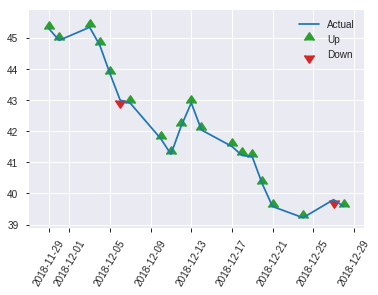


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21795679729896292
RMSE: 0.46685843389507586
LogLoss: 0.6245340145781836
Mean Per-Class Error: 0.3074162679425837
AUC: 0.7426900584795322
pr_auc: 0.6443838631432763
Gini: 0.48538011695906436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4514979124069214: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   77   0.5066   (77.0/152.0)
1      12   87   0.1212   (12.0/99.0)
Total  87   164  0.3546   (89.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451498     0.661597  163
max f2                       0.423236     0.786713  175
max f0point5                 0.573181     0.612245  109
max accuracy                 0.61936      0.693227  87
max precision                0.905935     1         0
max recall                   0.26421      1         238
max specificity              0.905935     1         0
max absolute_mcc             0.451498     0.382247  163
max min_per_class_accuracy   0.561121     0.676768  112
max mean_per_class_accuracy  0.537021     0.692584  123

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 53.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.891955           2.53535   2.53535            1                0.902069  1                           0.902069            0.030303        0.030303                   153.535   153.535
    2        0.0239044                   0.877044           2.53535   2.53535            1                0.880814  1                           0.891441            0.030303        0.0606061                  153.535   153.535
    3        0.0318725                   0.867096           2.53535   2.53535            1                0.872993  1                           0.886829            0.020202        0.0808081                  153.535   153.535
    4        0.0438247                   0.829413           1.69024   2.30487            0.666667         0.848923  0.909091                    0.876491            0.020202        0.10101                    69.0236   130.487
    5        0.0517928                   0.796605           2.53535   2.34033            1                0.803634  0.923077                    0.865282            0.020202        0.121212                   153.535   134.033
    6        0.103586                    0.745056           1.36519   1.85276            0.538462         0.764967  0.730769                    0.815125            0.0707071       0.191919                   36.519    85.2758
    7        0.151394                    0.718877           1.69024   1.80144            0.666667         0.732232  0.710526                    0.788948            0.0808081       0.272727                   69.0236   80.1435
    8        0.203187                    0.693325           1.36519   1.69024            0.538462         0.706217  0.666667                    0.76786             0.0707071       0.343434                   36.519    69.0236
    9        0.302789                    0.642167           1.11556   1.5012             0.44             0.67059   0.592105                    0.735863            0.111111        0.454545                   11.5556   50.1196
    10       0.40239                     0.583734           1.52121   1.50615            0.6              0.614641  0.594059                    0.705858            0.151515        0.606061                   52.1212   50.6151
    11       0.501992                    0.53448            1.21697   1.44877            0.48             0.558381  0.571429                    0.676596            0.121212        0.727273                   21.697    44.8773
    12       0.601594                    0.475097           1.01414   1.37681            0.4              0.503891  0.543046                    0.648003            0.10101         0.828283                   1.41414   37.6815
    13       0.701195                    0.423236           0.811313  1.29649            0.32             0.450844  0.511364                    0.619997            0.0808081       0.909091                   -18.8687  29.6488
    14       0.800797                    0.37258            0.304242  1.17307            0.12             0.401169  0.462687                    0.59278             0.030303        0.939394                   -69.5758  17.3074
    15       0.900398                    0.303649           0.304242  1.07696            0.12             0.346286  0.424779                    0.565513            0.030303        0.969697                   -69.5758  7.69643
    16       1                           0.137972           0.304242  1                  0.12             0.246992  0.394422                    0.533788         

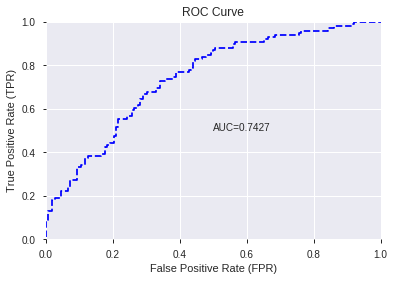

This function is available for GLM models only


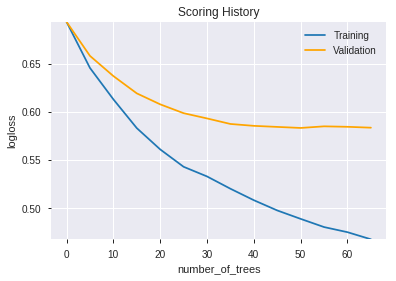

--2019-08-27 16:23:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

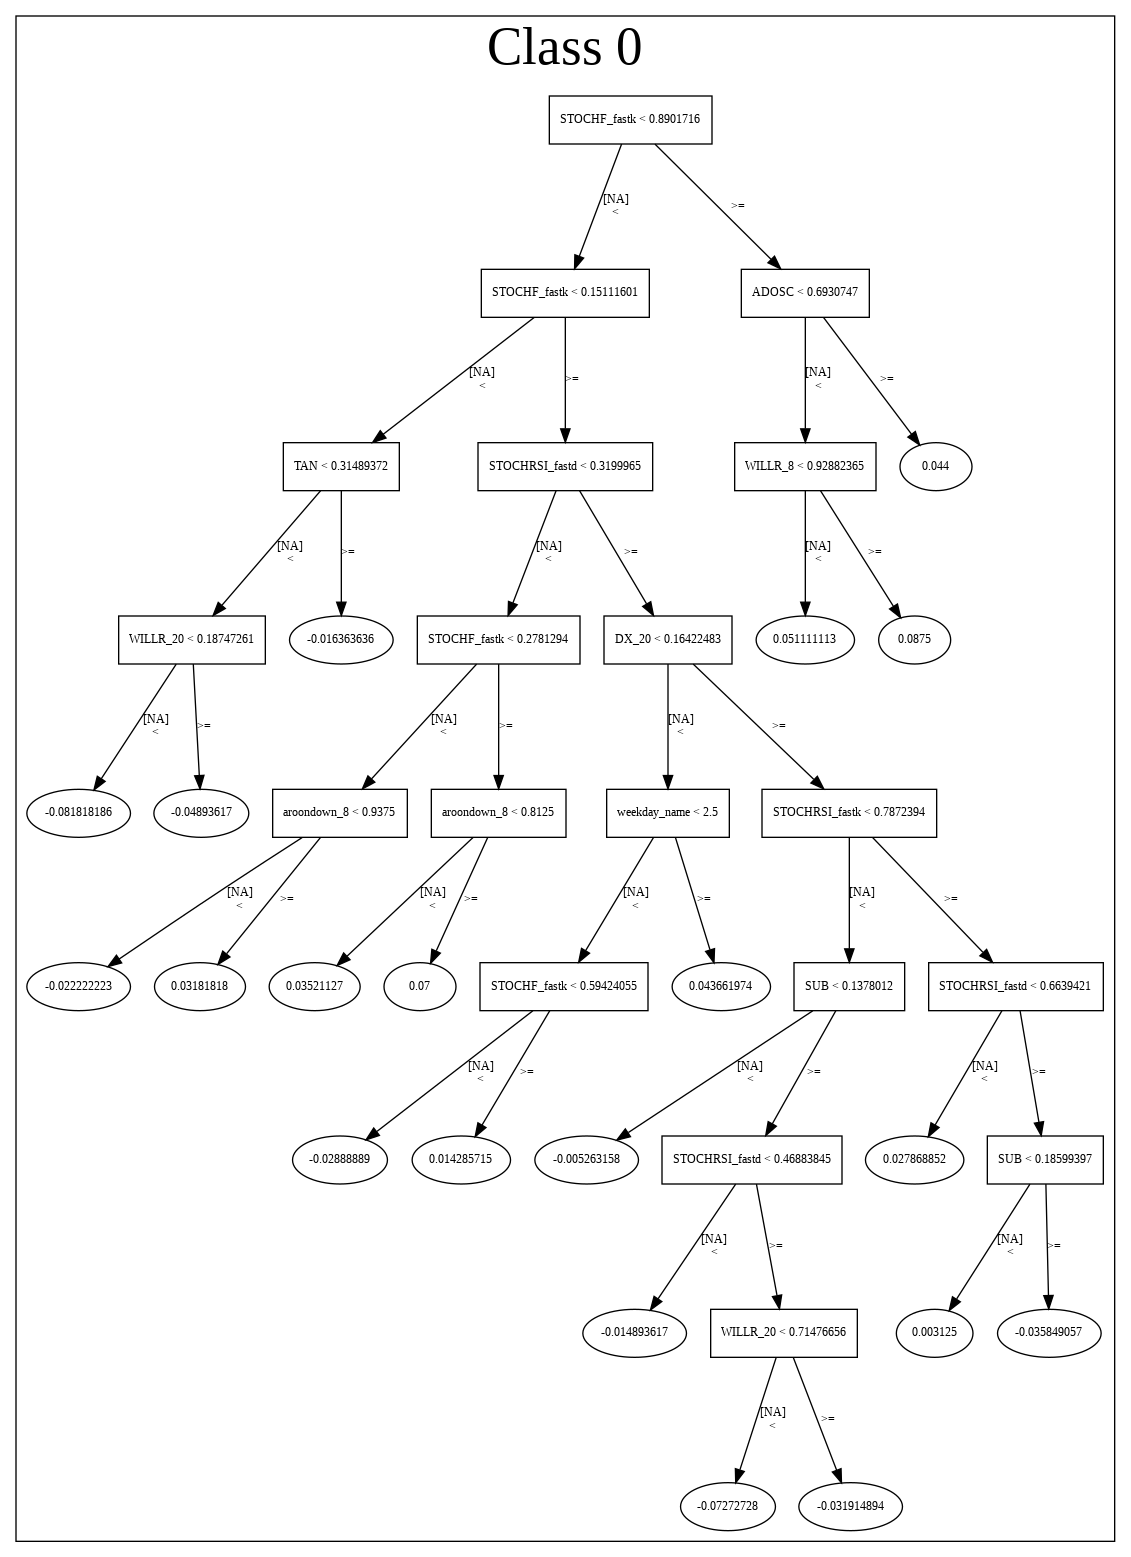

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_162241_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_162241_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'TRANGE',
 'CMO_8',
 'CCI_14',
 'WILLR_8',
 'WILLR_14',
 'ADOSC',
 'WILLR_12',
 'STOCHRSI_fastk',
 'WILLR_30',
 'WILLR_20',
 'CCI_12',
 'ULTOSC',
 'WILLR_24',
 'CMO_20',
 'CMO_12',
 'CMO_24',
 'RSI_14',
 'RSI_8',
 'CMO_14',
 'RSI_20',
 'RSI_12',
 'RSI_24',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'CDLBELTHOLD']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

63

['MAVP_14_5',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_middleband_20_2_3',
 'BBANDS_middleband_20_3_5',
 'BBANDS_upperband_20_7_2',
 'BBANDS_upperband_20_7_5',
 'BBANDS_lowerband_30_7_5',
 'BOP',
 'aroondown_8',
 'MFI_8',
 'ROCR_8',
 'RSI_8',
 'TRIX_8',
 'aroondown_12',
 'AROONOSC_12',
 'CMO_12',
 'PLUS_DI_12',
 'ROC_12',
 'ROCR100_12',
 'WILLR_12',
 'aroondown_14',
 'DX_14',
 'ROCR100_14',
 'WILLR_14',
 'AROONOSC_20',
 'CCI_20',
 'MACDFIX_hist_20',
 'MFI_20',
 'WILLR_20',
 'aroondown_24',
 'AROONOSC_24',
 'CMO_24',
 'MACDFIX_hist_24',
 'MFI_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'MFI_30',
 'MOM_30',
 'ROC_30',
 'ROCR_30',
 'MACD',
 'MACDEXT',
 'MACDEXT_hist',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'AD',
 'ATR_24',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'LINEARREG_SLOPE_8',
 'STDDEV_8',
 'VAR_8',
 'CORREL_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_162432_model_5  0.736244  0.601961              0.380283  0.455479  0.207461
1  DeepLearning_grid_1_AutoML_20190827_162432_model_8  0.730762  0.592557              0.323631  0.451896  0.204210
2  DeepLearning_grid_1_AutoML_20190827_162432_model_6  0.727738  0.606047              0.380283  0.457872  0.209646
3  DeepLearning_grid_1_AutoML_20190827_162432_model_9  0.716839  0.603449              0.383340  0.457343  0.209163
4  DeepLearning_grid_1_AutoML_20190827_162432_model_3  0.682549  0.670393              0.366627  0.475654  0.226246
5               DeepLearning_1_AutoML_20190827_162432  0.679891  0.638020              0.404472  0.469337  0.220277
6  DeepLearning_grid_1_AutoML_20190827_162432_model_4  0.667597  0.777262              0.358519  0.507460  0.257516
7  DeepLearning_grid_1_AutoML_20190827_162432_model_7  0.661683  0.714327              0.370980  0.497380  0.247387
8  DeepLearning_grid_1_AutoML_20190827_162432_model_1  0.647461  0.805615              0.438430  0.505840  0.255874
9  DeepLearning_grid_1_AutoML_20190827_162432_model_2  0.628057  0.854068              0.407994  0.511516  0.261649

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.039411
1               TRANGE             0.592107           0.592107    0.023336
2   CDLCLOSINGMARUBOZU             0.498141           0.498141    0.019632
3          CDLLONGLINE             0.473237           0.473237    0.018651
4            CORREL_12             0.441887           0.441887    0.017415
..                 ...                  ...                ...         ...
58              CMO_24             0.357137           0.357137    0.014075
59              RSI_24             0.354272           0.354272    0.013962
60              CCI_30             0.353964           0.353964    0.013950
61          ROCR100_12             0.347852           0.347852    0.013709
62              CCI_20             0.345681           0.345681    0.013624

[63 rows x 4 columns]

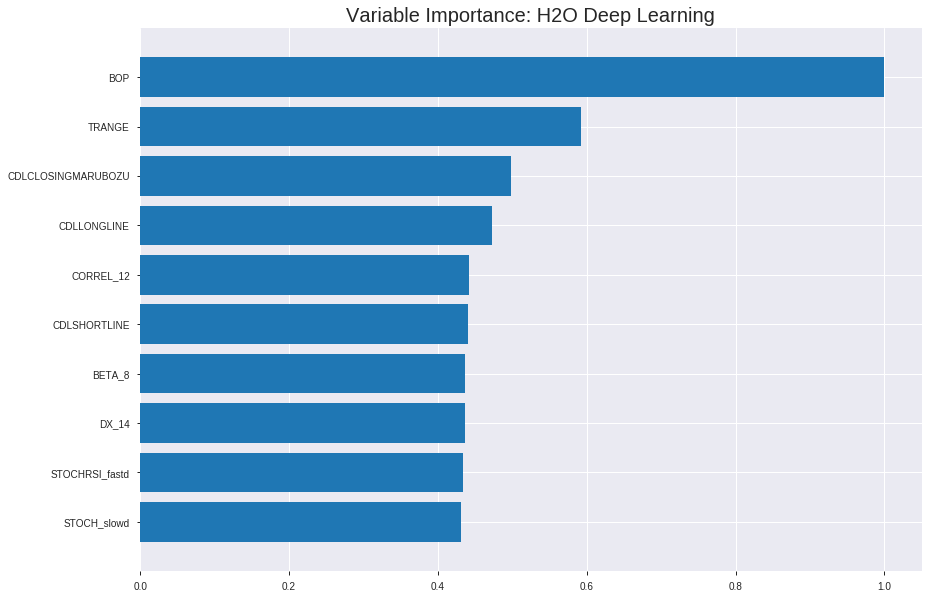

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_162432_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19604632880253353
RMSE: 0.44277119238104634
LogLoss: 0.5741527075635555
Mean Per-Class Error: 0.30418451443227834
AUC: 0.7714759071438801
pr_auc: 0.7702494553630223
Gini: 0.5429518142877603
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3824460305756884: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      318  545   0.6315   (545.0/863.0)
1      50   840   0.0562   (50.0/890.0)
Total  368  1385  0.3394   (595.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382446     0.738462  282
max f2                       0.3271       0.858135  306
max f0point5                 0.577362     0.703577  161
max accuracy                 0.515371     0.69652   200
max precision                0.977315     1         0
max recall                   0.137687     1         377
max specificity              0.977315     1         0
max absolute_mcc             0.515371     0.393461  200
max min_per_class_accuracy   0.53745      0.68764   187
max mean_per_class_accuracy  0.515371     0.695815  200

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 53.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.902378           1.96966   1.96966            1                0.91866   1                           0.91866             0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.87523            1.75081   1.86024            0.888889         0.888762  0.944444                    0.903711            0.0179775       0.0382022                  75.0811   86.0237
    3        0.0302339                   0.859196           1.8538    1.85817            0.941176         0.866635  0.943396                    0.891818            0.0179775       0.0561798                  85.38     85.8173
    4        0.040502                    0.841555           1.96966   1.88644            1                0.850256  0.957746                    0.881282            0.0202247       0.0764045                  96.9663   88.6438
    5        0.0501997                   0.82987            1.8538    1.88013            0.941176         0.835386  0.954545                    0.872415            0.0179775       0.094382                   85.38     88.0133
    6        0.100399                    0.776458           1.65631   1.76822            0.840909         0.80254   0.897727                    0.837478            0.0831461       0.177528                   65.6307   76.822
    7        0.150029                    0.73435            1.60743   1.71503            0.816092         0.754372  0.870722                    0.809986            0.0797753       0.257303                   60.7426   71.503
    8        0.200228                    0.694771           1.34295   1.62175            0.681818         0.714929  0.823362                    0.786154            0.0674157       0.324719                   34.2952   62.1745
    9        0.300057                    0.64059            1.33937   1.5278             0.68             0.66776   0.775665                    0.746765            0.133708        0.458427                   33.9371   52.7799
    10       0.399886                    0.58309            1.24933   1.45828            0.634286         0.610806  0.740371                    0.712824            0.124719        0.583146                   24.9329   45.8281
    11       0.500285                    0.53693            1.04079   1.3745             0.528409         0.559059  0.697834                    0.681965            0.104494        0.68764                    4.07878   37.4497
    12       0.600114                    0.492575           0.979204  1.30874            0.497143         0.514118  0.664449                    0.654044            0.0977528       0.785393                   -2.07961  30.874
    13       0.699943                    0.441593           0.889162  1.2489             0.451429         0.46915   0.634067                    0.627674            0.088764        0.874157                   -11.0838  24.8898
    14       0.799772                    0.375488           0.742844  1.18573            0.377143         0.409403  0.601997                    0.600429            0.0741573       0.948315                   -25.7156  18.5731
    15       0.899601                    0.265018           0.360167  1.09412            0.182857         0.317502  0.555485                    0.569032            0.0359551       0.98427                    -63.9833  9.41184
    16       1                           0.0436454          0.156678  1                  0.0795455        0.184483  0.507701                    0.530424            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20274955871317646
RMSE: 0.45027720208020355
LogLoss: 0.5909925113996387
Mean Per-Class Error: 0.30581964851627774
AUC: 0.7545856141361759
pr_auc: 0.7654263076791473
Gini: 0.5091712282723517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39334345479581945: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      105  129  0.5513   (129.0/234.0)
1      30   237  0.1124   (30.0/267.0)
Total  135  366  0.3174   (159.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393343     0.748815  284
max f2                       0.262583     0.861508  369
max f0point5                 0.521336     0.717723  195
max accuracy                 0.43322      0.698603  257
max precision                0.92867      1         0
max recall                   0.19015      1         388
max specificity              0.92867      1         0
max absolute_mcc             0.43322      0.397131  257
max min_per_class_accuracy   0.50539      0.688034  205
max mean_per_class_accuracy  0.521336     0.69418   195

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.899123           1.8764    1.8764             1                0.912748  1                           0.912748            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.861886           1.50112   1.70582            0.8              0.880311  0.909091                    0.898004            0.0149813       0.0374532                  50.1124   70.5822
    3        0.0319361                   0.839131           1.8764    1.75913            1                0.846669  0.9375                      0.881962            0.0187266       0.0561798                  87.6404   75.9129
    4        0.0419162                   0.812518           1.50112   1.6977             0.8              0.825487  0.904762                    0.868515            0.0149813       0.071161                   50.1124   69.7699
    5        0.0518962                   0.80349            1.50112   1.6599             0.8              0.806313  0.884615                    0.856553            0.0149813       0.0861423                  50.1124   65.9896
    6        0.101796                    0.760309           1.57618   1.61886            0.84             0.780324  0.862745                    0.819186            0.0786517       0.164794                   57.618    61.8859
    7        0.151697                    0.714636           1.50112   1.58013            0.8              0.733567  0.842105                    0.791022            0.0749064       0.2397                     50.1124   58.013
    8        0.201597                    0.659203           1.42607   1.542              0.76             0.683498  0.821782                    0.764407            0.071161        0.310861                   42.6067   54.1996
    9        0.301397                    0.609156           1.35101   1.47876            0.72             0.632997  0.788079                    0.720894            0.134831        0.445693                   35.1011   47.8756
    10       0.401198                    0.557748           1.2009    1.40964            0.64             0.581804  0.751244                    0.686294            0.11985         0.565543                   20.0899   40.9637
    11       0.500998                    0.509479           1.16337   1.36058            0.62             0.535887  0.7251                      0.656333            0.116105        0.681648                   16.3371   36.058
    12       0.600798                    0.465074           0.863146  1.27795            0.46             0.485747  0.681063                    0.627996            0.0861423       0.76779                    -13.6854  27.795
    13       0.700599                    0.403806           0.863146  1.21886            0.46             0.433655  0.649573                    0.600312            0.0861423       0.853933                   -13.6854  21.8861
    14       0.800399                    0.356817           0.637978  1.14643            0.34             0.383322  0.610973                    0.573256            0.0636704       0.917603                   -36.2022  14.6432
    15       0.9002                      0.292565           0.525393  1.07758            0.28             0.326417  0.574279                    0.54589             0.0524345       0.970037                   -47.4607  7.75804
    16       1                           0.0744713          0.300225  1                  0.16             0.222456  0.532934                    0.513612            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:28:00  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:28:01  1 min 26.872 sec  1202 obs/sec      0.944666  1             1656       0.464996         0.630591            0.134911       0.724643        0.704574           1.64139          0.35425                          0.4582             0.610253              0.156553         0.740325          0.748046             1.8764             0.337325
    2019-08-27 16:28:07  1 min 32.586 sec  2017 obs/sec      7.55391   8             13242      0.442771         0.574153            0.215629       0.771476        0.770249           1.96966          0.339418                         0.450277           0.590993              0.185468         0.754586          0.765426             1.8764             0.317365
    2019-08-27 16:28:12  1 min 38.067 sec  2305 obs/sec      15.1306   16            26524      0.434178         0.552818            0.245779       0.791345        0.791413           1.96966          0.312607                         0.456425           0.606048              0.163073         0.757299          0.761056             1.25094            0.321357
    2019-08-27 16:28:18  1 min 43.806 sec  2477 obs/sec      23.6224   25            41410      0.423114         0.526365            0.283728       0.806238        0.805838           1.96966          0.279521                         0.451878           0.598625              0.179664         0.764973          0.769354             1.56367            0.301397
    2019-08-27 16:28:23  1 min 49.347 sec  2594 obs/sec      32.1683   34            56391      0.407202         0.492125            0.336588       0.834822        0.839626           1.96966          0.263548                         0.4529             0.601869              0.175952         0.751328          0.759281             1.8764             0.323353
    2019-08-27 16:28:29  1 min 54.745 sec  2681 obs/sec      40.7034   43            71353      0.400441         0.480343            0.358436       0.849837        0.850057           1.96966          0.244723                         0.453115           0.604743              0.175167         0.742974          0.741847             1.56367            0.335329
    2019-08-27 16:28:29  1 min 55.283 sec  2679 obs/sec      40.7034   43            71353      0.442771         0.574153            0.215629       0.771476        0.770249           1.96966          0.339418                         0.450277           0.590993              0.185468         0.754586          0.765426             1.8764             0.317365

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03941147568419251
TRANGE              0.5921074748039246     0.5921074748039246   0.0233358293456635
CDLCLOSINGMARUBOZU  0.49814078211784363    0.49814078211784363  0.01963246332174203
CDLLONGLINE         0.4732370972633362     0.4732370972633362   0.01865097235165182
CORREL_12           0.4418873190879822     0.4418873190879822   0.017415431331389026
---                 ---                    ---                  ---
CMO_24              0.3571365177631378     0.3571365177631378   0.014075277185759093
RSI_24              0.3542722761631012     0.3542722761631012   0.013962393197585595
CCI_30              0.35396435856819153    0.35396435856819153  0.013950257710781079
ROCR100_12          0.34785184264183044    0.34785184264183044  0.01370935443798006
CCI_20              0.3456810712814331     0.3456810712814331   0.01362380113529382


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7250996015936255)

('F1', 0.6274509803921569)

('auc', 0.7362440191387559)

('logloss', 0.6019607084620703)

('mean_per_class_error', 0.3255914407230196)

('rmse', 0.455478809730376)

('mse', 0.2074609461134001)

deeplearning prediction progress: |███████████████████████████████████████| 100%


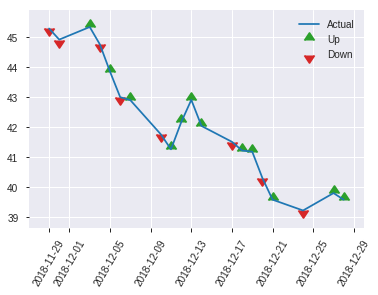


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2074609461134001
RMSE: 0.455478809730376
LogLoss: 0.6019607084620703
Mean Per-Class Error: 0.3255914407230196
AUC: 0.7362440191387559
pr_auc: 0.6516616853128079
Gini: 0.47248803827751185
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33979699702209165: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   111  0.7303   (111.0/152.0)
1      3    96   0.0303   (3.0/99.0)
Total  44   207  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339797     0.627451  206
max f2                       0.323559     0.801964  214
max f0point5                 0.596305     0.665635  55
max accuracy                 0.596305     0.7251    55
max precision                0.89337      1         0
max recall                   0.27707      1         231
max specificity              0.89337      1         0
max absolute_mcc             0.596305     0.409474  55
max min_per_class_accuracy   0.487081     0.646465  110
max mean_per_class_accuracy  0.596305     0.674409  55

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 48.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.847281           2.53535   2.53535            1                0.864612  1                           0.864612            0.030303        0.030303                   153.535   153.535
    2        0.0239044                   0.816366           2.53535   2.53535            1                0.831781  1                           0.848196            0.030303        0.0606061                  153.535   153.535
    3        0.0318725                   0.779882           1.26768   2.21843            0.5              0.793012  0.875                       0.8344              0.010101        0.0707071                  26.7677   121.843
    4        0.0438247                   0.77173            1.69024   2.07438            0.666667         0.773595  0.818182                    0.817817            0.020202        0.0909091                  69.0236   107.438
    5        0.0517928                   0.754024           1.26768   1.95027            0.5              0.764304  0.769231                    0.809584            0.010101        0.10101                    26.7677   95.0272
    6        0.103586                    0.700997           2.1453    2.04779            0.846154         0.717903  0.807692                    0.763744            0.111111        0.212121                   114.53    104.779
    7        0.151394                    0.641955           1.69024   1.93488            0.666667         0.663866  0.763158                    0.732203            0.0808081       0.292929                   69.0236   93.4875
    8        0.203187                    0.608019           2.1453    1.98851            0.846154         0.62704   0.784314                    0.705397            0.111111        0.40404                    114.53    98.8513
    9        0.302789                    0.559464           0.709899  1.56792            0.28             0.580114  0.618421                    0.664185            0.0707071       0.474747                   -29.0101  56.7916
    10       0.40239                     0.506914           1.31838   1.50615            0.52             0.53325   0.594059                    0.631776            0.131313        0.606061                   31.8384   50.6151
    11       0.501992                    0.466818           0.811313  1.36829            0.32             0.482915  0.539683                    0.60224             0.0808081       0.686869                   -18.8687  36.8286
    12       0.601594                    0.436491           0.912727  1.29286            0.36             0.451024  0.509934                    0.577204            0.0909091       0.777778                   -8.72727  29.2862
    13       0.701195                    0.400687           0.811313  1.22446            0.32             0.416751  0.482955                    0.554413            0.0808081       0.858586                   -18.8687  22.4461
    14       0.800797                    0.350226           0.608485  1.14785            0.24             0.376593  0.452736                    0.532296            0.0606061       0.919192                   -39.1515  14.7847
    15       0.900398                    0.293953           0.709899  1.0994             0.28             0.323745  0.433628                    0.509226            0.0707071       0.989899                   -29.0101  9.94011
    16       1                           0.159985           0.101414  1                  0.04             0.236116  0.394422                    0.482024         

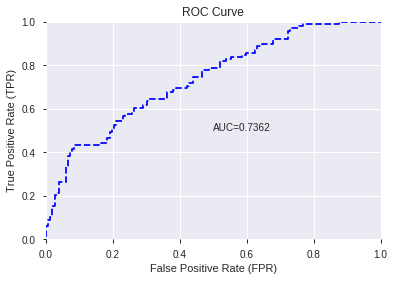

This function is available for GLM models only


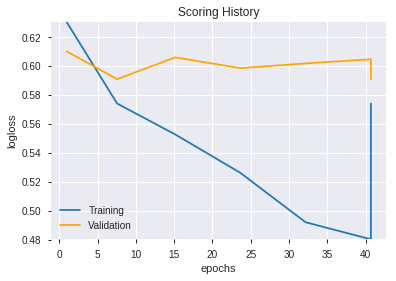

--2019-08-27 16:32:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


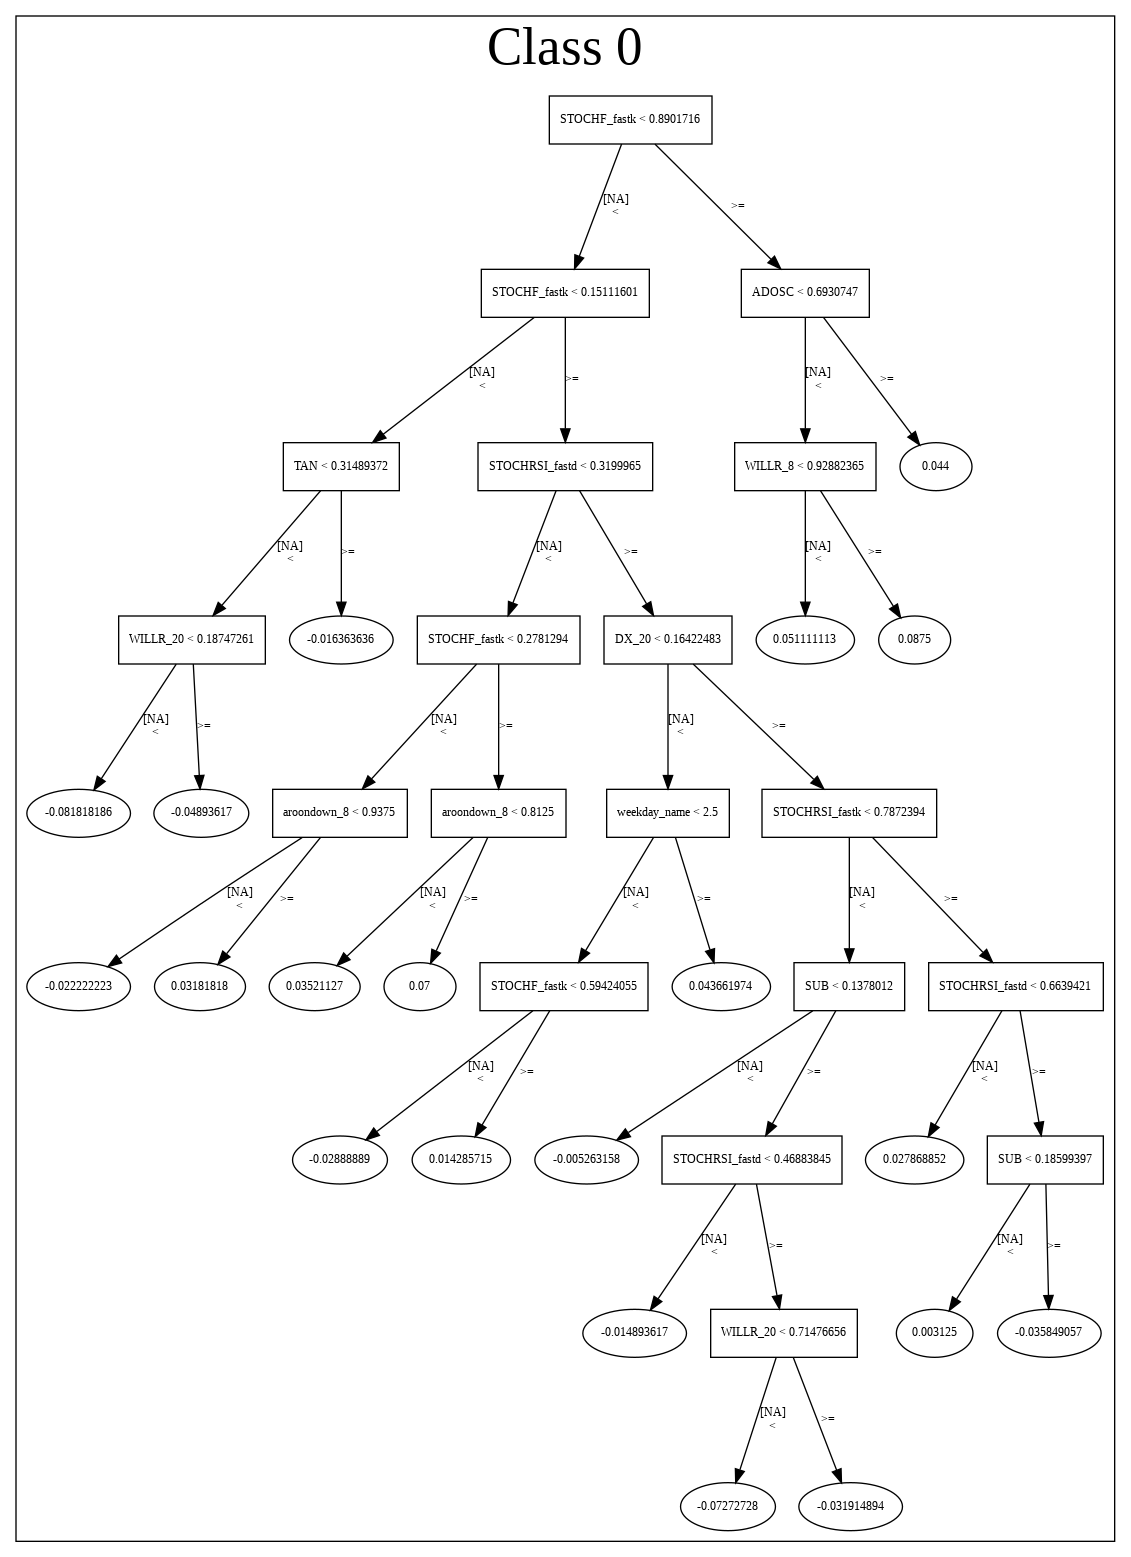

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_162432_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_162432_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CORREL_12',
 'CDLSHORTLINE',
 'BETA_8',
 'DX_14',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'STDDEV_8',
 'STOCHRSI_fastk',
 'CDLSPINNINGTOP',
 'aroondown_24',
 'ATR_24',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'aroondown_8',
 'AD',
 'PLUS_DI_12',
 'MFI_20',
 'aroondown_12',
 'WILLR_12',
 'MFI_30',
 'BBANDS_upperband_20_7_5',
 'MOM_30',
 'MFI_24',
 'VAR_8',
 'aroondown_14',
 'WILLR_14',
 'ROCR100_24',
 'LINEARREG_SLOPE_8',
 'MFI_8',
 'AROONOSC_20',
 'BBANDS_upperband_20_7_2',
 'ROC_30',
 'ROCR100_14',
 'TRIX_8',
 'AROONOSC_24',
 'MACDEXT',
 'BBANDS_middleband_20_3_5',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'MAVP_14_5',
 'MACD',
 'RSI_8',
 'ROC_12',
 'MACDFIX_hist_24',
 'BBANDS_lowerband_30_7_5',
 'AROONOSC_12',
 'BBANDS_lowerband_14_7_2',
 'CMO_12',
 'ROCR_8',
 'WILLR_24',
 'BBANDS_middleband_20_2_3',
 'WILLR_20',
 'MACDFIX_hist_20',
 'ROCR_30',
 'CMO_24',
 'RSI_24',
 'CCI_30',
 'ROCR100_12',
 'CCI_20']

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_163242_model_1  0.722621  0.597683              0.385566  0.45345  0.205617

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.692037           1.000000    0.167317
1                    TRANGE             0.282593           0.408349    0.068324
2                    CCI_20             0.153841           0.222301    0.037195
3                  WILLR_20             0.148696           0.214867    0.035951
4                  WILLR_24             0.138230           0.199744    0.033420
..                      ...                  ...                ...         ...
58                 STDDEV_8             0.005827           0.008420    0.001409
59  BBANDS_lowerband_14_7_2             0.002846           0.004113    0.000688
60                   ROC_12             0.001387           0.002004    0.000335
61              AROONOSC_24             0.001381           0.001995    0.000334
62               ROCR100_12             0.001339           0.001934    0.000324

[63 rows x 4 columns]

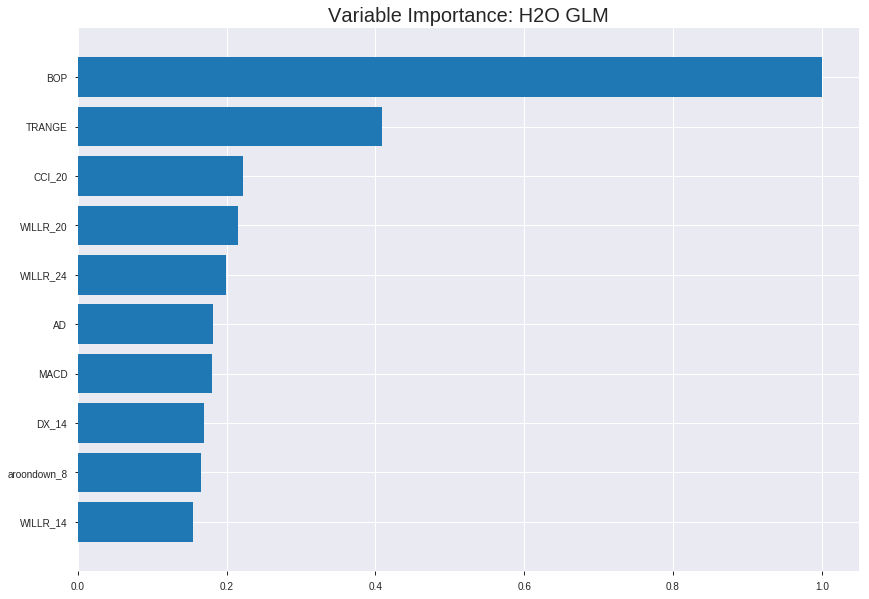

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_163242_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19551796929865065
RMSE: 0.4421741391111093
LogLoss: 0.5742873528469951
Null degrees of freedom: 1752
Residual degrees of freedom: 1689
Null deviance: 2429.758140071244
Residual deviance: 2013.4514590815645
AIC: 2141.4514590815643
AUC: 0.7695262150585234
pr_auc: 0.7615123798383466
Gini: 0.5390524301170467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38838567036838195: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      458  405   0.4693   (405.0/863.0)
1      122  768   0.1371   (122.0/890.0)
Total  580  1173  0.3006   (527.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388386     0.744547  251
max f2                       0.20179      0.847721  347
max f0point5                 0.568127     0.710526  166
max accuracy                 0.469605     0.702795  214
max precision                0.908347     1         0
max recall                   0.102225     1         389
max specificity              0.908347     1         0
max absolute_mcc             0.388386     0.418238  251
max min_per_class_accuracy   0.527165     0.699884  187
max mean_per_class_accuracy  0.537545     0.70247   181

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.879252           1.86024   1.86024            0.944444         0.889869  0.944444                    0.889869            0.0191011       0.0191011                  86.0237   86.0237
    2        0.0205362                   0.8527             1.86024   1.86024            0.944444         0.863944  0.944444                    0.876907            0.0191011       0.0382022                  86.0237   86.0237
    3        0.0302339                   0.842443           1.62208   1.78385            0.823529         0.845594  0.90566                     0.866863            0.0157303       0.0539326                  62.2075   78.3846
    4        0.040502                    0.831896           1.75081   1.77547            0.888889         0.837269  0.901408                    0.85936             0.0179775       0.0719101                  75.0811   77.5471
    5        0.0501997                   0.820145           1.8538    1.7906             0.941176         0.825088  0.909091                    0.852739            0.0179775       0.0898876                  85.38     79.0603
    6        0.100399                    0.780752           1.63392   1.71226            0.829545         0.798757  0.869318                    0.825748            0.0820225       0.17191                    63.3925   71.2264
    7        0.150029                    0.747582           1.63007   1.68507            0.827586         0.764207  0.855513                    0.805391            0.0808989       0.252809                   63.0066   68.5073
    8        0.200228                    0.720736           1.32057   1.59369            0.670455         0.734619  0.809117                    0.787647            0.0662921       0.319101                   32.0569   59.3687
    9        0.300057                    0.657914           1.38439   1.52405            0.702857         0.689319  0.773764                    0.754934            0.138202        0.457303                   38.4392   52.4055
    10       0.399886                    0.597069           1.21556   1.44704            0.617143         0.626693  0.734665                    0.722919            0.121348        0.578652                   21.5563   44.7042
    11       0.500285                    0.528261           1.18627   1.39471            0.602273         0.560916  0.708096                    0.690408            0.119101        0.697753                   18.6274   39.471
    12       0.600114                    0.437358           0.967949  1.32372            0.491429         0.485046  0.672053                    0.656246            0.0966292       0.794382                   -3.20514  32.3718
    13       0.699943                    0.363192           0.821631  1.25211            0.417143         0.400332  0.635697                    0.619746            0.0820225       0.876404                   -17.8369  25.2108
    14       0.799772                    0.293695           0.619037  1.17309            0.314286         0.329999  0.595578                    0.58358             0.0617978       0.938202                   -38.0963  17.3087
    15       0.899601                    0.209747           0.393933  1.08662            0.2              0.254605  0.55168                     0.547073            0.0393258       0.977528                   -60.6067  8.66244
    16       1                           0.0568093          0.223825  1                  0.113636         0.154918  0.507701                    0.507701          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20055821962910927
RMSE: 0.4478372691381427
LogLoss: 0.5853074044418919
Null degrees of freedom: 500
Residual degrees of freedom: 437
Null deviance: 693.6357161682504
Residual deviance: 586.4780192507757
AIC: 714.4780192507757
AUC: 0.761612087454784
pr_auc: 0.7667972440530264
Gini: 0.5232241749095681
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3144710087631038: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  124  0.5299   (124.0/234.0)
1      27   240  0.1011   (27.0/267.0)
Total  137  364  0.3014   (151.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314471     0.760697  287
max f2                       0.168957     0.859274  376
max f0point5                 0.449081     0.719002  215
max accuracy                 0.360294     0.704591  260
max precision                0.933393     1         0
max recall                   0.131713     1         387
max specificity              0.933393     1         0
max absolute_mcc             0.314471     0.412985  287
max min_per_class_accuracy   0.480471     0.681648  198
max mean_per_class_accuracy  0.449081     0.700375  215

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 48.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.854208           1.56367   1.56367            0.833333         0.886444  0.833333                    0.886444            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.840767           1.8764    1.70582            1                0.845182  0.909091                    0.867688            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.832461           1.8764    1.75913            1                0.836183  0.9375                      0.857843            0.0187266       0.0561798                  87.6404   75.9129
    4        0.0419162                   0.822783           1.8764    1.78705            1                0.824958  0.952381                    0.850013            0.0187266       0.0749064                  87.6404   78.7052
    5        0.0518962                   0.80921            1.8764    1.80424            1                0.81396   0.961538                    0.84308             0.0187266       0.093633                   87.6404   80.4235
    6        0.101796                    0.773888           1.35101   1.58207            0.72             0.791301  0.843137                    0.817698            0.0674157       0.161049                   35.1011   58.2067
    7        0.151697                    0.737149           1.72629   1.62951            0.92             0.755567  0.868421                    0.79726             0.0861423       0.247191                   72.6292   62.9509
    8        0.201597                    0.700011           1.2009    1.52342            0.64             0.718559  0.811881                    0.777779            0.0599251       0.307116                   20.0899   52.3418
    9        0.301397                    0.629407           1.42607   1.49118            0.76             0.663275  0.794702                    0.739864            0.142322        0.449438                   42.6067   49.1182
    10       0.401198                    0.560625           1.08831   1.39097            0.58             0.58964   0.741294                    0.702495            0.108614        0.558052                   8.83146   39.0967
    11       0.500998                    0.488417           1.12584   1.33815            0.6              0.525069  0.713147                    0.667151            0.11236         0.670412                   12.5843   33.8153
    12       0.600798                    0.408892           1.05079   1.29042            0.56             0.447735  0.687708                    0.630703            0.104869        0.775281                   5.07865   29.0418
    13       0.700599                    0.334152           0.863146  1.22955            0.46             0.366749  0.655271                    0.593103            0.0861423       0.861423                   -13.6854  22.9553
    14       0.800399                    0.264368           0.713034  1.16515            0.38             0.29851   0.620948                    0.556371            0.071161        0.932584                   -28.6966  16.5149
    15       0.9002                      0.210391           0.412809  1.08174            0.22             0.237166  0.576497                    0.520982            0.0411985       0.973783                   -58.7191  8.1741
    16       1                           0.0422232          0.262697  1                  0.14             0.154834  0.532934                    0.48444            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:32:43  0.000 sec   2            22        64            1.37206           1.37218
    2019-08-27 16:32:43  0.016 sec   4            14        64            1.36502           1.36577
    2019-08-27 16:32:43  0.032 sec   6            8.4       64            1.35516           1.35657
    2019-08-27 16:32:43  0.048 sec   8            5.2       64            1.34182           1.34384
    2019-08-27 16:32:43  0.064 sec   10           3.3       64            1.32455           1.32706
    2019-08-27 16:32:43  0.081 sec   12           2         64            1.30344           1.30632
    2019-08-27 16:32:43  0.096 sec   14           1.3       64            1.27952           1.28273
    2019-08-27 16:32:43  0.112 sec   16           0.78      64            1.25467           1.25831
    2019-08-27 16:32:43  0.128 sec   18           0.48      64            1.23086           1.23511
    2019-08-27 16:32:43  0.143 sec   20           0.3       64            1.20959           1.2148
    2019-08-27 16:32:43  0.158 sec   22           0.19      64            1.19155           1.19824
    2019-08-27 16:32:43  0.182 sec   24           0.12      64            1.17677           1.18567
    2019-08-27 16:32:43  0.206 sec   26           0.072     64            1.16492           1.17708
    2019-08-27 16:32:43  0.227 sec   28           0.045     64            1.15564           1.17219
    2019-08-27 16:32:43  0.245 sec   30           0.028     64            1.14857           1.17061
    2019-08-27 16:32:43  0.261 sec   32           0.017     64            1.14333           1.17182
    2019-08-27 16:32:43  0.295 sec   34           0.011     64            1.13951           1.17507
    2019-08-27 16:32:43  0.313 sec   36           0.0066    64            1.13673           1.17957
    2019-08-27 16:32:43  0.333 sec   38           0.0041    64            1.1347            1.18458
    2019-08-27 16:32:43  0.350 sec   40           0.0026    64            1.13321           1.18955

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.62)

('auc', 0.7226209463051568)

('logloss', 0.5976829958133999)

('mean_per_class_error', 0.3224348750664541)

('rmse', 0.45344981878386065)

('mse', 0.20561673815511605)

glm prediction progress: |████████████████████████████████████████████████| 100%


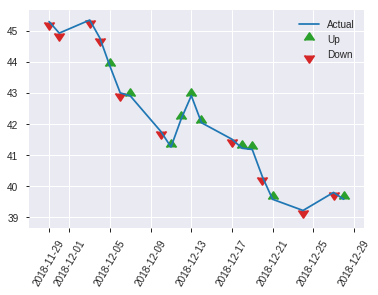


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20561673815511605
RMSE: 0.45344981878386065
LogLoss: 0.5976829958133999
Null degrees of freedom: 250
Residual degrees of freedom: 187
Null deviance: 349.6521945213129
Residual deviance: 300.03686389832677
AIC: 428.03686389832677
AUC: 0.7226209463051568
pr_auc: 0.6058771467726813
Gini: 0.44524189261031366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24355254471057033: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   108  0.7105   (108.0/152.0)
1      6    93   0.0606   (6.0/99.0)
Total  50   201  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243553     0.62      200
max f2                       0.200784     0.793269  227
max f0point5                 0.567944     0.633423  67
max accuracy                 0.567944     0.709163  67
max precision                0.863967     1         0
max recall                   0.200784     1         227
max specificity              0.863967     1         0
max absolute_mcc             0.56089      0.370657  69
max min_per_class_accuracy   0.431739     0.656566  114
max mean_per_class_accuracy  0.510023     0.677565  87

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 42.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.827618           1.69024   1.69024            0.666667         0.843447  0.666667                    0.843447            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.820252           0.845118  1.26768            0.333333         0.822719  0.5                         0.833083            0.010101        0.030303                   -15.4882  26.7677
    3        0.0318725                   0.814563           2.53535   1.5846             1                0.816174  0.625                       0.828856            0.020202        0.0505051                  153.535   58.4596
    4        0.0438247                   0.774245           2.53535   1.84389            1                0.791376  0.727273                    0.818634            0.030303        0.0808081                  153.535   84.3893
    5        0.0517928                   0.770872           1.26768   1.75524            0.5              0.773615  0.692308                    0.811708            0.010101        0.0909091                  26.7677   75.5245
    6        0.103586                    0.701506           1.95027   1.85276            0.769231         0.724266  0.730769                    0.767987            0.10101         0.191919                   95.0272   85.2758
    7        0.151394                    0.659135           1.47896   1.73472            0.583333         0.674599  0.684211                    0.738496            0.0707071       0.262626                   47.8956   73.4716
    8        0.203187                    0.604068           1.95027   1.78966            0.769231         0.623723  0.705882                    0.70924             0.10101         0.363636                   95.0272   78.9661
    9        0.302789                    0.541675           1.4198    1.668              0.56             0.577086  0.657895                    0.665768            0.141414        0.505051                   41.9798   66.7996
    10       0.40239                     0.474996           1.01414   1.50615            0.4              0.50655   0.594059                    0.626358            0.10101         0.606061                   1.41414   50.6151
    11       0.501992                    0.406309           0.709899  1.34816            0.28             0.433486  0.531746                    0.58809             0.0707071       0.676768                   -29.0101  34.8164
    12       0.601594                    0.344326           0.912727  1.27607            0.36             0.37096   0.503311                    0.552141            0.0909091       0.767677                   -8.72727  27.6072
    13       0.701195                    0.311155           0.709899  1.19565            0.28             0.326215  0.471591                    0.520049            0.0707071       0.838384                   -29.0101  19.565
    14       0.800797                    0.243553           1.01414   1.17307            0.4              0.270064  0.462687                    0.488957            0.10101         0.939394                   1.41414   17.3074
    15       0.900398                    0.201525           0.507071  1.0994             0.2              0.223333  0.433628                    0.459573            0.0505051       0.989899                   -49.2929  9.94011
    16       1                           0.104815           0.101414  1                  0.04             0.161952  0.394422                    0.42993           

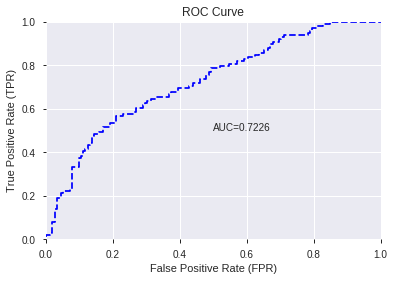

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


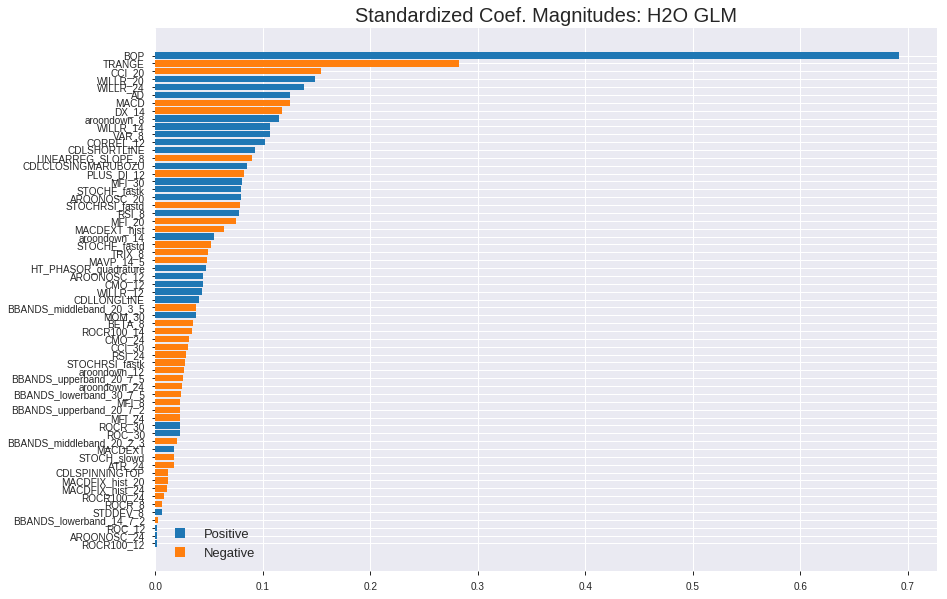

'log_likelihood'
--2019-08-27 16:32:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


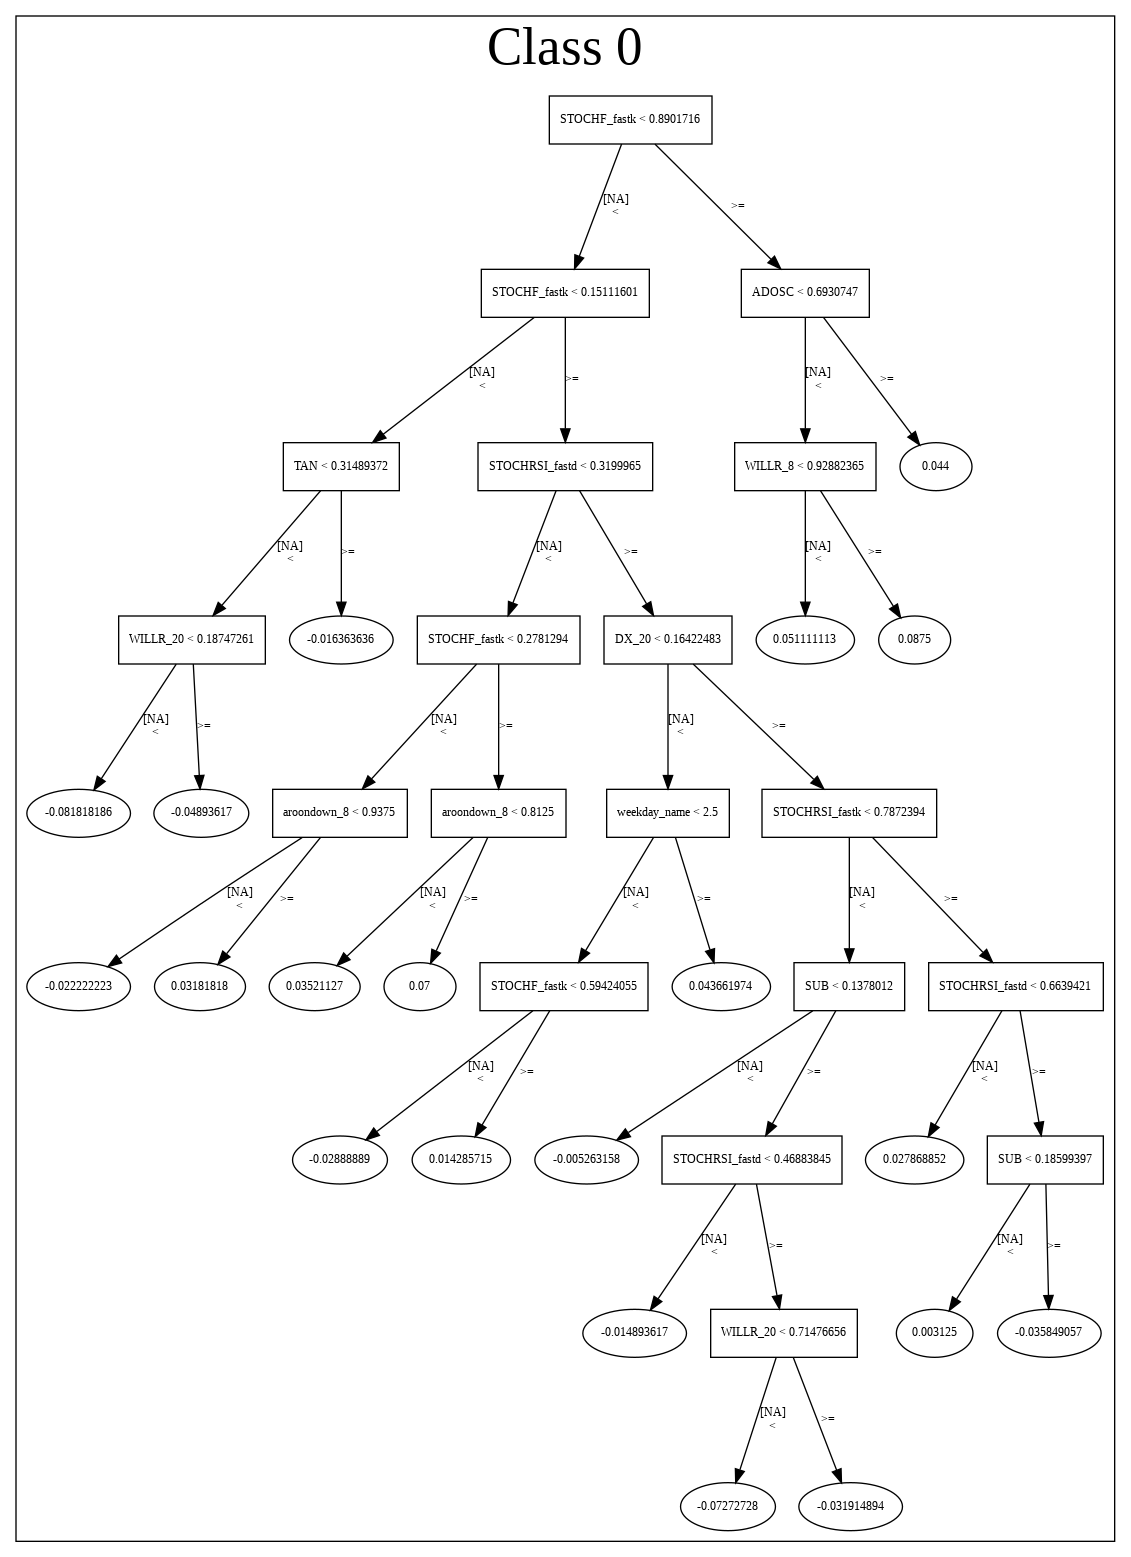

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_163242_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_163242_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CCI_20',
 'WILLR_20',
 'WILLR_24',
 'AD',
 'MACD',
 'DX_14',
 'aroondown_8',
 'WILLR_14',
 'VAR_8',
 'CORREL_12',
 'CDLSHORTLINE',
 'LINEARREG_SLOPE_8',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_12',
 'MFI_30',
 'STOCHF_fastk',
 'AROONOSC_20',
 'STOCHRSI_fastd',
 'RSI_8',
 'MFI_20',
 'MACDEXT_hist',
 'aroondown_14',
 'STOCHF_fastd',
 'TRIX_8',
 'MAVP_14_5',
 'HT_PHASOR_quadrature',
 'AROONOSC_12',
 'CMO_12',
 'WILLR_12',
 'CDLLONGLINE',
 'BBANDS_middleband_20_3_5',
 'MOM_30',
 'BETA_8',
 'ROCR100_14',
 'CMO_24',
 'CCI_30',
 'RSI_24',
 'STOCHRSI_fastk',
 'aroondown_12',
 'BBANDS_upperband_20_7_5',
 'aroondown_24',
 'BBANDS_lowerband_30_7_5',
 'MFI_8',
 'BBANDS_upperband_20_7_2',
 'MFI_24',
 'ROCR_30',
 'ROC_30',
 'BBANDS_middleband_20_2_3',
 'MACDEXT',
 'STOCH_slowd',
 'ATR_24',
 'CDLSPINNINGTOP',
 'MACDFIX_hist_20',
 'MACDFIX_hist_24',
 'ROCR100_24',
 'ROCR_8',
 'STDDEV_8',
 'BBANDS_lowerband_14_7_2',
 'ROC_12',
 'AROONOSC_24',
 'ROCR100_12']

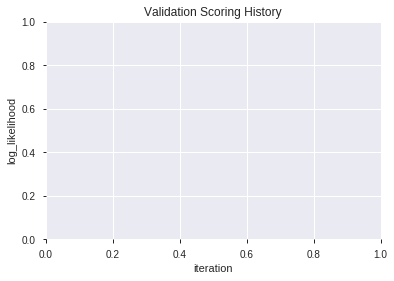

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_163303  0.748870  0.595227              0.304957  0.451922  0.204234
1  XGBoost_grid_1_AutoML_20190827_163303_model_1  0.748870  0.592696              0.300970  0.450928  0.203336
2  XGBoost_grid_1_AutoML_20190827_163303_model_6  0.747142  0.601144              0.305323  0.455137  0.207149
3               XGBoost_1_AutoML_20190827_163303  0.741295  0.592316              0.318946  0.450815  0.203234
4               XGBoost_2_AutoML_20190827_163303  0.739899  0.592961              0.315889  0.451805  0.204128
5  XGBoost_grid_1_AutoML_20190827_163303_model_2  0.735247  0.608484              0.357955  0.458697  0.210403
6  XGBoost_grid_1_AutoML_20190827_163303_model_4  0.734981  0.599793              0.331871  0.454939  0.206970
7  XGBoost_grid_1_AutoML_20190827_163303_model_3  0.721026  0.611630              0.324462  0.460485  0.212047
8  XGBoost_grid_1_AutoML_20190827_163303_model_7  0.714381  0.617934              0.353137  0.463232  0.214584
9  XGBoost_grid_1_AutoML_20190827_163303_model_5  0.709596  0.621812              0.338915  0.466194  0.217336

variable  relative_importance  scaled_importance  percentage
0                       BOP          2645.140625           1.000000    0.306969
1              STOCHF_fastk           613.064331           0.231770    0.071146
2                    TRANGE           512.596191           0.193788    0.059487
3                 CORREL_12           177.895721           0.067254    0.020645
4                PLUS_DI_12           161.547333           0.061073    0.018748
..                      ...                  ...                ...         ...
58  BBANDS_upperband_20_7_2            18.708817           0.007073    0.002171
59             CDLSHORTLINE            18.456274           0.006977    0.002142
60                    VAR_8            15.911829           0.006015    0.001847
61               ROCR100_12            10.613829           0.004013    0.001232
62           CDLSPINNINGTOP             7.949650           0.003005    0.000923

[63 rows x 4 columns]

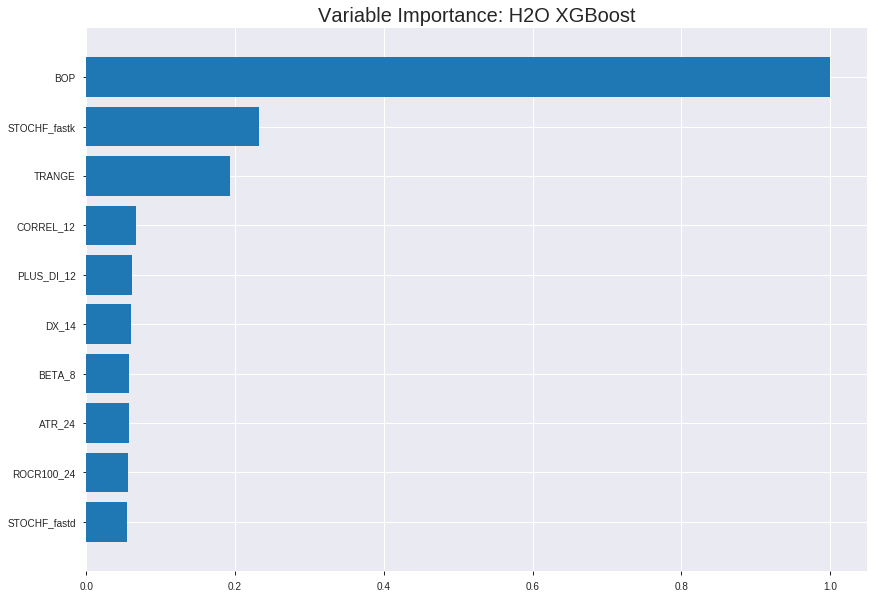

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_163303


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13660388070846663
RMSE: 0.3695996221703516
LogLoss: 0.4385185452158008
Mean Per-Class Error: 0.16785644537607247
AUC: 0.91826200736912
pr_auc: 0.9228591576940668
Gini: 0.83652401473824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5455166548490524: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      746  117  0.1356   (117.0/863.0)
1      182  708  0.2045   (182.0/890.0)
Total  928  825  0.1706   (299.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.545517     0.825656  186
max f2                       0.332256     0.907492  282
max f0point5                 0.593567     0.865539  161
max accuracy                 0.56833      0.831147  174
max precision                0.931404     1         0
max recall                   0.24672      1         318
max specificity              0.931404     1         0
max absolute_mcc             0.56833      0.66898   174
max min_per_class_accuracy   0.522836     0.821348  198
max mean_per_class_accuracy  0.56833      0.832144  174

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.902422           1.96966    1.96966            1                0.912693  1                           0.912693            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.894415           1.96966    1.96966            1                0.898165  1                           0.905429            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.883227           1.96966    1.96966            1                0.888852  1                           0.900112            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.867127           1.96966    1.96966            1                0.875863  1                           0.893964            0.0202247       0.0797753                  96.9663   96.9663
    5        0.0501997                   0.85887            1.96966    1.96966            1                0.862063  1                           0.887802            0.0191011       0.0988764                  96.9663   96.9663
    6        0.100399                    0.811284           1.96966    1.96966            1                0.836299  1                           0.86205             0.0988764       0.197753                   96.9663   96.9663
    7        0.150029                    0.769066           1.8791     1.93971            0.954023         0.791748  0.984791                    0.838794            0.0932584       0.291011                   87.9104   93.9706
    8        0.200228                    0.733417           1.90252    1.93038            0.965909         0.751811  0.980057                    0.816987            0.0955056       0.386517                   90.2515   93.0382
    9        0.300057                    0.664611           1.80083    1.88728            0.914286         0.696489  0.958175                    0.776897            0.179775        0.566292                   80.0835   88.7282
    10       0.399886                    0.596585           1.49694    1.78984            0.76             0.631264  0.908702                    0.740541            0.149438        0.71573                    49.6944   78.9836
    11       0.500285                    0.524619           1.01841    1.63502            0.517045         0.559808  0.830103                    0.704271            0.102247        0.817978                   1.84053   63.5022
    12       0.600114                    0.449048           0.787865   1.4941             0.4              0.486142  0.758555                    0.667985            0.0786517       0.896629                   -21.2135  49.4098
    13       0.699943                    0.359183           0.697823   1.38053            0.354286         0.40691   0.700896                    0.630749            0.0696629       0.966292                   -30.2177  38.053
    14       0.799772                    0.258671           0.292636   1.24474            0.148571         0.306148  0.631954                    0.590232            0.0292135       0.995506                   -70.7364  24.4737
    15       0.899601                    0.170259           0.0450209  1.1116             0.0228571        0.21952   0.564363                    0.549094            0.00449438      1                          -95.4979  11.1604
    16       1                           0.0448514          0          1                  0                0.123346  0.507701                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20311911084151604
RMSE: 0.4506873759509091
LogLoss: 0.5916086066296611
Mean Per-Class Error: 0.310093152789782
AUC: 0.7500560197189411
pr_auc: 0.7551448381050782
Gini: 0.5001120394378822
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33656495809555054: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  134  0.5726   (134.0/234.0)
1      30   237  0.1124   (30.0/267.0)
Total  130  371  0.3273   (164.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336565     0.742947  293
max f2                       0.227462     0.860357  352
max f0point5                 0.61851      0.717368  138
max accuracy                 0.457978     0.690619  228
max precision                0.925808     1         0
max recall                   0.143042     1         388
max specificity              0.925808     1         0
max absolute_mcc             0.61851      0.383628  138
max min_per_class_accuracy   0.500738     0.675214  205
max mean_per_class_accuracy  0.518404     0.689907  198

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.894865           1.8764    1.8764             1                0.904615  1                           0.904615            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.886378           1.8764    1.8764             1                0.888911  1                           0.897477            0.0187266       0.0411985                  87.6404   87.6404
    3        0.0319361                   0.870019           1.12584   1.64185            0.6              0.87505   0.875                       0.890469            0.011236        0.0524345                  12.5843   64.1854
    4        0.0419162                   0.857761           1.50112   1.60835            0.8              0.862165  0.857143                    0.88373             0.0149813       0.0674157                  50.1124   60.8347
    5        0.0518962                   0.838957           1.8764    1.6599             1                0.850457  0.884615                    0.877331            0.0187266       0.0861423                  87.6404   65.9896
    6        0.101796                    0.785843           1.50112   1.58207            0.8              0.810613  0.843137                    0.844626            0.0749064       0.161049                   50.1124   58.2067
    7        0.151697                    0.760985           1.27596   1.48137            0.68             0.773457  0.789474                    0.821215            0.0636704       0.224719                   27.5955   48.1372
    8        0.201597                    0.720626           1.50112   1.48626            0.8              0.743082  0.792079                    0.801875            0.0749064       0.299625                   50.1124   48.6261
    9        0.301397                    0.646981           1.53865   1.50361            0.82             0.686518  0.801325                    0.763678            0.153558        0.453184                   53.8652   50.3609
    10       0.401198                    0.579639           1.16337   1.41897            0.62             0.609339  0.756219                    0.725285            0.116105        0.569288                   16.3371   41.8973
    11       0.500998                    0.513965           1.01326   1.33815            0.54             0.549051  0.713147                    0.690178            0.101124        0.670412                   1.32584   33.8153
    12       0.600798                    0.434256           0.900674  1.26548            0.48             0.467502  0.674419                    0.653189            0.0898876       0.7603                     -9.93258  26.5482
    13       0.700599                    0.354102           0.863146  1.20817            0.46             0.395694  0.643875                    0.616509            0.0861423       0.846442                   -13.6854  20.8169
    14       0.800399                    0.286328           0.78809   1.15579            0.42             0.323623  0.61596                     0.579989            0.0786517       0.925094                   -21.191   15.579
    15       0.9002                      0.21474            0.525393  1.0859             0.28             0.253287  0.578714                    0.54377             0.0524345       0.977528                   -47.4607  8.59015
    16       1                           0.0514479          0.225169  1                  0.12             0.161301  0.532934                    0.505599          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:33:06  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-27 16:33:06  0.135 sec   5                  0.473627         0.641468            0.834595        0.793365           1.91495          0.271535                         0.482828           0.659207              0.73329           0.693143             1.4349             0.339321
    2019-08-27 16:33:06  0.201 sec   10                 0.453962         0.60361             0.842525        0.822079           1.96966          0.269253                         0.471418           0.636742              0.737668          0.732466             1.56367            0.315369
    2019-08-27 16:33:06  0.267 sec   15                 0.440451         0.577495            0.854639        0.855979           1.96966          0.270394                         0.465521           0.624829              0.739148          0.736736             1.56367            0.327345
    2019-08-27 16:33:06  0.336 sec   20                 0.428671         0.554536            0.863743        0.866566           1.96966          0.25271                          0.460759           0.615006              0.742453          0.742057             1.56367            0.333333
    2019-08-27 16:33:06  0.407 sec   25                 0.418239         0.533877            0.86987         0.871715           1.96966          0.253851                         0.458307           0.609561              0.739668          0.73809              1.56367            0.331337
    2019-08-27 16:33:07  0.480 sec   30                 0.409662         0.516763            0.876968        0.881051           1.96966          0.24073                          0.456217           0.605086              0.740997          0.741031             1.56367            0.319361
    2019-08-27 16:33:07  0.556 sec   35                 0.403037         0.503579            0.883181        0.887484           1.96966          0.236737                         0.454019           0.600228              0.745751          0.746754             1.56367            0.327345
    2019-08-27 16:33:07  0.631 sec   40                 0.39698          0.49139             0.888588        0.89161            1.96966          0.235596                         0.452208           0.596275              0.749128          0.74729              1.56367            0.323353
    2019-08-27 16:33:07  0.716 sec   45                 0.390768         0.478979            0.895204        0.899831           1.96966          0.235026                         0.451584           0.594743              0.748087          0.748171             1.56367            0.329341
    2019-08-27 16:33:07  0.787 sec   50                 0.385377         0.468475            0.900909        0.904808           1.96966          0.229321                         0.452148           0.595656              0.746519          0.745122             1.56367            0.317365
    2019-08-27 16:33:07  0.863 sec   55                 0.379508         0.457474            0.908853        0.913802           1.96966          0.20194                          0.452072           0.595346              0.746399          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2645.140625            1.0                    0.30696871638723316
STOCHF_fastk             613.0643310546875      0.2317700334191826     0.07114614965571261
TRANGE                   512.59619140625        0.193787879011631      0.05948681647160481
CORREL_12                177.89572143554688     0.06725378596290958    0.020644808349216073
PLUS_DI_12               161.54733276367188     0.06107324927712374    0.01874757693619619
---                      ---                    ---                    ---
BBANDS_upperband_20_7_2  18.708816528320312     0.007072900529936972   0.0021711591968093333
CDLSHORTLINE             18.456274032592773     0.0069774264015142005  0.0021418516261592054
VAR_8                    15.911828994750977     0.0060154945428472165  0.001846568638252216
ROCR100_12               10.613828659057617     0.0040125763291158165  0.0012317354051544782
CDLSPINNINGTOP           7.949649810791016      0.0030053788957972757  0.0009225573019001699


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.6583333333333333)

('auc', 0.7488702817650186)

('logloss', 0.5952270839965829)

('mean_per_class_error', 0.30495746943115365)

('rmse', 0.45192218891295005)

('mse', 0.20423366483187214)

xgboost prediction progress: |████████████████████████████████████████████| 100%


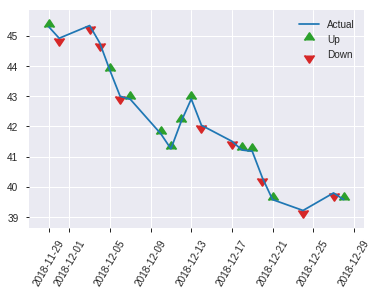


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20423366483187214
RMSE: 0.45192218891295005
LogLoss: 0.5952270839965829
Mean Per-Class Error: 0.30495746943115365
AUC: 0.7488702817650186
pr_auc: 0.6433280959969646
Gini: 0.49774056353003715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4445949196815491: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   62   0.4079   (62.0/152.0)
1      20   79   0.202    (20.0/99.0)
Total  110  141  0.3267   (82.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444595     0.658333  140
max f2                       0.295524     0.789037  205
max f0point5                 0.595015     0.639098  74
max accuracy                 0.595015     0.713147  74
max precision                0.745026     0.888889  17
max recall                   0.200901     1         242
max specificity              0.905647     0.993421  0
max absolute_mcc             0.444595     0.384231  140
max min_per_class_accuracy   0.516507     0.676768  113
max mean_per_class_accuracy  0.444595     0.695043  140

Gains/Lift Table: Avg response rate: 39.44 %, avg score: 48.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.902187           1.69024   1.69024            0.666667         0.903706  0.666667                    0.903706            0.020202        0.020202                   69.0236   69.0236
    2        0.0239044                   0.880323           2.53535   2.11279            1                0.891742  0.833333                    0.897724            0.030303        0.0505051                  153.535   111.279
    3        0.0318725                   0.841684           2.53535   2.21843            1                0.846761  0.875                       0.884983            0.020202        0.0707071                  153.535   121.843
    4        0.0438247                   0.837504           1.69024   2.07438            0.666667         0.839151  0.818182                    0.872483            0.020202        0.0909091                  69.0236   107.438
    5        0.0517928                   0.791837           2.53535   2.1453             1                0.819039  0.846154                    0.864261            0.020202        0.111111                   153.535   114.53
    6        0.103586                    0.713157           2.1453    2.1453             0.846154         0.740476  0.846154                    0.802368            0.111111        0.222222                   114.53    114.53
    7        0.151394                    0.671707           0.633838  1.668              0.25             0.691322  0.657895                    0.767301            0.030303        0.252525                   -36.6162  66.7996
    8        0.203187                    0.641719           1.95027   1.73995            0.769231         0.661568  0.686275                    0.740349            0.10101         0.353535                   95.0272   73.9949
    9        0.302789                    0.590711           1.62263   1.70136            0.64             0.612869  0.671053                    0.698415            0.161616        0.515152                   62.2626   70.1356
    10       0.40239                     0.547088           0.811313  1.48105            0.32             0.563711  0.584158                    0.665073            0.0808081       0.59596                    -18.8687  48.1048
    11       0.501992                    0.471725           1.21697   1.42865            0.48             0.51103   0.563492                    0.634509            0.121212        0.717172                   21.697    42.8652
    12       0.601594                    0.426069           0.912727  1.34323            0.36             0.450778  0.529801                    0.60409             0.0909091       0.808081                   -8.72727  34.3234
    13       0.701195                    0.363729           0.709899  1.25327            0.28             0.393608  0.494318                    0.574192            0.0707071       0.878788                   -29.0101  25.3271
    14       0.800797                    0.300202           0.608485  1.17307            0.24             0.332461  0.462687                    0.544126            0.0606061       0.939394                   -39.1515  17.3074
    15       0.900398                    0.246506           0.405657  1.08818            0.16             0.273404  0.429204                    0.514179            0.040404        0.979798                   -59.4343  8.81827
    16       1                           0.121207           0.202828  1                  0.08             0.207324  0.394422                    0.483615           

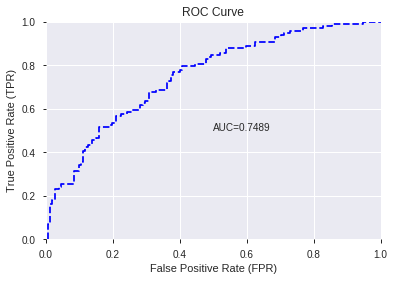

This function is available for GLM models only


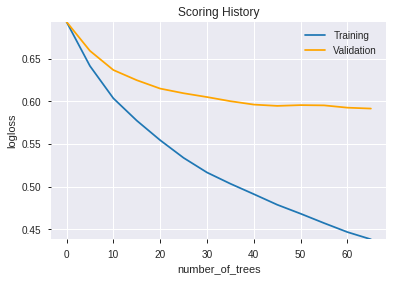

--2019-08-27 16:33:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.100
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.100|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

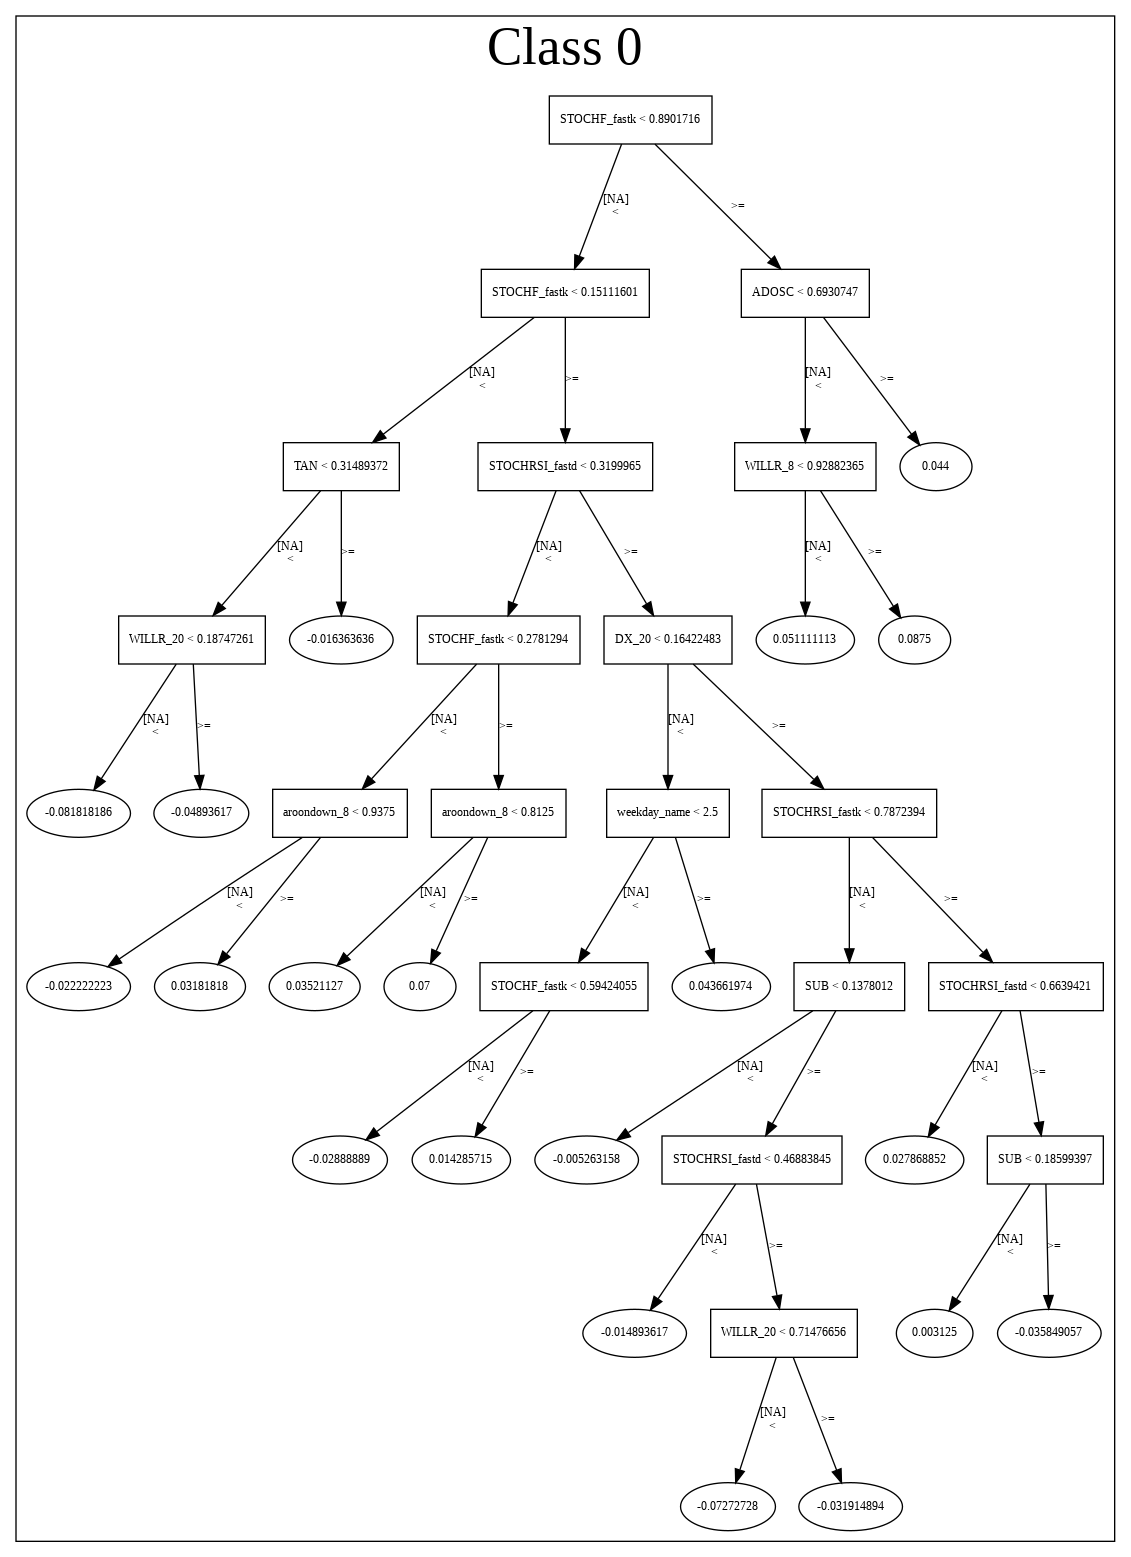

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_163303',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_163303',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b362',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b362',
   'ty

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'CORREL_12',
 'PLUS_DI_12',
 'DX_14',
 'BETA_8',
 'ATR_24',
 'ROCR100_24',
 'STOCHF_fastd',
 'MFI_20',
 'MFI_8',
 'STOCHRSI_fastk',
 'STDDEV_8',
 'STOCH_slowd',
 'WILLR_14',
 'WILLR_20',
 'MACDEXT_hist',
 'ROCR100_14',
 'LINEARREG_SLOPE_8',
 'STOCHRSI_fastd',
 'MACDFIX_hist_20',
 'ROC_12',
 'CCI_20',
 'HT_PHASOR_quadrature',
 'CMO_24',
 'RSI_8',
 'MFI_24',
 'ROCR_8',
 'MFI_30',
 'MACDEXT',
 'AD',
 'MAVP_14_5',
 'CDLLONGLINE',
 'WILLR_12',
 'MOM_30',
 'TRIX_8',
 'CCI_30',
 'BBANDS_lowerband_30_7_5',
 'MACDFIX_hist_24',
 'BBANDS_upperband_20_7_5',
 'aroondown_24',
 'BBANDS_lowerband_14_7_2',
 'AROONOSC_20',
 'BBANDS_middleband_20_3_5',
 'ROC_30',
 'BBANDS_middleband_20_2_3',
 'AROONOSC_24',
 'AROONOSC_12',
 'MACD',
 'CMO_12',
 'WILLR_24',
 'aroondown_14',
 'RSI_24',
 'CDLCLOSINGMARUBOZU',
 'aroondown_8',
 'aroondown_12',
 'ROCR_30',
 'BBANDS_upperband_20_7_2',
 'CDLSHORTLINE',
 'VAR_8',
 'ROCR100_12',
 'CDLSPINNINGTOP']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.725
GLM             0.709
XGBoost         0.713
dtype: float64

DeepLearning    GLM  XGBoost
All          0.661  0.673    0.685
DLF          0.693  0.685    0.681
Fwe          0.709  0.709    0.693
RFE          0.725  0.709    0.713
XGBF         0.701  0.685    0.681





F1


DeepLearning    0.639
GLM             0.634
XGBoost         0.662
dtype: float64

DeepLearning    GLM  XGBoost
All          0.639  0.634    0.655
DLF          0.614  0.621    0.643
Fwe          0.630  0.622    0.662
RFE          0.627  0.620    0.658
XGBF         0.612  0.621    0.643





auc


DeepLearning    0.736
GLM             0.723
XGBoost         0.749
dtype: float64

DeepLearning    GLM  XGBoost
All          0.699  0.700    0.725
DLF          0.706  0.702    0.708
Fwe          0.714  0.723    0.743
RFE          0.736  0.723    0.749
XGBF         0.693  0.702    0.708





logloss


DeepLearning    0.652
GLM             0.690
XGBoost         0.638
dtype: float64

DeepLearning    GLM  XGBoost
All          0.603  0.690    0.615
DLF          0.619  0.629    0.638
Fwe          0.652  0.636    0.625
RFE          0.602  0.598    0.595
XGBF         0.650  0.629    0.638





mean_per_class_error


DeepLearning    0.343
GLM             0.342
XGBoost         0.342
dtype: float64

DeepLearning    GLM  XGBoost
All          0.342  0.342    0.302
DLF          0.329  0.336    0.342
Fwe          0.311  0.318    0.307
RFE          0.326  0.322    0.305
XGBF         0.343  0.336    0.342





rmse


DeepLearning    0.480
GLM             0.487
XGBoost         0.474
dtype: float64

DeepLearning    GLM  XGBoost
All          0.459  0.487    0.462
DLF          0.465  0.469    0.474
Fwe          0.480  0.470    0.467
RFE          0.455  0.453    0.452
XGBF         0.479  0.469    0.474





mse


DeepLearning    0.230
GLM             0.238
XGBoost         0.224
dtype: float64

DeepLearning    GLM  XGBoost
All          0.210  0.238    0.213
DLF          0.216  0.220    0.224
Fwe          0.230  0.221    0.218
RFE          0.207  0.206    0.204
XGBF         0.229  0.220    0.224

{'F1':       DeepLearning    GLM  XGBoost
 All          0.639    NaN      NaN
 DLF          0.614    NaN      NaN
 DLF            NaN  0.621      NaN
 DLF            NaN    NaN    0.643
 All            NaN  0.634      NaN
 All            NaN    NaN    0.655
 XGBF         0.612    NaN      NaN
 XGBF           NaN  0.621      NaN
 XGBF           NaN    NaN    0.643
 Fwe          0.630    NaN      NaN
 Fwe            NaN  0.622      NaN
 Fwe            NaN    NaN    0.662
 RFE          0.627    NaN      NaN
 RFE            NaN  0.620      NaN
 RFE            NaN    NaN    0.658,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.661    NaN      NaN
 DLF          0.693    NaN      NaN
 DLF            NaN  0.685      NaN
 DLF            NaN    NaN    0.681
 All            NaN  0.673      NaN
 All            NaN    NaN    0.685
 XGBF         0.701    NaN      NaN
 XGBF           NaN  0.685      NaN
 XGBF           NaN    NaN    0.681
 Fwe          0.709    NaN      NaN
 Fwe     